# Análise Final La Msion Brasil

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

from scipy import stats
import statsmodels.api as sm
import scikit_posthocs as sp

In [2]:
# Define que o pandas não deve limitar o número de colunas exibidas
pd.set_option("display.max_columns", None)

# BÔNUS: Você também pode fazer o mesmo para as linhas
pd.set_option("display.max_rows", None)

# BÔNUS: E aumentar a largura da exibição para evitar quebras de linha
pd.set_option("display.width", 1000)

## Carregando os dados

In [3]:
df_completo = pd.read_csv("Dados/df_completo_final.csv", sep=",")
df_completo.head(10)

,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0
3,André Mapa,Homens,35 a 44,Não informado,2023,4.0,363,2023,46.0,-81.0
4,André Mapa,Homens,35 a 44,Não informado,2023,5.0,357,2023,41.0,-58.0
5,André Mapa,Homens,35 a 44,Não informado,2023,6.0,670,2023,128.0,-11.0
6,André Mapa,Homens,35 a 44,Não informado,2023,7.0,258,2023,228.0,-7.0
7,André Mapa,Homens,35 a 44,Não informado,2023,8.0,211,2023,1.0,-243.0
8,André Mapa,Homens,35 a 44,Não informado,2023,9.0,338,2023,1.0,-122.0
9,André Mapa,Homens,35 a 44,Não informado,2023,10.0,544,2023,9.0,-69.0


In [4]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3880 entries, 0 to 3879
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Nome Atleta        3880 non-null   object 
 1   sexo               3880 non-null   object 
 2   faixa_etaria       3880 non-null   object 
 3   peso               3880 non-null   object 
 4   ano                3880 non-null   int64  
 5   km_prova           3880 non-null   float64
 6   tempo_por_km_seg   3880 non-null   int64  
 7   ano_mais_antigo    3880 non-null   int64  
 8   desnivel_positivo  3880 non-null   float64
 9   desnivel_negativo  3880 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 303.3+ KB


In [5]:
df_completo.describe()

,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo
count,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000
mean,2022.519588,18.302835,711.316237,2022.519588,78.211598,-78.093814
std,0.499681,10.281036,502.194156,0.499681,93.670162,85.562874
min,2022.000000,1.000000,23.000000,2022.000000,0.000000,-329.000000
25%,2022.000000,9.000000,401.000000,2022.000000,6.000000,-137.000000
50%,2023.000000,18.000000,558.000000,2023.000000,44.000000,-42.000000
75%,2023.000000,27.000000,834.000000,2023.000000,143.000000,-11.000000
max,2023.000000,36.000000,4463.000000,2023.000000,354.000000,0.000000


## Análise Exploratória dos dados

Vamos começar analisando o desempenho geral dos atletas. Para isso devemos trasnformar nosso dataframe onde cada linha é um km do atleta, para um novo onde cada linha dever uma única observação do atleta e as variáveis vão ser um resumo.

In [6]:
df_agregado_por_atleta = (
    df_completo.groupby("Nome Atleta")
    .agg(
        # Pega a informação demográfica (que é a mesma em todas as linhas do atleta)
        sexo=("sexo", "first"),
        faixa_etaria=("faixa_etaria", "first"),
        peso=("peso", "first"),
        ano_corrida=("ano", "first"),  # Pega o ano da corrida
        # Calcula as métricas de desempenho e estratégia
        Tempo_Final_seg=("tempo_por_km_seg", "sum"),
        Ritmo_Medio_seg=("tempo_por_km_seg", "mean"),
        Variabilidade_Ritmo_std=(
            "tempo_por_km_seg",
            "std",
        ),  # Desvio padrão do ritmo por km
        # Calcula as métricas de esforço relacionadas ao percurso
        Total_Desnivel_Positivo=("desnivel_positivo", "sum"),
        Total_Desnivel_negativo=("desnivel_negativo", "sum"),
    )
    .reset_index()
)

# Para facilitar a interpretação, vamos converter segundos para minutos
df_agregado_por_atleta["Tempo_Final_min"] = (
    df_agregado_por_atleta["Tempo_Final_seg"] / 60
)
df_agregado_por_atleta["Ritmo_Medio_min"] = (
    df_agregado_por_atleta["Ritmo_Medio_seg"] / 60
)
df_agregado_por_atleta["Variabilidade_Ritmo_min_std"] = (
    df_agregado_por_atleta["Variabilidade_Ritmo_std"] / 60
)

# Vamos ver como ficou
df_agregado_por_atleta.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.900000,10.080556,4.838189
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,533.100000,14.808333,6.959947
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,563.766667,15.660185,11.161993
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,2022,18496,513.777778,261.647539,2787.0,-2790.0,308.266667,8.562963,4.360792
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,2022,14626,417.885714,195.390826,2779.0,-2781.0,243.766667,6.964762,3.256514


In [7]:
df_agregado_por_atleta.describe()

,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std
count,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000,109.000000
mean,2022.522936,25320.247706,712.080833,421.113491,2784.045872,-2779.853211,422.004128,11.868014,7.018558
std,0.501781,7378.201520,210.163355,195.872922,3.996261,33.268221,122.970025,3.502723,3.264549
min,2022.000000,14184.000000,394.000000,174.153463,2777.000000,-2790.000000,236.400000,6.566667,2.902558
25%,2022.000000,19740.000000,559.285714,277.364479,2779.000000,-2790.000000,329.000000,9.321429,4.622741
50%,2023.000000,23389.000000,649.694444,338.790751,2787.000000,-2790.000000,389.816667,10.828241,5.646513
75%,2023.000000,31520.000000,886.055556,575.846688,2787.000000,-2781.000000,525.333333,14.767593,9.597445
max,2023.000000,47456.000000,1355.885714,990.812630,2787.000000,-2630.000000,790.933333,22.598095,16.513544


### Análises gráficas

#### Dstribuição do tempo final

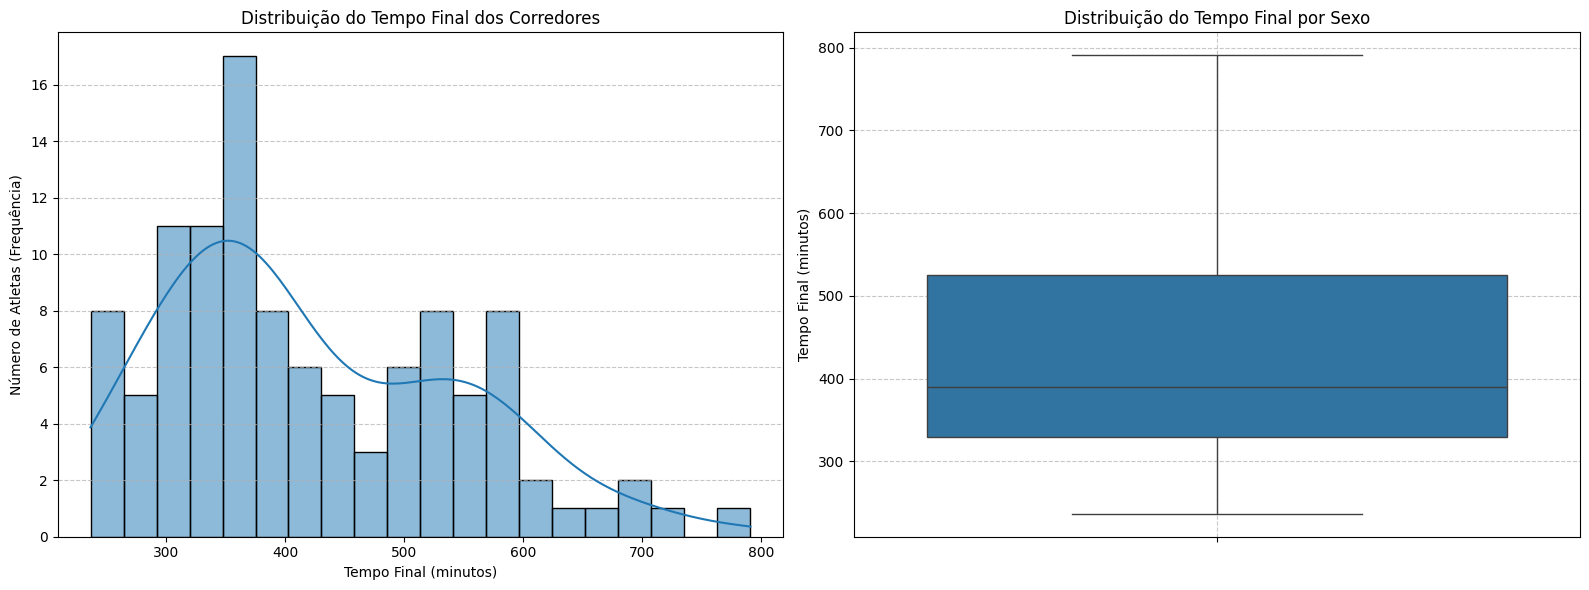

count    109.000000
mean     422.004128
std      122.970025
min      236.400000
25%      329.000000
50%      389.816667
75%      525.333333
max      790.933333
Name: Tempo_Final_min, dtype: float64

 count     1.816667
mean      7.033402
std       2.049500
min       3.940000
25%       5.483333
50%       6.496944
75%       8.755556
max      13.182222
Name: Tempo_Final_min, dtype: float64


In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.histplot(
    data=df_agregado_por_atleta,
    x="Tempo_Final_min",
    kde=True,
    bins=20,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Tempo Final dos Corredores")
axes[0].set_xlabel("Tempo Final (minutos)")  # Adicionando rótulo ao eixo x
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


sns.boxplot(
    data=df_agregado_por_atleta,
    y="Tempo_Final_min",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Distribuição do Tempo Final por Sexo")
axes[1].set_ylabel("Tempo Final (minutos)")
axes[1].grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

# Também é útil ver as estatísticas descritivas
print(df_agregado_por_atleta["Tempo_Final_min"].describe())

print("\n", df_agregado_por_atleta["Tempo_Final_min"].describe() / 60)

#### Análise do Sexo

In [9]:
df_agregado_por_atleta["sexo"].value_counts()

sexo
Homens      78
Mulheres    31
Name: count, dtype: int64

- Aqui podemos observar a que a quantidade de participantes homens é maior que a participação de mulheres.

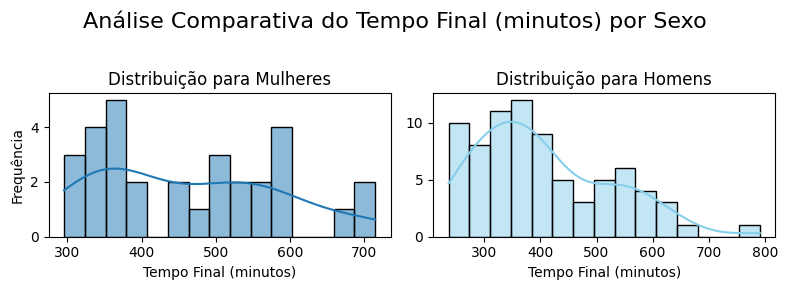

--- Estatísticas Descritivas Comparativas ---
       Mulheres  Homens
count     31.00   78.00
mean     463.71  405.43
std      123.35  119.60
min      295.48  236.40
25%      358.56  314.38
50%      444.42  374.14
75%      557.38  497.77
max      714.43  790.93


In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# Título principal para a figura inteira
fig.suptitle("Análise Comparativa do Tempo Final (minutos) por Sexo", fontsize=16)


# 2. Plote o histograma das Mulheres no primeiro eixo (axes[0])
sns.histplot(
    data=df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"],
    x="Tempo_Final_min",
    bins=15,
    kde=True,
    ax=axes[0],
)  # A chave é especificar o eixo aqui!
axes[0].set_title("Distribuição para Mulheres")
axes[0].set_xlabel("Tempo Final (minutos)")
axes[0].set_ylabel("Frequência")


# 3. Plote o histograma dos Homens no segundo eixo (axes[1])
sns.histplot(
    data=df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"],
    x="Tempo_Final_min",
    bins=15,
    kde=True,
    color="skyblue",  # Mudar a cor ajuda na diferenciação
    ax=axes[1],
)  # E aqui também!
axes[1].set_title("Distribuição para Homens")
axes[1].set_xlabel("Tempo Final (minutos)")
axes[1].set_ylabel("")  # Pode remover o label do eixo Y para um visual mais limpo


# 4. Exiba os gráficos
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajusta o layout para evitar sobreposição
plt.show()


# ======================================================================
# PARTE 2: ESTATÍSTICAS (.DESCRIBE()) LADO A LADO
# ======================================================================

# 1. Calcule o describe() para cada grupo separadamente
desc_mulheres = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"][
    "Tempo_Final_min"
].describe()
desc_homens = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"][
    "Tempo_Final_min"
].describe()


# 2. Use pd.concat para unir as duas saídas como colunas de um novo DataFrame
# axis=1 indica que a concatenação deve ser feita pelas colunas (lado a lado).
# keys=[] define os nomes das novas colunas.
estatisticas_comparativas = pd.concat(
    [desc_mulheres, desc_homens], axis=1, keys=["Mulheres", "Homens"]
)


# 3. Imprima a tabela comparativa final
print("--- Estatísticas Descritivas Comparativas ---")
print(
    estatisticas_comparativas.round(2)
)  # .round(2) para formatar com 2 casas decimais


In [11]:
estatisticas_describe = ["count", "mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_agregado_por_atleta.groupby("sexo")
    .agg(
        {
            "Tempo_Final_min": estatisticas_describe,
            "Ritmo_Medio_min": estatisticas_describe,
            "Variabilidade_Ritmo_min_std": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Sexo ---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Sexo ---
                                      count    mean     std     min  median     max
sexo                                                                               
Homens   Ritmo_Medio_min                 78   11.37    3.37    6.57   10.39   22.60
         Tempo_Final_min                 78  405.43  119.60  236.40  374.14  790.93
         Variabilidade_Ritmo_min_std     78    6.63    3.08    2.90    5.13   16.40
Mulheres Ritmo_Medio_min                 31   13.11    3.56    8.21   12.49   20.41
         Tempo_Final_min                 31  463.71  123.35  295.48  444.42  714.43
         Variabilidade_Ritmo_min_std     31    7.99    3.56    3.90    7.16   16.51


C:\Users\Home\AppData\Local\Temp\ipykernel_4648\3671722932.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


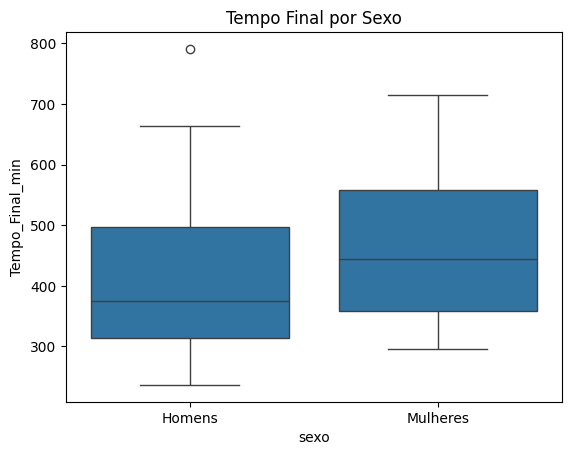

In [12]:
# Sexo vs. Tempo Final
sns.boxplot(data=df_agregado_por_atleta, x="sexo", y="Tempo_Final_min")
plt.title("Tempo Final por Sexo")
plt.show()


1. Tempo Final da Prova (Tempo_Final_min)

Desempenho Médio: Os homens terminaram a prova, em média, cerca de 1 hora mais rápido que as mulheres (mean de 406 min para homens vs. 465 min para mulheres). A mediana (o valor do meio) confirma essa tendência, mostrando que o corredor "mediano" masculino também foi consideravelmente mais rápido.

Dispersão: A dispersão dos tempos é alta e relativamente parecida para ambos os grupos (std de 119 min para homens e 124 min para mulheres). Isso indica que, em ambos os sexos, havia uma grande variedade de níveis de habilidade, desde os corredores mais rápidos até os que levaram mais tempo. Podendo existir níveis entre os corredores, indo de corredores mais experientes e profissionais ate corredores amadores e menos experientes.

2. Ritmo Médio (Ritmo_Medio_min)

Velocidade Média: Confirmando o dado anterior, o ritmo médio dos homens foi mais baixo (mais rápido), com uma média de 11.36 min/km contra 13.07 min/km das mulheres.

Melhores e Piores Ritmos: O homem mais rápido teve um ritmo médio de 6.57 min/km, enquanto a mulher mais rápida teve um ritmo médio de 8.21 min/km. Ambos os grupos tiveram atletas com ritmos médios bem mais lentos (22.60 e 20.41 min/km), o que é comum em corridas de montanha devido à dificuldade do percurso.

3. Variabilidade do Ritmo (Variabilidade_Ritmo_min_std)

Consistência da Prova: Esta é talvez a métrica mais interessante. Em média, os homens tiveram uma menor variabilidade de ritmo dentro da sua prova (mean de 6.63) em comparação com as mulheres (mean de 7.98).

#####  T'este de Hipótese: Tempo de Prova entre Homens e Mulheres
> Pergunta: "A diferença no tempo médio de prova (Tempo_Final_min) entre homens e mulheres é estatisticamente significativa?"

- Teste Proposto: Teste T de Student para amostras independentes. Correto, este é o teste ideal para comparar as médias de dois grupos independentes.

Passos Detalhados:
- Hipóteses:
> H0: : A média do tempo final de prova para homens é igual à média do tempo final de prova para mulheres (μ*homens* = μ*mulheres*)

> H1 : A média do tempo final de prova 'para homens é diferente da média do tempo final de prova para mulheres (μ*homens* != μ*mulheres*)

- Nível de Significância: α=0.05.

###### Verificando Normalidade
Um dos pressupostos e fator que nos ajuda a saber qual teste utilizar é se as distribuições seguem normalidade. Vamos usar o teste Shapiro-wilk para verificar essa nromalidade.

In [13]:
# Defina o nível de significância (alfa)
alfa = 0.05

tempo_homens = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Homens"][
    "Tempo_Final_min"
]
tempo_mulheres = df_agregado_por_atleta[df_agregado_por_atleta["sexo"] == "Mulheres"][
    "Tempo_Final_min"
]

print(f"\nTamanho da amostra - Homens: {len(tempo_homens)}")
print(f"Tamanho da amostra - Mulheres: {len(tempo_mulheres)}")

print("\n--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---")
stat_shapiro_h, p_shapiro_h = stats.shapiro(tempo_homens)
stat_shapiro_m, p_shapiro_m = stats.shapiro(tempo_mulheres)

print(f"P-valor para o grupo Homens: {p_shapiro_h:.4f}")
print(f"P-valor para o grupo Mulheres: {p_shapiro_m:.4f}")

# Avaliação da normalidade
is_normal_h = p_shapiro_h > alfa
is_normal_m = p_shapiro_m > alfa

if is_normal_h and is_normal_m:
    print("Conclusão: Ambos os grupos parecem seguir uma distribuição normal.")
else:
    print(
        "Conclusão: Pelo menos um dos grupos não segue uma distribuição normal. Um teste não-paramétrico é recomendado."
    )


Tamanho da amostra - Homens: 78
Tamanho da amostra - Mulheres: 31

--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---
P-valor para o grupo Homens: 0.0008
P-valor para o grupo Mulheres: 0.0360
Conclusão: Pelo menos um dos grupos não segue uma distribuição normal. Um teste não-paramétrico é recomendado.


Como pelo menos um, no nosso caso ambos, não seguem normalidade devemos adotar um teste não-paramétrico para comparar as duas distribuições.

###### Teste Não-Paramétrico : Mann-Whitney

Verificando a Homogeneidade das Variânicias.

In [14]:
print(
    "\n--- Verificando Pressuposto de Homogeneidade das Variâncias (Teste de Levene) ---"
)
stat_levene, p_levene = stats.levene(tempo_homens, tempo_mulheres)

print(f"P-valor do Teste de Levene: {p_levene:.4f}")

# Avaliação da homogeneidade
are_variances_equal = p_levene > alfa

if are_variances_equal:
    print("Conclusão: As variâncias dos grupos são consideradas homogêneas (iguais).")
else:
    print(
        "Conclusão: As variâncias dos grupos são consideradas heterogêneas (diferentes)."
    )


--- Verificando Pressuposto de Homogeneidade das Variâncias (Teste de Levene) ---
P-valor do Teste de Levene: 0.4402
Conclusão: As variâncias dos grupos são consideradas homogêneas (iguais).


Teste Mann-Whitney U

In [15]:
stat_final, p_final = stats.mannwhitneyu(
    tempo_homens, tempo_mulheres, alternative="two-sided"
)
nome_teste = "Mann-Whitney U"


print("\n--- Resultados Finais ---")
print(f"Teste Realizado: {nome_teste}")
print(f"Estatística do teste: {stat_final:.4f}")
print(f"P-valor final: {p_final:.4f}")

if p_final < alfa:
    print(f"\nConclusão (com alfa={alfa}): Rejeitamos a hipótese nula.")
    print(
        "Existe uma diferença estatisticamente significativa no tempo final de prova entre homens e mulheres."
    )
else:
    print(f"\nConclusão (com alfa={alfa}): Não rejeitamos a hipótese nula.")
    print(
        "Não há evidências estatísticas suficientes para afirmar que existe uma diferença no tempo final de prova entre homens e mulheres."
    )


--- Resultados Finais ---
Teste Realizado: Mann-Whitney U
Estatística do teste: 889.0000
P-valor final: 0.0319

Conclusão (com alfa=0.05): Rejeitamos a hipótese nula.
Existe uma diferença estatisticamente significativa no tempo final de prova entre homens e mulheres.


**Interpretação do Teste de Hipóteses: Tempo de Prova vs. Sexo**

* **Objetivo:** Verificar se existe uma diferença estatisticamente significativa no tempo final de prova (`Tempo_Final_min`) entre corredores do sexo masculino e feminino.

* **Metodologia e Verificação de Pressupostos:**
    1.  **Normalidade:** O Teste de Shapiro-Wilk foi aplicado a ambos os grupos. O resultado indicou que os dados de tempo para homens (p < 0.05) e para mulheres (p < 0.05) **não seguem uma distribuição normal**.
    2.  **Escolha do Teste:** Devido à quebra do pressuposto de normalidade, o teste não-paramétrico **Mann-Whitney U** foi selecionado em vez do Teste T de Student.
    3.  **Homogeneidade de Variâncias:** O Teste de Levene foi realizado e seu resultado (p > 0.05) indicou que **as variâncias são homogêneas** entre os grupos. Esta verificação é importante pois nos permite interpretar o resultado do Mann-Whitney U como uma comparação de **medianas**.

* **Resultado do Teste:**
    * O Teste de Mann-Whitney U resultou em um **p-valor de 0.0319**.

* **Conclusão:**
    * Como o p-valor (0.0319) é menor que o nosso nível de significância (α = 0.05), **rejeitamos a hipótese nula**.
    * **Interpretação Prática:** Existem evidências estatísticas para afirmar que há uma diferença significativa no desempenho entre homens e mulheres nesta prova. Especificamente, as **medianas** do tempo de prova são diferentes entre os dois grupos. (Os dados descritivos iniciais sugerem que os homens, em geral, tiveram um tempo de prova menor).

#### Análise por Faixa etária

In [16]:
df_agregado_por_atleta["faixa_etaria"].value_counts()

faixa_etaria
35 a 44    45
25 a 34    34
45 a 54    20
20 a 24     6
55 a 64     4
Name: count, dtype: int64

In [17]:
df_agregado_por_atleta["faixa_etaria"].value_counts() / len(df_agregado_por_atleta)

faixa_etaria
35 a 44    0.412844
25 a 34    0.311927
45 a 54    0.183486
20 a 24    0.055046
55 a 64    0.036697
Name: count, dtype: float64

- Aqui podemos notar uma grande concetração em corredores de 35 a 44 anos, seguindo de corredores mais jovens de 25 a 34 anos. Temos um acumo de 90% dos participantes indo de 25 a 55 anos.

In [18]:
estatisticas_describe = ["count", "mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_agregado_por_atleta.groupby("faixa_etaria")
    .agg(
        {
            "Tempo_Final_min": estatisticas_describe,
            "Ritmo_Medio_min": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Faixa Etaria---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Faixa Etaria---
                              count    mean     std     min  median     max
faixa_etaria                                                               
20 a 24      Ritmo_Medio_min      6    8.47    1.29    6.57    8.68   10.39
             Tempo_Final_min      6  301.96   45.69  236.40  308.18  373.98
25 a 34      Ritmo_Medio_min     34   11.40    3.58    6.92   10.75   20.09
             Tempo_Final_min     34  405.87  124.37  249.02  381.65  698.52
35 a 44      Ritmo_Medio_min     45   12.15    3.72    6.96   11.17   22.60
             Tempo_Final_min     45  432.96  131.54  243.77  390.90  790.93
45 a 54      Ritmo_Medio_min     20   12.47    2.59    8.50   12.07   16.88
             Tempo_Final_min     20  441.71   93.07  306.05  416.48  590.77
55 a 64      Ritmo_Medio_min      4   14.71    3.49   10.15   15.26   18.18
             Tempo_Final_min      4  517.36  117.68  365.28  533.94  636.28


C:\Users\Home\AppData\Local\Temp\ipykernel_4648\2259748986.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


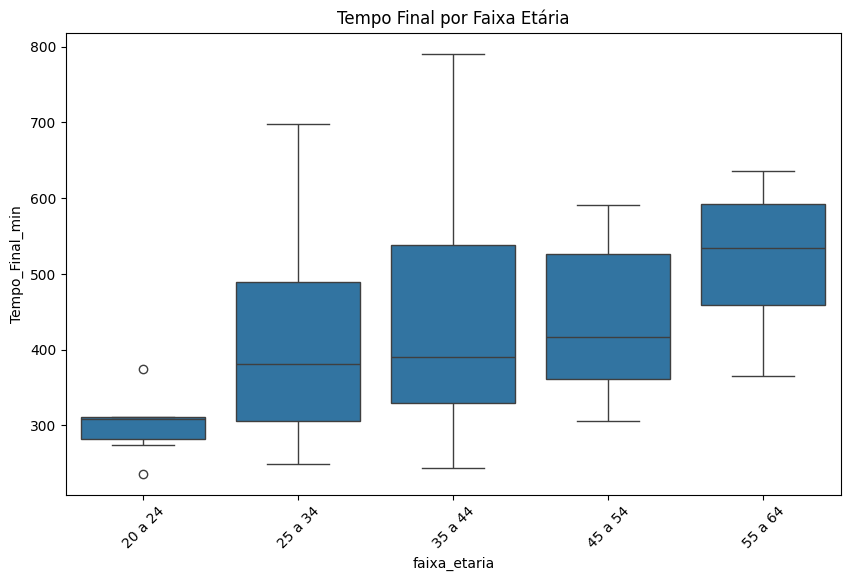

In [19]:
# Faixa Etária vs. Tempo Final
plt.figure(figsize=(10, 6))  # Aumenta o tamanho da figura para caber as labels
# Remove None values before sorting to avoid TypeError
faixa_etaria_order = sorted(
    [x for x in df_agregado_por_atleta["faixa_etaria"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta,
    x="faixa_etaria",
    y="Tempo_Final_min",
    order=faixa_etaria_order,
)
plt.title("Tempo Final por Faixa Etária")
plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para não sobrepor
plt.show()

- Tendência Geral: O gráfico evidencia uma tendência geral de aumento do tempo mediano de conclusão da prova com o avanço da idade. Contudo, essa relação não se mostra perfeitamente linear.

- Melhor Desempenho: A faixa etária de 20 a 24 anos se destaca com o menor tempo mediano e a menor dispersão (caixa mais compacta). Isso sugere que este grupo não só foi o mais rápido, em média, mas também o mais homogêneo em termos de performance.

- Maior Variabilidade: O grupo de 35 a 44 anos apresenta a maior amplitude interquartil (a "altura" da caixa), indicando a maior variabilidade nos tempos de conclusão. Isso pode sugerir que esta faixa contém uma mistura mais heterogênea de atletas, desde os muito experientes até os iniciantes.

- Ponto de Inflexão: Nota-se um ponto , que a cada mudança de faixa etaria, tem uma certa tendencia em aumentar a mediana no tempo total da prova.

- Outlier: É importante destacar a presença de um outlier no grupo de 20 a 24 anos, indicando um atleta com um tempo de prova atipicamente superior ao de seus pares na mesma faixa etária.

Comparando pelo tempo médio por km

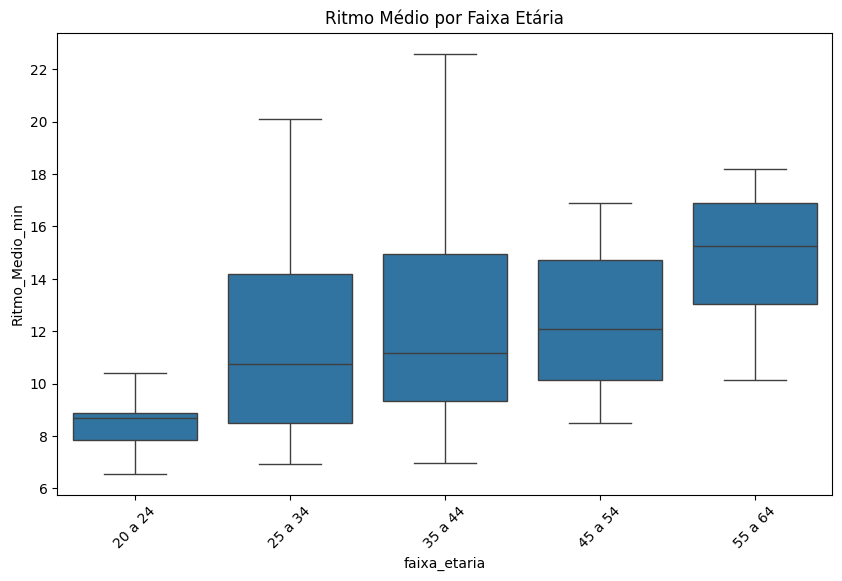

In [20]:
# Faixa Etária vs. Tempo Final
plt.figure(figsize=(10, 6))  # Aumenta o tamanho da figura para caber as labels
# Remove None values before sorting to avoid TypeError
faixa_etaria_order = sorted(
    [x for x in df_agregado_por_atleta["faixa_etaria"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta,
    x="faixa_etaria",
    y="Ritmo_Medio_min",
    order=faixa_etaria_order,
)
plt.title("Ritmo Médio por Faixa Etária")
plt.xticks(rotation=45)  # Rotaciona as labels do eixo x para não sobrepor
plt.show()

##### Teste de Hipótese: Tempo de Prova entre Faixas Etárias

> Pergunta: "Existe uma diferença estatisticamente significativa no tempo médio de prova (Tempo_Final_min) entre as diferentes faixas etárias?"

- **Teste Proposto:** Análise de Variância (ANOVA) ou seu equivalente não paramétrico.
O teste inicial planejado é a **ANOVA de um fator**, ideal para comparar as médias de três ou mais grupos independentes. Contudo, sua validade depende de certos pressupostos (principalmente normalidade dos dados e homogeneidade das variâncias). Caso esses pressupostos não sejam satisfeitos, utilizaremos o teste não paramétrico equivalente, o **Teste de Kruskal-Wallis**, que compara as distribuições dos grupos.

**Passos Detalhados:**

- **Hipóteses:**
> **H₀:** As médias do tempo final de prova são iguais para todas as faixas etárias (μ_faixa1 = μ_faixa2 = ... = μ_faixaK).

> **H₁:** Pelo menos uma das médias do tempo final de prova é diferente das demais.

- **Nível de Significância:** α = 0.05.

Nesta etapa, o objetivo é determinar se existe uma diferença estatisticamente significativa no tempo final de prova entre as diferentes faixas etárias dos competidores.




Teste Normalidade

In [21]:
alfa = 0.05

faixas_etarias_unicas = df_agregado_por_atleta["faixa_etaria"].unique()
grupos_por_idade = [
    df_agregado_por_atleta["Tempo_Final_min"][
        df_agregado_por_atleta["faixa_etaria"] == faixa
    ]
    for faixa in faixas_etarias_unicas
]


print("\nTamanho das amostras por grupo:")
for i, faixa in enumerate(faixas_etarias_unicas):
    print(f"- {faixa}: {len(grupos_por_idade[i])} atletas")


# --- PASSO 2: TESTAR O PRESSUPOSTO DE NORMALIDADE ---
print("\n--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---")
print("Atenção: Teste pouco confiável para grupos com n pequeno.")
todos_normais = True
for i, faixa in enumerate(faixas_etarias_unicas):
    stat, p_valor = stats.shapiro(grupos_por_idade[i])
    print(f"P-valor para o grupo '{faixa}': {p_valor:.4f}")
    if p_valor < alfa:
        todos_normais = False

if todos_normais:
    print("Conclusão: Nenhum grupo rejeitou a hipótese de normalidade.")
else:
    print(
        "Conclusão: Pelo menos um grupo não segue uma distribuição normal. Um teste não-paramétrico é recomendado."
    )


Tamanho das amostras por grupo:
- 45 a 54: 20 atletas
- 25 a 34: 34 atletas
- 20 a 24: 6 atletas
- 35 a 44: 45 atletas
- 55 a 64: 4 atletas

--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---
Atenção: Teste pouco confiável para grupos com n pequeno.
P-valor para o grupo '45 a 54': 0.0828
P-valor para o grupo '25 a 34': 0.0271
P-valor para o grupo '20 a 24': 0.6433
P-valor para o grupo '35 a 44': 0.0121
P-valor para o grupo '55 a 64': 0.8331
Conclusão: Pelo menos um grupo não segue uma distribuição normal. Um teste não-paramétrico é recomendado.


Como o pressuposto de normalidade não foi atendido em todos os grupos (verificado pelo teste de Shapiro-Wilk), o teste não paramétrico de **Kruskal-Wallis** é a escolha apropriada em vez da ANOVA.

- **Ponto de Atenção Metodológico:**
Foi observado que o tamanho da amostra em alguns grupos é pequeno (especificamente, n=6 e n=4). O teste de Kruskal-Wallis, em sua forma padrão, utiliza uma aproximação da distribuição qui-quadrado para calcular o p-valor, um método que perde precisão com amostras pequenas. Portanto, embora o teste padrão seja executado inicialmente, será necessária uma validação posterior com uma técnica mais robusta para garantir a confiabilidade da conclusão.

In [22]:
# --- PASSO 3: TESTAR O PRESSUPOSTO DE HOMOGENEIDADE DAS VARIÂNCIAS ---
print(
    "\n--- Verificando Pressuposto de Homogeneidade das Variâncias (Teste de Levene) ---"
)
stat_levene, p_levene = stats.levene(*grupos_por_idade)
print(f"P-valor do Teste de Levene: {p_levene:.4f}")

if p_levene > alfa:
    print("Conclusão: As variâncias dos grupos são consideradas homogêneas.")
else:
    print("Conclusão: As variâncias dos grupos são consideradas heterogêneas.")


# --- PASSO 4: ESCOLHER E EXECUTAR O TESTE APROPRIADO ---
print("\n--- Executando o Teste de Hipóteses Principal ---")

print("Escolha: Teste de Kruskal-Wallis (não-paramétrico).")
stat_final, p_final = stats.kruskal(*grupos_por_idade)
nome_teste = "Kruskal-Wallis"

print("\n--- Resultados do Teste Principal ---")
print(f"Teste Realizado: {nome_teste}")
print(f"Estatística do teste: {stat_final:.4f}")
print(f"P-valor final: {p_final:.4f}")


--- Verificando Pressuposto de Homogeneidade das Variâncias (Teste de Levene) ---
P-valor do Teste de Levene: 0.2048
Conclusão: As variâncias dos grupos são consideradas homogêneas.

--- Executando o Teste de Hipóteses Principal ---
Escolha: Teste de Kruskal-Wallis (não-paramétrico).

--- Resultados do Teste Principal ---
Teste Realizado: Kruskal-Wallis
Estatística do teste: 11.5814
P-valor final: 0.0208


O resultado do teste de Kruskal-Wallis padrão indicou um p-valor de **0.0208**, o que sugere uma diferença estatisticamente significativa entre os grupos.

**No entanto**, conforme mencionado anteriormente, este p-valor é baseado em uma aproximação que pode ser imprecisa devido à presença de grupos com poucas amostras (n < 5). Para garantir a robustez de nossa conclusão e confirmar se este resultado se mantém, realizaremos a seguir um **Teste de Permutação**.

Este método não depende de aproximações teóricas e irá calcular um p-valor empírico, baseado na distribuição dos próprios dados, fornecendo um resultado mais confiável para o nosso cenário.

**Referências e Justificativa Metodológica**

A decisão de utilizar um **Teste de Permutação** para validar o resultado do Kruskal-Wallis, em vez de confiar apenas na aproximação qui-quadrado, é fundamentada nas recomendações da literatura estatística para casos com amostras pequenas. As seguintes referências apoiam essa abordagem cuidadosa:

* **Siegel, S., & Castellan, N. J., Jr. (2006). *Estatística não paramétrica para ciências do comportamento* (2ª ed.). Artmed.**
    > Esta obra clássica é uma referência fundamental na área e discute as condições de aplicação dos testes não paramétricos, destacando a necessidade de cautela e o uso de métodos exatos ou de permutação para amostras pequenas, garantindo a validade do p-valor.

* **University of Virginia Library - Getting Started with the Kruskal-Wallis Test**
    > [Link para o artigo](https://library.virginia.edu/data/articles/getting-started-with-the-kruskal-wallis-test)
    >
    > Este guia de uma biblioteca universitária reforça a premissa de que a aproximação qui-quadrado é mais confiável quando cada grupo possui um tamanho de amostra adequado (geralmente n ≥ 5), justificando a busca por alternativas mais precisas em cenários com amostras menores.

* **QuestionPro Blog - Teste Kruskal-Wallis: O que é e quando usá-lo?**
    > [Link para o post](https://www.questionpro.com/blog/pt-br/teste-kruskal-wallis/)
    >
    > Um guia prático que resume as condições de uso do teste e serve como material de consulta rápida para a aplicação do Kruskal-Wallis, mencionando as bases para sua utilização correta.

In [23]:
# EXECUTAR O TESTE DE PERMUTAÇÃO PARA KRUSKAL-WALLIS ---
print("\n--- Executando o Teste de Hipóteses Principal ---")
print(
    "Escolha: Teste de Permutação para Kruskal-Wallis (abordagem robusta para amostras pequenas)."
)


# 1. Definimos a estatística que queremos calcular em cada permutação.
#    Neste caso, é a estatística H do teste de Kruskal-Wallis.
def kruskal_statistic(*args):
    """Calcula a estatística H de Kruskal-Wallis."""
    stat, _ = stats.kruskal(*args)
    return stat


# 2. Executamos o teste de permutação.
#    - 'grupos_por_idade': seus dados, em uma lista de arrays/séries.
#    - 'kruskal_statistic': a função que calcula a estatística de interesse.
#    - 'n_resamples': o número de permutações. 9999 é um valor excelente.
#    - 'random_state': garante que o resultado seja o mesmo se você rodar o código de novo.
res = stats.permutation_test(
    grupos_por_idade,
    kruskal_statistic,
    n_resamples=9999,
    random_state=np.random.default_rng(seed=42),
)

# Extraímos a estatística original e o p-valor da permutação
stat_final = res.statistic
p_final = res.pvalue
nome_teste = "Kruskal-Wallis (via Teste de Permutação)"

print("\n--- Resultados do Teste Principal ---")
print(f"Teste Realizado: {nome_teste}")
print(f"Estatística H original: {stat_final:.4f}")
print(f"P-valor (calculado por permutação): {p_final:.4f}")


--- Executando o Teste de Hipóteses Principal ---
Escolha: Teste de Permutação para Kruskal-Wallis (abordagem robusta para amostras pequenas).

--- Resultados do Teste Principal ---
Teste Realizado: Kruskal-Wallis (via Teste de Permutação)
Estatística H original: 11.5814
P-valor (calculado por permutação): 0.0360


In [24]:
# --- PASSO 5: ANÁLISE POST-HOC (SE O RESULTADO FOR SIGNIFICATIVO) ---
print("\n--- Análise Post-Hoc ---")
if p_final < alfa:
    print(
        f"O p-valor ({p_final:.4f}) é significativo. Realizando teste Post-Hoc para identificar quais grupos são diferentes."
    )

    # O Teste de Dunn é o post-hoc apropriado para Kruskal-Wallis.
    # Usamos 'bonferroni' para um ajuste conservador e seguro das múltiplas comparações.
    dunn_results = sp.posthoc_dunn(
        df_agregado_por_atleta,
        val_col="Tempo_Final_min",
        group_col="faixa_etaria",
        p_adjust="bonferroni",
    )

    print(
        "\nMatriz de p-valores do Teste Post-Hoc de Dunn (com correção de Bonferroni):"
    )
    print(
        "Células com p < 0.05 indicam uma diferença significativa entre o par de grupos."
    )
    print(dunn_results)

else:
    print(
        f"O p-valor ({p_final:.4f}) não é significativo. Não há necessidade de um teste post-hoc."
    )
    print(
        "Não há evidências de uma diferença estatisticamente significativa no tempo de prova entre as diferentes faixas etárias."
    )



--- Análise Post-Hoc ---
O p-valor (0.0360) é significativo. Realizando teste Post-Hoc para identificar quais grupos são diferentes.

Matriz de p-valores do Teste Post-Hoc de Dunn (com correção de Bonferroni):
Células com p < 0.05 indicam uma diferença significativa entre o par de grupos.
          20 a 24   25 a 34   35 a 44   45 a 54   55 a 64
20 a 24  1.000000  0.313633  0.080202  0.042338  0.036381
25 a 34  0.313633  1.000000  1.000000  1.000000  0.804720
35 a 44  0.080202  1.000000  1.000000  1.000000  1.000000
45 a 54  0.042338  1.000000  1.000000  1.000000  1.000000
55 a 64  0.036381  0.804720  1.000000  1.000000  1.000000


**Conclusão Final da Análise**

A análise foi conduzida para investigar se o tempo de conclusão da prova varia entre as diferentes faixas etárias. A seguir, os principais pontos observados e a conclusão final:

1.  **Escolha Metodológica:** Devido à não normalidade dos dados, o teste de Kruskal-Wallis foi selecionado. A presença de grupos com amostras pequenas (n=4 e n=6) exigiu uma validação do p-valor padrão.

2.  **Resultado Robusto:** O **Teste de Permutação** foi aplicado para obter um p-valor mais preciso, resultando em **p = 0.0360**. Este valor, sendo inferior a 0.05, confirma de forma robusta a existência de uma diferença estatisticamente significativa entre os tempos médios de prova das diferentes faixas etárias.

3.  **Identificação das Diferenças (Post-Hoc):** A análise post-hoc com o Teste de Dunn (com correção de Bonferroni) foi utilizada para identificar quais pares de grupos específicos apresentavam diferenças. As comparações significativas foram:
    * O grupo **`20 a 24`** foi significativamente mais rápido que o grupo **`45 a 54`** (p=0.042).
    * O grupo **`20 a 24`** foi também significativamente mais rápido que o grupo **`55 a 64`** (p=0.036).

**Conclusão:**
A análise estatística demonstrou que a idade tem uma influência significativa no tempo de finalização da prova. Especificamente, os atletas mais jovens (`20 a 24 anos`) apresentam tempos de prova que são estatisticamente distintos dos atletas em faixas etárias mais avançadas (`45 a 54 anos` e `55 a 64 anos`). As diferenças de desempenho entre as faixas etárias intermediárias (`25-34`, `35-44`, `45-54`) não foram estatisticamente significativas entre si.

#### Análise por faixa de peso

In [25]:
df_agregado_por_atleta["peso"].value_counts()

peso
65 a 74 kg        34
75 a 84 kg        25
55 a 64 kg        21
54 kg e abaixo    12
Não informado      8
85 a 94 kg         7
95 kg a 104 kg     2
Name: count, dtype: int64

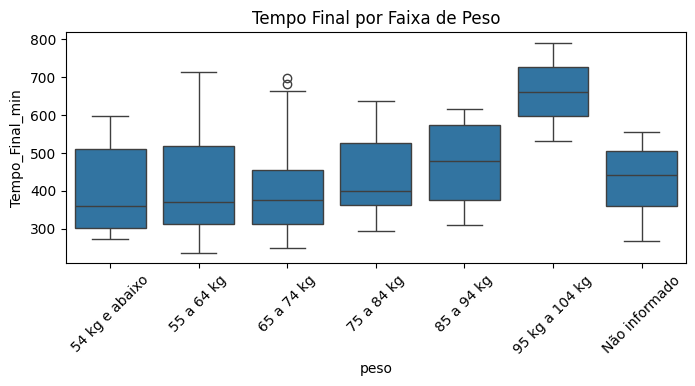

In [26]:
# Peso vs. Tempo Final
plt.figure(figsize=(8, 3))
# Remove None values before sorting to avoid TypeError
peso_order = sorted(
    [x for x in df_agregado_por_atleta["peso"].unique() if x is not None]
)
sns.boxplot(
    data=df_agregado_por_atleta, x="peso", y="Tempo_Final_min", order=peso_order
)
plt.title("Tempo Final por Faixa de Peso")
plt.xticks(rotation=45)
plt.show()

- Tendência Principal: Fica clara a correlação entre o aumento da faixa de peso e o aumento no tempo mediano de prova. Atletas mais leves tenderam a ser mais rápidos.

- Desempenho nos Extremos: O grupo de 54 kg e abaixo obteve os melhores tempos, enquanto a faixa de 95 a 104 kg registrou o desempenho médio mais lento.

- Variabilidade: As faixas de peso intermediárias (55 a 74 kg) mostram a maior dispersão nos resultado, indicando uma grande variação de performance nesses grupos.

- Dados não informados: O grupo "Não informado" apresenta um desempenho mediano, posicionando-se de forma similar às categorias de peso intermediárias.

##### Teste de Hipótese: Tempo de Prova entre Faixas de Peso

Agora, investigaremos se existe uma diferença estatisticamente significativa no tempo de prova entre as diferentes faixas de peso dos atletas.

**Pré-processamento e Estratégia de Análise**

Antes de realizar o teste, foram necessários dois passos de preparação dos dados para garantir a validade e a relevância da análise:

1.  **Exclusão de Dados Ausentes:** Atletas com peso "Não informado" (n=8) foram removidos desta análise específica, pois a variável de interesse (peso) é desconhecida para eles.
2.  **Agrupamento de Categorias:** Foi identificado um grupo com tamanho de amostra muito pequeno ('95 kg a 104 kg', n=2). Para solucionar essa questão, optou-se por agrupar esta categoria com a faixa de peso adjacente ('85 a 94 kg', n=7). A nova categoria, denominada **"85 kg e acima"**, passa a ter um tamanho amostral robusto (n=9) e representa o grupo de atletas mais pesados. Esta abordagem é preferível a um teste de permutação neste contexto, pois o agrupamento é logicamente consistente e simplifica a interpretação dos resultados.

Com os dados devidamente tratados, podemos prosseguir com o teste de hipóteses.

---

> **Pergunta:** "Após o agrupamento, existe uma diferença estatisticamente significativa no tempo de prova entre as diferentes faixas de peso?"

- **Teste Proposto:** ANOVA ou seu equivalente não paramétrico (Kruskal-Wallis), a ser decidido após a verificação dos pressupostos nos novos grupos de dados.

**Passos Detalhados:**

- **Hipóteses:**
> **H₀:** As médias (ou distribuições) do tempo final de prova são iguais para todas as faixas de peso.

> **H₁:** Pelo menos uma das médias (ou distribuições) do tempo final de prova é diferente das demais.

- **Nível de Significância:** α = 0.05.

In [27]:
# --- PASSO 1: PREPARAÇÃO DOS DADOS PARA ANÁLISE DE PESO ---

print("Contagem original das faixas de peso:")
print(df_agregado_por_atleta["peso"].value_counts())

# Criar uma cópia do dataframe para esta análise específica
df_peso = df_agregado_por_atleta.copy()

# 1. Excluir a categoria 'Não informado'
df_peso = df_peso[df_peso["peso"] != "Não informado"]

# 2. Agrupar as duas categorias de maior peso em uma nova categoria '85 kg e acima'
# Usamos .replace() para mapear os valores antigos para o novo
df_peso["peso_agrupada"] = df_peso["peso"].replace(
    {"85 a 94 kg": "85 kg e acima", "95 kg a 104 kg": "85 kg e acima"}
)

print("\nContagem das novas faixas de peso agrupadas:")
print(df_peso["peso_agrupada"].value_counts())

Contagem original das faixas de peso:
peso
65 a 74 kg        34
75 a 84 kg        25
55 a 64 kg        21
54 kg e abaixo    12
Não informado      8
85 a 94 kg         7
95 kg a 104 kg     2
Name: count, dtype: int64

Contagem das novas faixas de peso agrupadas:
peso_agrupada
65 a 74 kg        34
75 a 84 kg        25
55 a 64 kg        21
54 kg e abaixo    12
85 kg e acima      9
Name: count, dtype: int64


Verificando Normalidade

In [28]:
alfa = 0.05

pesos_unicas = df_peso["peso_agrupada"].unique()
grupos_por_peso = [
    df_peso["Tempo_Final_min"][df_peso["peso_agrupada"] == pesos]
    for pesos in pesos_unicas
]


print("\nTamanho das amostras por grupo:")
for i, pesos in enumerate(pesos_unicas):
    print(f"- {pesos}: {len(grupos_por_peso[i])} atletas")


# --- PASSO 2: TESTAR O PRESSUPOSTO DE NORMALIDADE ---
print("\n--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---")
todos_normais = True
for i, pesos in enumerate(pesos_unicas):
    stat, p_valor = stats.shapiro(grupos_por_peso[i])
    print(f"P-valor para o grupo '{pesos}': {p_valor:.4f}")
    if p_valor < alfa:
        todos_normais = False

if todos_normais:
    print("Conclusão: Nenhum grupo rejeitou a hipótese de normalidade.")
else:
    print(
        "Conclusão: Pelo menos um grupo não segue uma distribuição normal. Um teste não-paramétrico é recomendado."
    )


Tamanho das amostras por grupo:
- 75 a 84 kg: 25 atletas
- 65 a 74 kg: 34 atletas
- 55 a 64 kg: 21 atletas
- 85 kg e acima: 9 atletas
- 54 kg e abaixo: 12 atletas

--- Verificando Pressuposto de Normalidade (Teste de Shapiro-Wilk) ---
P-valor para o grupo '75 a 84 kg': 0.0400
P-valor para o grupo '65 a 74 kg': 0.0077
P-valor para o grupo '55 a 64 kg': 0.0882
P-valor para o grupo '85 kg e acima': 0.8493
P-valor para o grupo '54 kg e abaixo': 0.0277
Conclusão: Pelo menos um grupo não segue uma distribuição normal. Um teste não-paramétrico é recomendado.


Como o pressuposto de normalidade não foi atendido em todos os grupos (verificado pelo teste de Shapiro-Wilk), o teste não paramétrico de **Kruskal-Wallis** é a escolha apropriada em vez da ANOVA.

In [29]:
# --- PASSO 3: TESTAR O PRESSUPOSTO DE HOMOGENEIDADE DAS VARIÂNCIAS ---
print(
    "\n--- Verificando Pressuposto de Homogeneidade das Variâncias (Teste de Levene) ---"
)
stat_levene, p_levene = stats.levene(*grupos_por_peso)
print(f"P-valor do Teste de Levene: {p_levene:.4f}")

if p_levene > alfa:
    print("Conclusão: As variâncias dos grupos são consideradas homogêneas.")
else:
    print("Conclusão: As variâncias dos grupos são consideradas heterogêneas.")


print("\n--- Executando o Teste de Hipóteses Principal ---")

print("Teste de Kruskal-Wallis (não-paramétrico).")
stat_final, p_final = stats.kruskal(*grupos_por_peso)
nome_teste = "Kruskal-Wallis"


print("\n--- Resultados do Teste Principal ---")
print(f"Teste Realizado: {nome_teste}")
print(f"Estatística do teste: {stat_final:.4f}")
print(f"P-valor final: {p_final:.4f}")


--- Verificando Pressuposto de Homogeneidade das Variâncias (Teste de Levene) ---
P-valor do Teste de Levene: 0.7324
Conclusão: As variâncias dos grupos são consideradas homogêneas.

--- Executando o Teste de Hipóteses Principal ---
Teste de Kruskal-Wallis (não-paramétrico).

--- Resultados do Teste Principal ---
Teste Realizado: Kruskal-Wallis
Estatística do teste: 6.2538
P-valor final: 0.1810


**Conclusão da Análise por Faixa de Peso**
Após o tratamento dos dados, que incluiu a exclusão de valores não informados e o agrupamento de categorias de peso com poucas amostras, foi realizado o teste de Kruskal-Wallis para comparar os tempos de prova, uma vez que o pressuposto de normalidade não foi atendido por todos os grupos.

> O resultado do teste foi um **p-valor** de **0.1810**.

Como o p-valor obtido (0.1810) é maior que o nível de significância de 0.05, não rejeitamos a hipótese nula. Isso indica que não há evidências estatísticas suficientes para afirmar que existe uma diferença no tempo de conclusão da prova entre as diferentes faixas de peso analisadas.

- **Conclusão Final**:
Com base nos dados desta competição, o peso dos atletas não parece ser um fator que influencia de maneira estatisticamente significativa o tempo final de prova. Diferentemente da faixa etária, as faixas de peso não apresentaram diferenças em suas distribuições de tempo. Portanto, não há necessidade de realizar uma análise post-hoc.

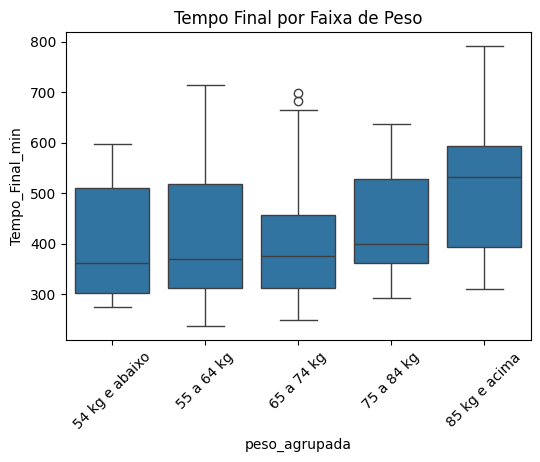

In [30]:
# Peso vs. Tempo Final
plt.figure(figsize=(6, 4))
# Remove None values before sorting to avoid TypeError
peso_order = sorted([x for x in df_peso["peso_agrupada"].unique() if x is not None])
sns.boxplot(data=df_peso, x="peso_agrupada", y="Tempo_Final_min", order=peso_order)
plt.title("Tempo Final por Faixa de Peso")
plt.xticks(rotation=45)
plt.show()

#### Análise da Variabilidade de Ritmo

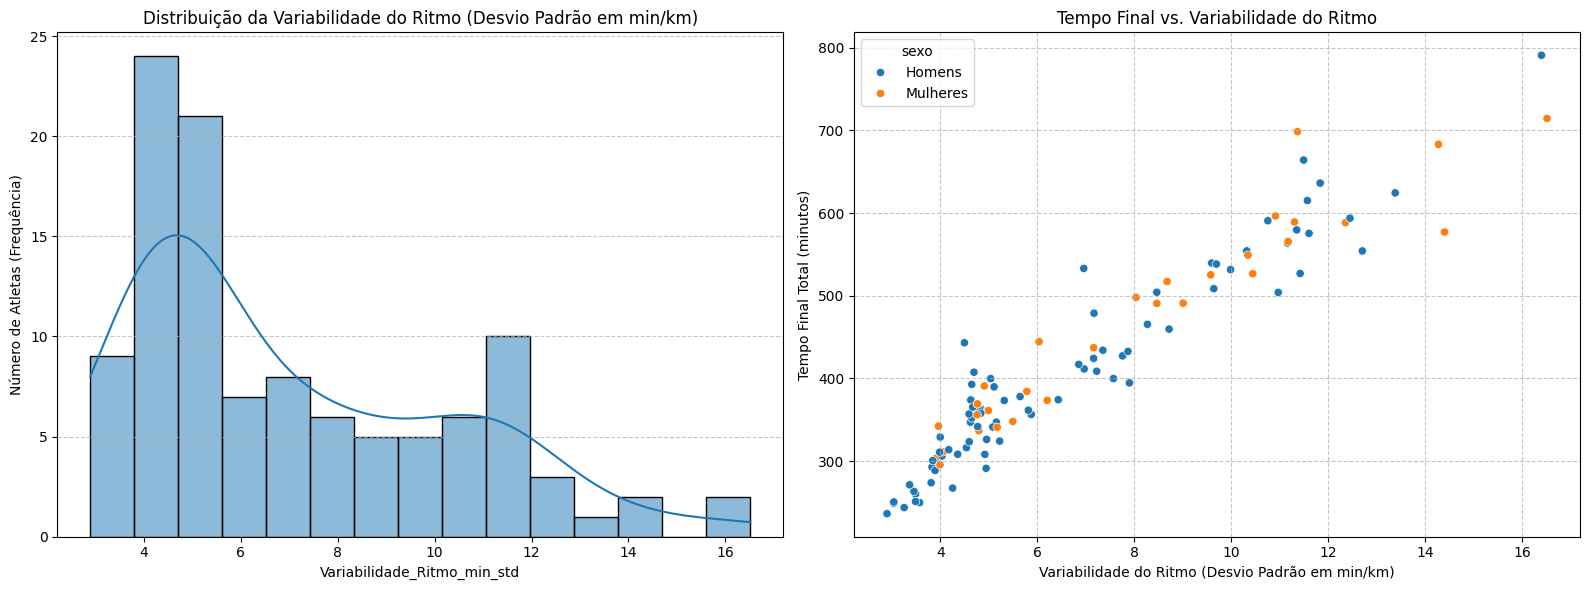

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.histplot(
    data=df_agregado_por_atleta,
    x="Variabilidade_Ritmo_min_std",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição da Variabilidade do Ritmo (Desvio Padrão em min/km)")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_agregado_por_atleta,
    x="Variabilidade_Ritmo_min_std",
    y="Tempo_Final_min",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Variabilidade do Ritmo")
axes[1].set_xlabel("Variabilidade do Ritmo (Desvio Padrão em min/km)")
axes[1].set_ylabel("Tempo Final Total (minutos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

- Correlação Positiva Evidente: O gráfico mostra uma clara e forte correlação positiva entre as duas variáveis. Isso significa que, à medida que a variabilidade do ritmo aumenta (eixo X), o tempo final da prova também tende a aumentar (eixo Y).

- Interpretação Prática: Em termos simples, os atletas que mantiveram um ritmo mais constante e com menos oscilações foram, em geral, os que terminaram a prova mais rápido. A consistência no ritmo parece ser um indicador chave para um bom desempenho.

- Comparativo entre Sexos: Ambos os grupos, homens e mulheres, seguem a mesma tendência linear. Não há uma separação clara dos grupos, indicando que essa relação entre consistência e performance é válida para ambos. No entanto, é possível notar que os pontos com o melhor desempenho combinado (canto inferior esquerdo, com baixo tempo e baixa variabilidade) são, em sua maioria, de atletas masculinos.

- Conclusão: A consistência do ritmo é um fator crucial para o desempenho nesta prova. Atletas menos eficientes em manter um passo estável, provavelmente devido ao terreno ou à estratégia, acabaram com tempos de conclusão significativamente mais altos.

In [32]:
df_agregado_por_atleta[df_agregado_por_atleta["Variabilidade_Ritmo_min_std"] > 16]

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std
31,Evelyn Carboneiro,Mulheres,35 a 44,55 a 64 kg,2023,42866,1224.742857,990.812630,2779.0,-2781.0,714.433333,20.412381,16.513544
94,Robson Ribeiro,Homens,35 a 44,95 kg a 104 kg,2023,47456,1355.885714,983.911814,2779.0,-2781.0,790.933333,22.598095,16.398530


In [33]:
df_filtro_atleta = df_completo.loc[
    df_completo["Nome Atleta"] == "Evelyn Carboneiro",
    ["Nome Atleta", "tempo_por_km_seg", "desnivel_positivo", "desnivel_negativo"],
]
df_filtro_atleta["Minutos"] = df_filtro_atleta["tempo_por_km_seg"] / 60
df_filtro_atleta

,Nome Atleta,tempo_por_km_seg,desnivel_positivo,desnivel_negativo,Minutos
1946,Evelyn Carboneiro,367,13.0,-9.0,6.116667
1947,Evelyn Carboneiro,617,88.0,0.0,10.283333
1948,Evelyn Carboneiro,594,58.0,0.0,9.900000
1949,Evelyn Carboneiro,808,46.0,-81.0,13.466667
1950,Evelyn Carboneiro,1689,41.0,-58.0,28.150000
1951,Evelyn Carboneiro,1717,128.0,-11.0,28.616667
1952,Evelyn Carboneiro,667,228.0,-7.0,11.116667
1953,Evelyn Carboneiro,394,1.0,-243.0,6.566667
1954,Evelyn Carboneiro,558,1.0,-122.0,9.300000
1955,Evelyn Carboneiro,1486,9.0,-69.0,24.766667


In [34]:
df_coef_var = df_agregado_por_atleta.copy()
df_coef_var["coef_var"] = (
    df_coef_var["Variabilidade_Ritmo_min_std"] / df_coef_var["Ritmo_Medio_min"]
)
df_coef_var.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std,coef_var
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.900000,10.080556,4.838189,0.479953
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,533.100000,14.808333,6.959947,0.470002
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,563.766667,15.660185,11.161993,0.712763
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,2022,18496,513.777778,261.647539,2787.0,-2790.0,308.266667,8.562963,4.360792,0.509262
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,2022,14626,417.885714,195.390826,2779.0,-2781.0,243.766667,6.964762,3.256514,0.467570


In [35]:
df_coef_var.loc[
    df_coef_var["Nome Atleta"] == "Evelyn Carboneiro",
    [
        "Nome Atleta",
        "Tempo_Final_min",
        "Ritmo_Medio_min",
        "Variabilidade_Ritmo_min_std",
        "coef_var",
    ],
]

,Nome Atleta,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std,coef_var
31,Evelyn Carboneiro,714.433333,20.412381,16.513544,0.808996


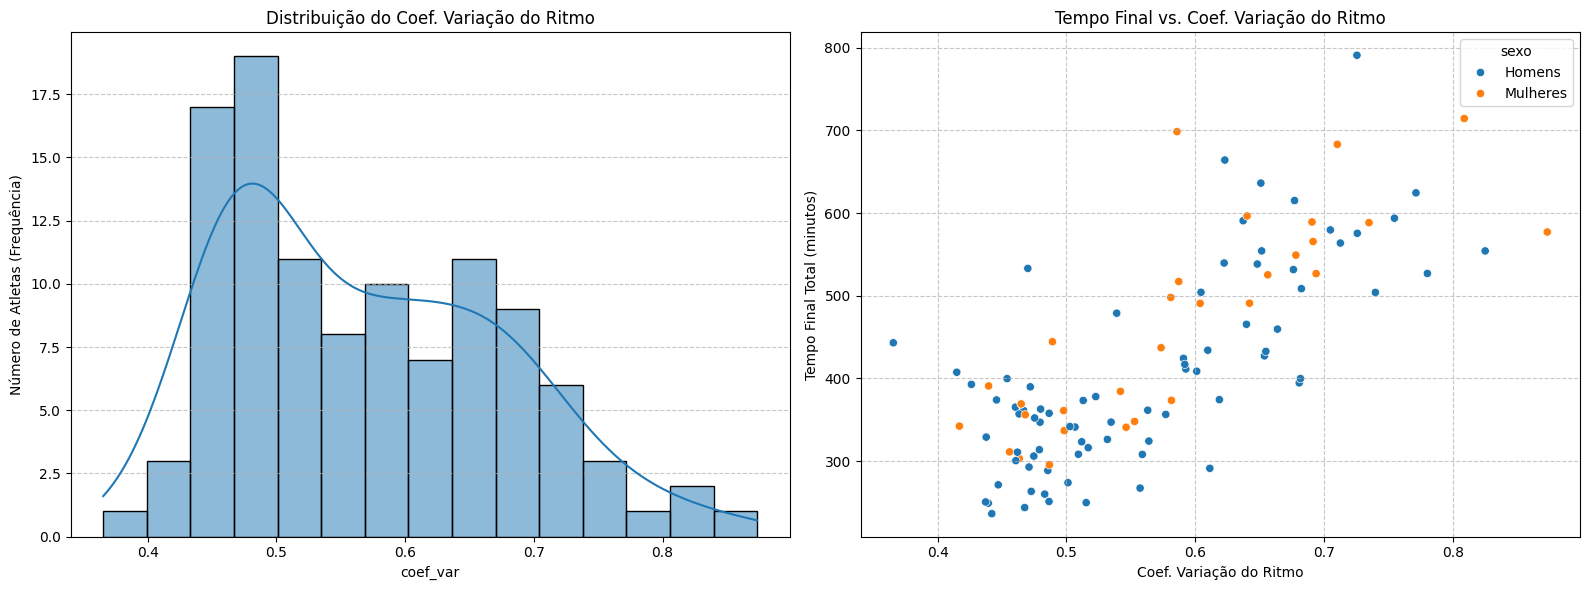

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
sns.histplot(
    data=df_coef_var,
    x="coef_var",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Coef. Variação do Ritmo")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_coef_var,
    x="coef_var",
    y="Tempo_Final_min",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Coef. Variação do Ritmo")
axes[1].set_xlabel("Coef. Variação do Ritmo")
axes[1].set_ylabel("Tempo Final Total (minutos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

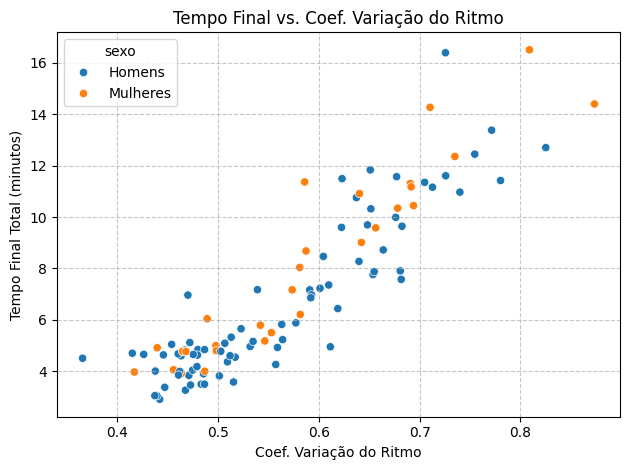

In [37]:
sns.scatterplot(
    data=df_coef_var,
    x="coef_var",
    y="Variabilidade_Ritmo_min_std",
    hue="sexo",  # Direciona o plot para o segundo eixo
)
plt.title("Tempo Final vs. Coef. Variação do Ritmo")
plt.xlabel("Coef. Variação do Ritmo")
plt.ylabel("Tempo Final Total (minutos)")
plt.grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

###### Teste de Associação: Tempo Final vs. Variabilidade do Ritmo

Nesta análise, o foco é determinar se a consistência do ritmo de um atleta tem impacto em seu desempenho final. Especificamente, buscaremos responder à pergunta: "Uma maior variabilidade no ritmo (Variabilidade_Ritmo_min_std) está correlacionada com um tempo final de prova pior?". Nossa expectativa inicial é encontrar uma correlação positiva, onde um ritmo mais inconstante leva a um tempo maior.

Para validar esta hipótese, realizaremos os seguintes passos:

Definição das Hipóteses:

> H0: Não há correlação entre o tempo final e a variabilidade do ritmo.

> H1: Existe correlação entre o tempo final e a variabilidade do ritmo.

- Análise Visual: Geração de um gráfico de dispersão para inspecionar a forma, a direção e a presença de outliers na relação entre as duas variáveis.

- Escolha do Teste: Com base na análise visual e na verificação de pressupostos (como a normalidade dos dados), selecionaremos o teste de correlação mais adequado — Pearson para relações lineares e dados normais, ou Spearman para relações monotônicas ou dados não-normais.

- Interpretação: Analisaremos o coeficiente de correlação (de -1 a 1) e o p-valor para determinar a força, a direção e a significância estatística da associação.

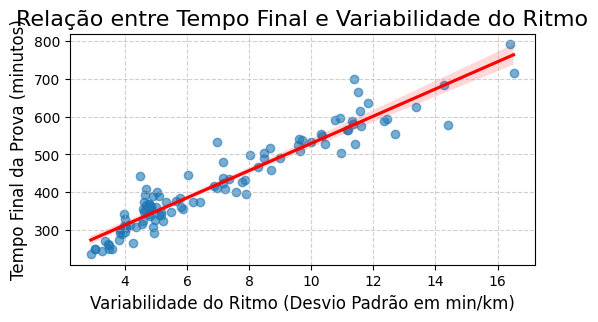

In [38]:
plt.figure(figsize=(6, 3))

sns.regplot(
    x="Variabilidade_Ritmo_min_std",
    y="Tempo_Final_min",
    data=df_agregado_por_atleta,
    scatter_kws={"alpha": 0.6},  # Deixa os pontos um pouco transparentes
    line_kws={"color": "red"},  # Deixa a linha de tendência vermelha
)

plt.title("Relação entre Tempo Final e Variabilidade do Ritmo", fontsize=16)
plt.xlabel("Variabilidade do Ritmo (Desvio Padrão em min/km)", fontsize=12)
plt.ylabel("Tempo Final da Prova (minutos)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

- O grafico gerado mostra uma relação claramente positiva (a linha sobe da esquerda para a direita) e fortemente linear (os pontos se ajustam muito bem à linha de regressão vermelha).

- Interpretação visual: Fica evidente que, à medida que a variabilidade do ritmo de um atleta aumenta, seu tempo final de prova também tende a aumentar. Isso suporta visualmente a sua hipótese.

Verficação da Normalidade das Variaveis

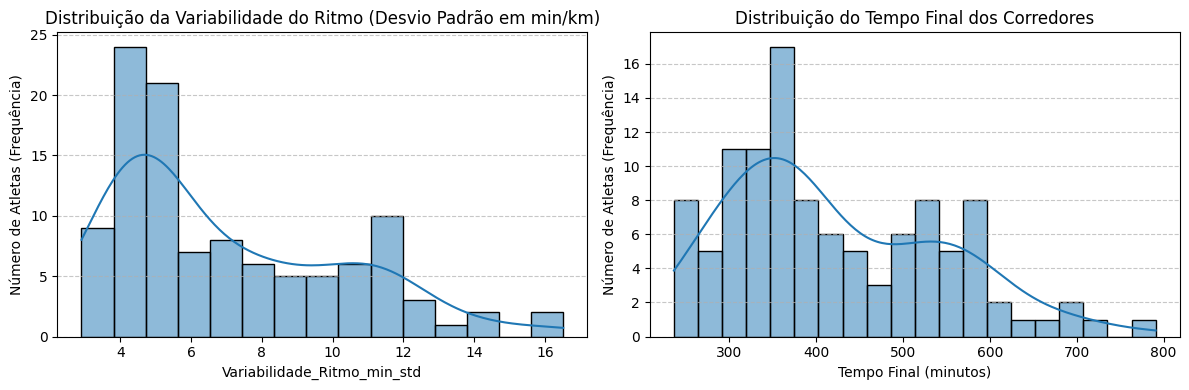

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_agregado_por_atleta,
    x="Variabilidade_Ritmo_min_std",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição da Variabilidade do Ritmo (Desvio Padrão em min/km)")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.histplot(
    data=df_agregado_por_atleta,
    x="Tempo_Final_min",
    kde=True,
    bins=20,
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Distribuição do Tempo Final dos Corredores")
axes[1].set_xlabel("Tempo Final (minutos)")  # Adicionando rótulo ao eixo x
axes[1].set_ylabel("Número de Atletas (Frequência)")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

In [40]:
print("\n--- Verificando Pressuposto de Normalidade das Variáveis ---")

# Variável 1: Tempo Final
stat_tempo, p_shapiro_tempo = stats.shapiro(df_agregado_por_atleta["Tempo_Final_min"])
print(f"P-valor do Teste de Shapiro-Wilk para 'Tempo_Final_min': {p_shapiro_tempo:.4f}")

# Variável 2: Variabilidade do Ritmo
stat_var, p_shapiro_var = stats.shapiro(
    df_agregado_por_atleta["Variabilidade_Ritmo_min_std"]
)
print(
    f"P-valor do Teste de Shapiro-Wilk para 'Variabilidade_Ritmo_min_std': {p_shapiro_var:.4f}"
)

# Avaliação da normalidade
if p_shapiro_tempo > 0.05 and p_shapiro_var > 0.05:
    print("\nConclusão: Ambas as variáveis parecem seguir uma distribuição normal.")
else:
    print(
        "\nConclusão: Pelo menos uma das variáveis NÃO segue uma distribuição normal."
    )



--- Verificando Pressuposto de Normalidade das Variáveis ---
P-valor do Teste de Shapiro-Wilk para 'Tempo_Final_min': 0.0002
P-valor do Teste de Shapiro-Wilk para 'Variabilidade_Ritmo_min_std': 0.0000

Conclusão: Pelo menos uma das variáveis NÃO segue uma distribuição normal.


**Observação Metodológica: Escolha do Coeficiente de Correlação**

A análise de correlação entre o **Tempo Final da Prova** e a **Variabilidade do Ritmo** exige a escolha de um coeficiente apropriado. Embora a Correlação de Pearson (r) seja amplamente utilizada para avaliar a força de uma associação linear, seu uso pressupõe que os dados de ambas as variáveis seguem uma distribuição normal.

Nesta análise, o pressuposto de normalidade foi formalmente testado para cada variável utilizando o Teste de Shapiro-Wilk. Os resultados indicaram uma violação clara deste pressuposto para ambas as variáveis:
* `Tempo_Final_min` (p < 0.001)
* `Variabilidade_Ritmo_min_std` (p < 0.001)

Conforme as diretrizes para o uso apropriado de coeficientes de correlação, quando a suposição de normalidade não é atendida, o uso da Correlação de Pearson pode levar a conclusões inválidas. A literatura estatística, como o guia proposto por Mukaka (2012), recomenda o uso de alternativas não-paramétricas em tais cenários para garantir a validade dos resultados.

Portanto, para assegurar a robustez da análise, optou-se pela **Correlação de Spearman (ρ)**. Este método, por ser baseado em postos (ranks), não exige a normalidade dos dados e é adequado para medir a força de uma relação monotônica (que consistentemente aumenta ou diminui), como a observada no gráfico de dispersão.

**Referência:**
* Mukaka MM. Statistics corner: A guide to appropriate use of correlation coefficient in medical research. Malawi Med J. 2012 Sep;24(3):69-71. PMID: 23638278; PMCID: PMC3576830.

In [41]:
# Extraindo as duas variáveis para o teste
tempo_final = df_agregado_por_atleta["Tempo_Final_min"]
variabilidade_ritmo = df_agregado_por_atleta["Variabilidade_Ritmo_min_std"]

# Calculando a Correlação de Spearman
coeficiente_rho, p_valor = stats.spearmanr(tempo_final, variabilidade_ritmo)

print("--- Resultados do Teste de Correlação de Spearman ---")
print(f"Coeficiente de Correlação de Spearman (rho): {coeficiente_rho:.4f}")
print(f"P-valor: {p_valor}")

# --- Interpretação dos Resultados ---
print("\n--- Interpretação ---")
# Interpretando a força da correlação
if abs(coeficiente_rho) >= 0.8:
    forca = "muito forte"
elif abs(coeficiente_rho) >= 0.6:
    forca = "forte"
elif abs(coeficiente_rho) >= 0.4:
    forca = "moderada"
else:
    forca = "fraca"

# Interpretando a direção
if coeficiente_rho > 0:
    direcao = "positiva"
else:
    direcao = "negativa"

print(f"O resultado mostra uma correlação {direcao} e {forca} entre as variáveis.")

# Interpretando a significância estatística
alfa = 0.05
if p_valor < alfa:
    print(
        f"Como o p-valor ({p_valor:.4g}) é menor que {alfa}, a correlação é estatisticamente significativa."
    )
    print("Rejeitamos a hipótese nula de que não há associação entre as variáveis.")
else:
    print(
        f"Como o p-valor ({p_valor:.4g}) é maior que {alfa}, a correlação NÃO é estatisticamente significativa."
    )
    print("Não podemos rejeitar a hipótese nula.")

--- Resultados do Teste de Correlação de Spearman ---
Coeficiente de Correlação de Spearman (rho): 0.9388
P-valor: 2.4385592785121793e-51

--- Interpretação ---
O resultado mostra uma correlação positiva e muito forte entre as variáveis.
Como o p-valor (2.439e-51) é menor que 0.05, a correlação é estatisticamente significativa.
Rejeitamos a hipótese nula de que não há associação entre as variáveis.


**Conclusão Final: Correlação entre Tempo e Variabilidade de Ritmo**

A análise de correlação foi realizada para investigar a associação entre o tempo final de prova de um atleta (`Tempo_Final_min`) e a sua consistência de ritmo (`Variabilidade_Ritmo_min_std`). Com base nos resultados, podemos concluir que:

* **Força e Direção da Relação:** O teste de Correlação de Spearman revelou um coeficiente **(ρ) de 0.94**. Este valor indica uma **correlação positiva muito forte** entre as duas variáveis.

* **Significância Estatística:** O p-valor obtido foi extremamente baixo (p ≈ 2.44 x 10⁻⁵¹), muito inferior ao nível de significância de 0.05. Isso nos permite **rejeitar a hipótese nula** com grande confiança, confirmando que a correlação observada não se deve ao acaso.

* **Interpretação Prática:** A forte correlação positiva responde diretamente à pergunta de pesquisa. Existe uma associação estatisticamente significativa onde uma **maior variabilidade no ritmo está associada a um tempo final de prova pior (maior)**. Em outras palavras, os atletas que mantiveram um ritmo mais constante ao longo da corrida tenderam a obter melhores tempos, enquanto aqueles cujo ritmo oscilou mais tiveram um desempenho inferior. Este achado sugere que a consistência é um fator crucial para o bom desempenho nesta prova de corrida de montanha.

### Analisando Partes da Prova

Vamos analisar o tempo médio entre primeira metade e segunda metade da prova.

- (Split Positivo): Significa que o ritmo na segunda metade foi mais alto (mais lento)
- (Split Negativo): Seria o caso de um atleta que correu a segunda metade mais rápido que a primeira.

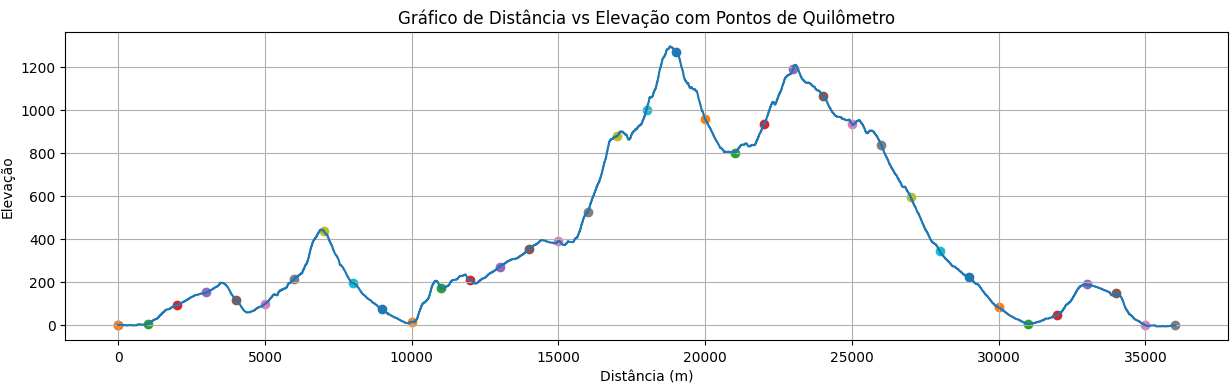

In [42]:
df_metade = df_completo.copy()
df_metade["Metade_Prova"] = "Primeira Metade"
df_metade.loc[df_metade["km_prova"] > 18.0, "Metade_Prova"] = "Segunda Metade"
df_metade.head(5)

,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo,Metade_Prova
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0,Primeira Metade
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0,Primeira Metade
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0,Primeira Metade
3,André Mapa,Homens,35 a 44,Não informado,2023,4.0,363,2023,46.0,-81.0,Primeira Metade
4,André Mapa,Homens,35 a 44,Não informado,2023,5.0,357,2023,41.0,-58.0,Primeira Metade


In [43]:
df_kms = (
    df_metade[["km_prova", "desnivel_positivo", "desnivel_negativo", "Metade_Prova"]]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_kms.head()

,km_prova,desnivel_positivo,desnivel_negativo,Metade_Prova
0,1.0,13.0,-9.0,Primeira Metade
1,2.0,88.0,0.0,Primeira Metade
2,3.0,58.0,0.0,Primeira Metade
3,4.0,46.0,-81.0,Primeira Metade
4,5.0,41.0,-58.0,Primeira Metade


In [44]:
estatisticas_describe = ["sum", "mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_kms.groupby("Metade_Prova")
    .agg(
        {
            "desnivel_positivo": estatisticas_describe,
            "desnivel_negativo": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Parte da Prova ---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Parte da Prova ---
                                      sum    mean    std    min  median    max
Metade_Prova                                                                  
Primeira Metade desnivel_negativo  -767.0  -42.61  60.04 -243.0   -22.0    0.0
                desnivel_positivo  1768.0   98.22  92.83    1.0    73.5  354.0
Segunda Metade  desnivel_negativo -2023.0 -112.39  96.21 -329.0  -129.0   -1.0
                desnivel_positivo  1019.0   56.61  94.61    0.0     9.5  299.0


C:\Users\Home\AppData\Local\Temp\ipykernel_4648\4073048671.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


Primeira Metade: A Fase de "Conquista"
Ganho de Elevação Total (sum): Você sobe 1768 metros.

Perfil Predominante: É majoritariamente subida. O ganho de elevação (+1768m) é mais que o dobro da perda (-767m).

Dificuldade Média (mean/median): Um quilômetro típico tem uma subida brutal. A média de ganho é de 98.2m por km, e a mediana é de 73.5m, indicando subidas constantes e íngremes.

Pico de Dificuldade (max): Existe pelo menos um quilômetro com 354 metros de subida, uma verdadeira "parede".

Segunda Metade: A Fase de "Descida e Velocidade"
Perda de Elevação Total (sum): Você desce -2023 metros.

Perfil Predominante: É majoritariamente descida. A perda de elevação (-2023m) é o dobro do ganho (+1019m).

Dificuldade Média (mean/median): Um quilômetro típico é quase plano. A mediana de ganho de apenas 9.5m revela que a maioria dos quilômetros tem pouca ou nenhuma subida, permitindo um ritmo muito mais rápido.

Pico de Dificuldade (max): Ainda existem subidas duras (máximo de 299m), mas são mais pontuais e menos frequentes que na primeira metade.

Resumo Comparativo Final
Balanço (Subida vs. Descida):

Primeira Metade: Saldo positivo de +1001 metros (muito mais sobe do que desce).

Segunda Metade: Saldo negativo de -1004 metros (muito mais desce do que sobe).

Esses números provam que a estratégia correta é ser extremamente conservador no início, pois a maior parte do esforço de subida está concentrada na primeira metade, enquanto a segunda metade oferece um terreno muito mais favorável para correr.

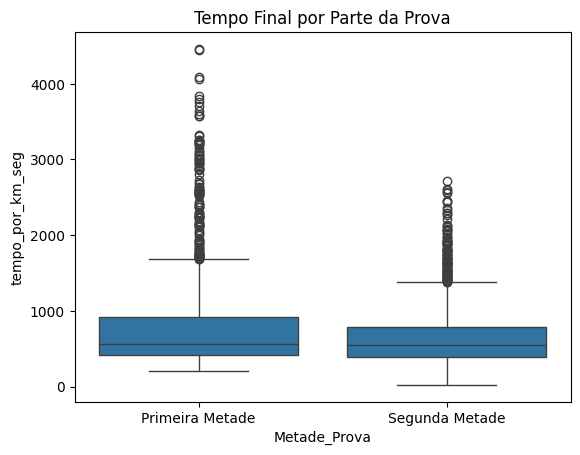

In [45]:
sns.boxplot(data=df_metade, x="Metade_Prova", y="tempo_por_km_seg")
plt.title("Tempo Final por Parte da Prova")
plt.show()

In [46]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_metade.groupby("Metade_Prova")
    .agg({"tempo_por_km_seg": estatisticas_describe})
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Parte da Prova ---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Parte da Prova ---
                                    mean     std  min  median   max
Metade_Prova                                                       
Primeira Metade tempo_por_km_seg  773.61  591.85  200   565.0  4463
Segunda Metade  tempo_por_km_seg  647.59  379.41   23   546.5  2722


C:\Users\Home\AppData\Local\Temp\ipykernel_4648\3022996380.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


- Primeira Metade (Com mais subidas):

Ritmo mais lento e variado: A grande quantidade de subidas força os atletas a desacelerar, o que explica os tempos mais altos e a maior variação de performance.

Quilômetros mais difíceis: Os tempos extremamente lentos (outliers) confirmam que as subidas mais brutais estão nesta parte.

- Segunda Metade (Com menos subidas):

Ritmo mais rápido e consistente: Com um terreno mais favorável, os atletas conseguem impor um ritmo mais forte e constante.

Prova de perfil assimétrico: O gráfico não mostra que os atletas estão menos cansados, mas sim que a maior dificuldade da prova está concentrada no início.

In [47]:
ritmo_por_metade = df_metade.groupby(["Nome Atleta", "Metade_Prova"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)
comparativo_splits = ritmo_por_metade.unstack()
multi_level_columns = comparativo_splits.columns
novos_nomes_colunas = [
    f"Ritmo_Medio_{metade.replace(' ', '_')}"
    if metrica == "tempo_por_km_seg"
    else f"Tempo_Total_{metade.replace(' ', '_')}"
    for metrica, metade in multi_level_columns
]

# 3. Atribua os novos nomes ao seu DataFrame
comparativo_splits_flat = comparativo_splits.copy()  # Copia para não alterar o original
comparativo_splits_flat.columns = novos_nomes_colunas

colunas_em_segundos = [
    "Ritmo_Medio_Primeira_Metade",
    "Ritmo_Medio_Segunda_Metade",
    "Tempo_Total_Primeira_Metade",
    "Tempo_Total_Segunda_Metade",
]
for coluna in colunas_em_segundos:
    # 3. Defina o nome da nova coluna, adicionando '_min' ao final
    nova_coluna_min = coluna + "_min"

    # 4. Crie a nova coluna, fazendo a conversão (dividir por 60) e arredondando (round(2))
    comparativo_splits_flat[nova_coluna_min] = (
        comparativo_splits_flat[coluna] / 60
    ).round(2)


comparativo_splits_flat["Diferenca_Media_Seg_Menos_Pri"] = (
    comparativo_splits_flat["Ritmo_Medio_Segunda_Metade_min"]
    - comparativo_splits_flat["Ritmo_Medio_Primeira_Metade_min"]
).round(2)
comparativo_splits_flat["Diferenca_total_Seg_Menos_Pri"] = (
    comparativo_splits_flat["Tempo_Total_Segunda_Metade_min"]
    - comparativo_splits_flat["Tempo_Total_Primeira_Metade_min"]
).round(2)
comparativo_splits_flat.head(5)

,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri
Nome Atleta,,,,,,,,,,
ALFREDO GUIMARAES,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.10,-37.76
Albert Melo,942.944444,834.055556,16973,15013,15.72,13.90,282.88,250.22,-1.82,-32.66
Alessandro Sousa(allê),945.388889,933.833333,17017,16809,15.76,15.56,283.62,280.15,-0.20,-3.47
Alex Junior Aj,598.944444,428.611111,10781,7715,9.98,7.14,179.68,128.58,-2.84,-51.10
Alexandre Santiago,467.722222,365.117647,8419,6207,7.80,6.09,140.32,103.45,-1.71,-36.87


In [48]:
# Vamos unir as duas tabelas
df_final_completo = pd.merge(
    left=df_agregado_por_atleta,  # A tabela principal, da esquerda
    right=comparativo_splits_flat,  # A tabela com os splits, da direita
    left_on="Nome Atleta",  # A chave na tabela da esquerda é a COLUNA 'Nome Atleta'
    right_index=True,  # A chave na tabela da direita é o ÍNDICE (que também é o nome do atleta)
    how="left",  # 'how=left' garante que todos os atletas da tabela principal sejam mantidos
)

df_final_completo.head()
df_final_completo.to_csv("Dados/df_agregado_por_atleta.csv", sep=";")

In [49]:
df_final_completo.head(3)

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.900000,10.080556,4.838189,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.10,-37.76
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,533.100000,14.808333,6.959947,942.944444,834.055556,16973,15013,15.72,13.90,282.88,250.22,-1.82,-32.66
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,563.766667,15.660185,11.161993,945.388889,933.833333,17017,16809,15.76,15.56,283.62,280.15,-0.20,-3.47


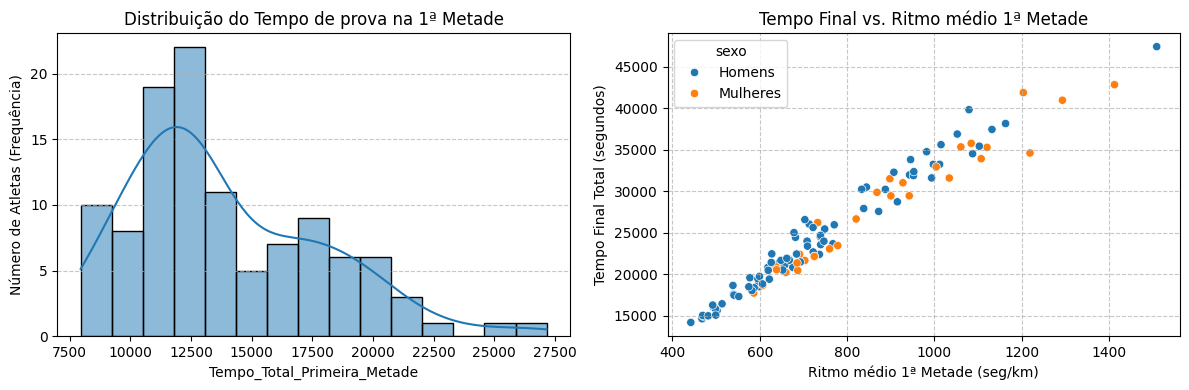

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_completo,
    x="Tempo_Total_Primeira_Metade",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Tempo de prova na 1ª Metade")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_completo,
    x="Ritmo_Medio_Primeira_Metade",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Ritmo médio 1ª Metade")
axes[1].set_xlabel("Ritmo médio 1ª Metade (seg/km)")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

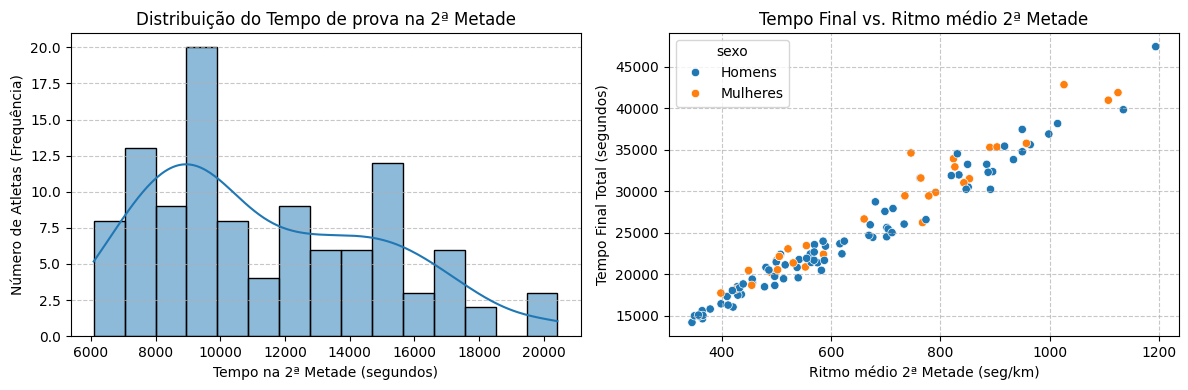

In [51]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(
    data=df_final_completo,
    x="Tempo_Total_Segunda_Metade",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Tempo de prova na 2ª Metade")
axes[0].set_xlabel("Tempo na 2ª Metade (segundos)")  # Adicionando rótulo ao eixo x
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


sns.scatterplot(
    data=df_final_completo,
    x="Ritmo_Medio_Segunda_Metade",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Ritmo médio 2ª Metade")
axes[1].set_xlabel("Ritmo médio 2ª Metade (seg/km)")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

- **Gráfico da 1ª Metade (Subidas)**: Os pontos parecem formar uma linha mais coesa e estreita. A relação parece muito forte e direta. A dispersão dos pontos em torno de uma linha de tendência imaginária é relativamente pequena.

- **Gráfico da 2ª Metade (Descidas)**: Os pontos ainda seguem uma tendência linear, mas parecem estar um pouco mais espalhados. A "nuvem" de pontos é um pouco mais larga.

Após estabelecermos a dinâmica de 'split negativo' da prova, onde a segunda metade é consistentemente mais rápida devido à sua altimetria favorável, uma nova questão emerge: 

> **Qual dos dois segmentos da corrida é mais decisivo para o resultado final de um atleta?**

Em outras palavras, o desempenho na primeira metade, marcada pelas subidas e pelo maior desgaste, é um indicador mais forte do tempo final? Ou a performance na segunda metade, que exige técnica e a capacidade de capitalizar nas descidas, tem uma influência maior? A análise a seguir busca quantificar a força da relação entre o ritmo de cada metade e o tempo total de prova para determinar qual fase é mais preditiva do sucesso.

-  O "Porquê" por Trás da Hipótese
Isso faz total sentido no contexto de uma prova de montanha:

*A 1ª Metade (subidas) funciona como um "filtro" de condicionamento físico. Um atleta que não tem um bom preparo físico registrará um tempo muito alto aqui, e será praticamente impossível compensar essa diferença, não importa quão bem ele desça. O desempenho nesta fase estabelece uma "base" sólida para o tempo final.*

*A 2ª Metade (descidas) introduz outras variáveis, como habilidade técnica, coragem para arriscar e o nível de fadiga acumulado. Um atleta pode ser muito forte na subida, mas um descensor cauteloso, ou vice-versa. Isso cria uma variabilidade maior, enfraquecendo ligeiramente a correlação direta com o tempo final.*

**Vamos fazer a correlação de Pearson para medir essa relação e depois comparar se há diferença significativa entre os valores**

In [52]:
correlacoes = df_final_completo[
    ["Tempo_Final_seg", "Ritmo_Medio_Primeira_Metade", "Ritmo_Medio_Segunda_Metade"]
].corr()

print(correlacoes)

                             Tempo_Final_seg  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade
Tempo_Final_seg                     1.000000                     0.978312                    0.977793
Ritmo_Medio_Primeira_Metade         0.978312                     1.000000                    0.919045
Ritmo_Medio_Segunda_Metade          0.977793                     0.919045                    1.000000


- A análise mostra que tanto o ritmo na primeira metade quanto na segunda são preditores excepcionalmente fortes do tempo final, com correlações quase perfeitas. Embora a primeira metade tenha uma correlação marginalmente maior, a diferença é tão trivial que não é estatisticamente significativa. Para todos os efeitos práticos, você pode concluir que o desempenho em ambas as metades da prova é igualmente crucial e determinante para o resultado final do atleta.

- **Ponto de Atenção**: Existe uma correlação alta entre duas varáiveis que podem vir a ser usadas numa futura modelagem.

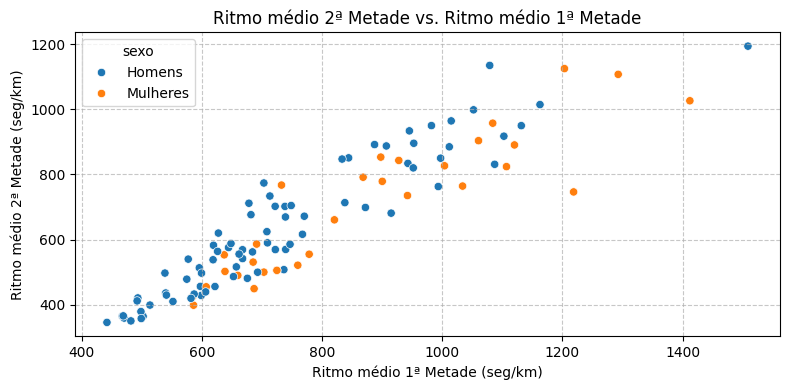

In [53]:
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=df_final_completo,
    x="Ritmo_Medio_Primeira_Metade",
    y="Ritmo_Medio_Segunda_Metade",
    hue="sexo",
)
plt.title("Ritmo médio 2ª Metade vs. Ritmo médio 1ª Metade")
plt.ylabel("Ritmo médio 2ª Metade (seg/km)")
plt.xlabel("Ritmo médio 1ª Metade (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

##### Análise do ritmo médio por parte da prova

In [54]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_completo.groupby("sexo").agg(
    {
        "Ritmo_Medio_Primeira_Metade": estatisticas_describe,
        "Ritmo_Medio_Segunda_Metade": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Partes da prova e sexo ---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Partes da prova e sexo ---
         Ritmo_Medio_Primeira_Metade                                  Ritmo_Medio_Segunda_Metade                                 
                                mean     std     min  median      max                       mean     std     min  median      max
sexo                                                                                                                             
Homens                        733.70  205.20  442.06  683.00  1508.89                     630.23  205.83  345.94  579.14  1193.88
Mulheres                      874.04  227.69  584.89  820.61  1412.22                     696.23  208.43  398.78  735.29  1124.94


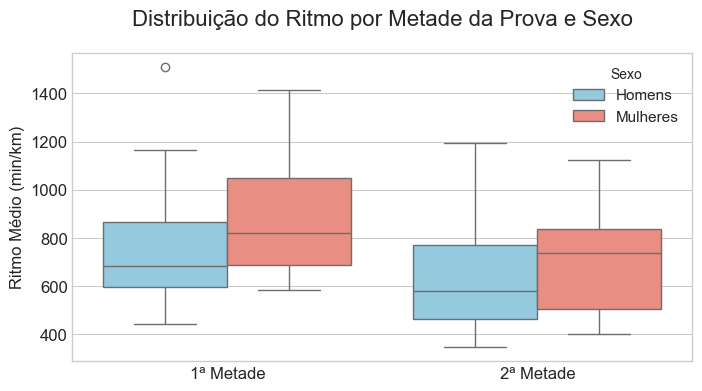

In [55]:
df_melted = pd.melt(
    df_final_completo,
    id_vars=["sexo"],
    value_vars=["Ritmo_Medio_Primeira_Metade", "Ritmo_Medio_Segunda_Metade"],
    var_name="Metade da Prova",
    value_name="Ritmo Médio (min/km)",
)

# Opcional: Renomear os valores para ficarem mais bonitos no gráfico
df_melted["Metade da Prova"] = df_melted["Metade da Prova"].replace(
    {
        "Ritmo_Medio_Primeira_Metade": "1ª Metade",
        "Ritmo_Medio_Segunda_Metade": "2ª Metade",
    }
)


# --- Passo 3: Criar o gráfico boxplot ---
plt.style.use("seaborn-v0_8-whitegrid")  # Estilo do gráfico
plt.figure(figsize=(8, 4))  # Tamanho do gráfico

sns.boxplot(
    data=df_melted,
    x="Metade da Prova",
    y="Ritmo Médio (min/km)",
    hue="sexo",
    palette={"Homens": "skyblue", "Mulheres": "salmon"},  # Cores personalizadas
)

# Adicionando Títulos e Rótulos
plt.title("Distribuição do Ritmo por Metade da Prova e Sexo", fontsize=16, pad=20)
plt.xlabel("")  # Eixo X não precisa de rótulo
plt.ylabel("Ritmo Médio (min/km)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Sexo", fontsize=11)


# Exibir o gráfico
plt.show()

**Análise da 1ª Metade (Subidas):**

- Desempenho Médio: A mediana do ritmo dos homens (linha no meio da caixa azul, ~680 seg/km ou 11:20 min/km) é visivelmente mais baixa (mais rápida) que a das mulheres (~820 seg/km ou 13:40 min/km). Isso indica que, como esperado, o atleta homem mediano foi mais rápido na seção de subida.

- Variabilidade: A caixa azul (Homens) é mais "curta" que a caixa vermelha (Mulheres). Isso significa que a performance do grupo masculino foi mais homogênea; a diferença de ritmo entre os 25% mais rápidos e os 25% mais lentos do "miolo" do grupo é menor. O desempenho das mulheres foi mais heterogêneo, com uma maior dispersão de ritmos.

- Outlier: Existe um atleta homem que foi um outlier, com um ritmo significativamente mais lento que seus pares na primeira metade.

**Análise da 2ª Metade (Descidas):**
- Desempenho Médio: A diferença se mantém. A mediana dos homens (~580 seg/km ou 9:40 min/km) continua mais rápida que a das mulheres (~730 seg/km ou 12:10 min/km).

- Melhora de Performance: É nítido que ambos os grupos foram muito mais rápidos na segunda metade. Todas as caixas da direita estão posicionadas mais abaixo no gráfico do que as da esquerda, confirmando visualmente o forte "split negativo" para todos.

- Variabilidade: A variabilidade para ambos os grupos continua alta, como é comum em trechos de descida que envolvem diferentes níveis de técnica e disposição ao risco. A performance masculina ainda parece um pouco mais concentrada que a feminina.

**Resumo das Conclusões**
- Desempenho Absoluto: Em termos de ritmo absoluto, os homens foram, em média, mais rápidos que as mulheres tanto na seção de subida (1ª metade) quanto na de descida (2ª metade).

- Consistência do Grupo: O grupo masculino apresentou uma performance mais consistente e homogênea na primeira metade da prova, com menor variação de ritmo entre seus atletas em comparação ao grupo feminino.

- Impacto do Percurso: O gráfico confirma de forma inequívoca que o perfil do percurso (subidas e depois descidas) foi o fator dominante na estratégia de ritmo, forçando todos os atletas, independentemente do sexo, a serem significativamente mais rápidos na segunda metade.

- Dinâmica Universal: Embora os homens sejam em média mais rápidos, a dinâmica geral da prova — um início mais lento e um final muito mais rápido — é uma característica universal para ambos os sexos.

##### Analise **Tempo de Prova** x **Diferença** entre primeira e segunda parte da prova.

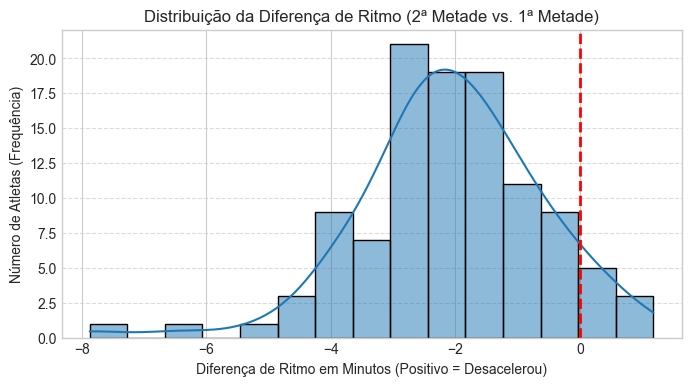

In [56]:
plt.figure(figsize=(8, 4))
sns.histplot(
    data=df_final_completo, x="Diferenca_Media_Seg_Menos_Pri", kde=True, bins=15
)

# Adiciona uma linha vertical em x=0 para ser nossa referência
# À esquerda da linha: atletas que aceleraram (split negativo)
# À direita da linha: atletas que desaceleraram (split positivo)
plt.axvline(x=0, color="red", linestyle="--", linewidth=2)

plt.title("Distribuição da Diferença de Ritmo (2ª Metade vs. 1ª Metade)")
plt.xlabel("Diferença de Ritmo em Minutos (Positivo = Desacelerou)")
plt.ylabel("Número de Atletas (Frequência)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

A análise da distribuição da diferença de ritmo entre a primeira e a segunda metade da prova (gráfico de histograma) revelou um insight fundamental sobre a natureza da competição. Observou-se que a grande maioria dos atletas concluintes apresentou um "split negativo", ou seja, um ritmo médio mais rápido na segunda metade do percurso.

Este padrão, evidenciado pelo pico da distribuição em valores negativos (-2 a -3 min/km), não deve ser interpretado primariamente como uma escolha estratégica deliberada dos atletas. A causa raiz mais provável é o perfil altimétrico do percurso, com uma concentração de subidas e maior dificuldade na primeira metade.

Dessa forma, a variável Diferenca_Seg_Menos_Pri transcende a simples noção de estratégia e se torna um índice de gestão de prova e de eficiência do atleta. Ela quantifica a capacidade de cada indivíduo de administrar seu esforço na seção mais exigente para, então, capitalizar no trecho teoricamente mais favorável. Uma diferença mais negativa pode indicar uma gestão de energia superior. Portanto, esta variável é considerada relevante e será incorporada em análises subsequentes para investigar sua correlação com o desempenho geral e outras métricas dos atletas.

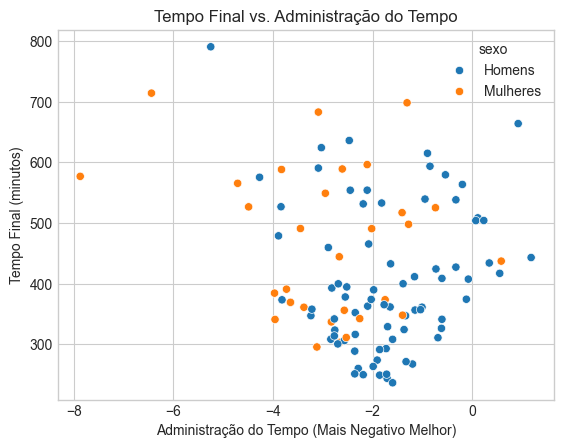

In [57]:
sns.scatterplot(
    data=df_final_completo,
    x="Diferenca_Media_Seg_Menos_Pri",
    y="Tempo_Final_min",
    hue="sexo",
)
plt.title("Tempo Final vs. Administração do Tempo")
plt.xlabel("Administração do Tempo (Mais Negativo Melhor)")
plt.ylabel("Tempo Final (minutos)")
plt.show()

A variável "Administração do Tempo" não tem uma correlação linear simples com o tempo final, mas ela atua como um fator qualificador ou limitante para o alto desempenho.

- Necessário, mas não Suficiente: Para conseguir um tempo final de elite nesta prova, é necessário que o atleta execute a prova dentro de uma faixa ótima de gestão de ritmo (neste caso, entre -4 e -1 min/km de diferença). Estar nessa faixa não garante um bom tempo (você ainda precisa ser um atleta rápido), mas estar fora dela praticamente garantiza que você não terá um tempo de elite.

- Indicador de Quebra: Valores muito negativos (<-5) ou positivos (>0) não são indicativos de uma "estratégia diferente", mas sim de uma provável quebra de ritmo. O atleta com split de -7 provavelmente caminhou muito na primeira metade (gastando tempo) e por isso teve uma grande margem para "acelerar" na segunda. O atleta com split positivo provavelmente se esgotou completamente nas subidas e não conseguiu se recuperar.

#### Criando fator de "Quebra"

- Vimos que a Diferenca_Seg_Menos_Pri é útil, mas uma queda de 60 segundos no ritmo é muito mais significativa para um atleta de elite (que corre a 300 seg/km) do que para um iniciante (que corre a 900 seg/km). Normalizar essa diferença pelo ritmo do próprio atleta nos dá uma medida relativa do cansaço.

In [58]:
df_final_completo["diff_relativa_segunda_primeira_parte"] = (
    (
        df_final_completo["Ritmo_Medio_Segunda_Metade"]
        - df_final_completo["Ritmo_Medio_Primeira_Metade"]
    )
    / df_final_completo["Ritmo_Medio_Primeira_Metade"]
).round(2)
df_final_completo.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.900000,10.080556,4.838189,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.10,-37.76,-0.19
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,533.100000,14.808333,6.959947,942.944444,834.055556,16973,15013,15.72,13.90,282.88,250.22,-1.82,-32.66,-0.12
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,563.766667,15.660185,11.161993,945.388889,933.833333,17017,16809,15.76,15.56,283.62,280.15,-0.20,-3.47,-0.01
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,2022,18496,513.777778,261.647539,2787.0,-2790.0,308.266667,8.562963,4.360792,598.944444,428.611111,10781,7715,9.98,7.14,179.68,128.58,-2.84,-51.10,-0.28
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,2022,14626,417.885714,195.390826,2779.0,-2781.0,243.766667,6.964762,3.256514,467.722222,365.117647,8419,6207,7.80,6.09,140.32,103.45,-1.71,-36.87,-0.22


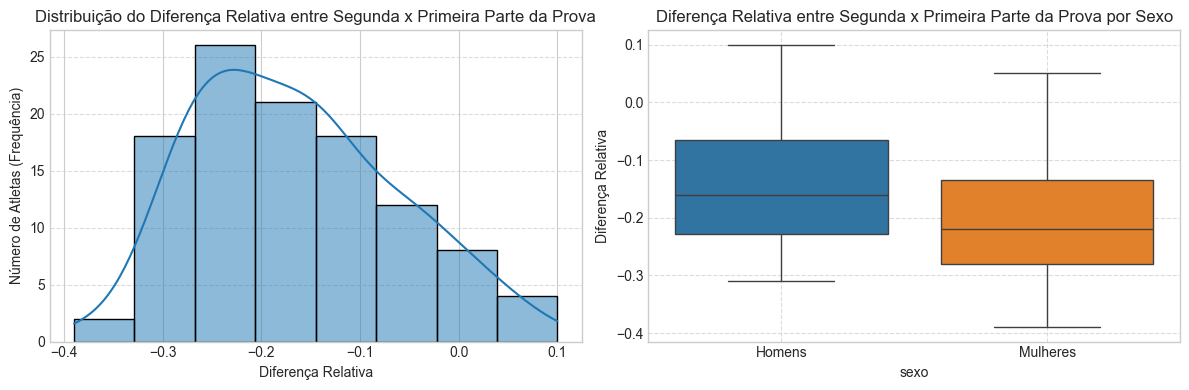

In [59]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(
    data=df_final_completo,
    x="diff_relativa_segunda_primeira_parte",
    kde=True,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title(
    "Distribuição do Diferença Relativa entre Segunda x Primeira Parte da Prova"
)
axes[0].set_xlabel("Diferença Relativa")  # Adicionando rótulo ao eixo x
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)


sns.boxplot(
    data=df_final_completo,
    x="sexo",
    y="diff_relativa_segunda_primeira_parte",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Diferença Relativa entre Segunda x Primeira Parte da Prova por Sexo")
axes[1].set_ylabel("Diferença Relativa")
axes[1].grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

In [60]:
df_final_completo["diff_relativa_segunda_primeira_parte"].describe().round(2)

count    109.00
mean      -0.17
std        0.10
min       -0.39
25%       -0.25
50%       -0.17
75%       -0.09
max        0.10
Name: diff_relativa_segunda_primeira_parte, dtype: float64

**É notável que a grande maioria dos atletas (mais de 75%) conseguiu correr a segunda metade mais rápido.**

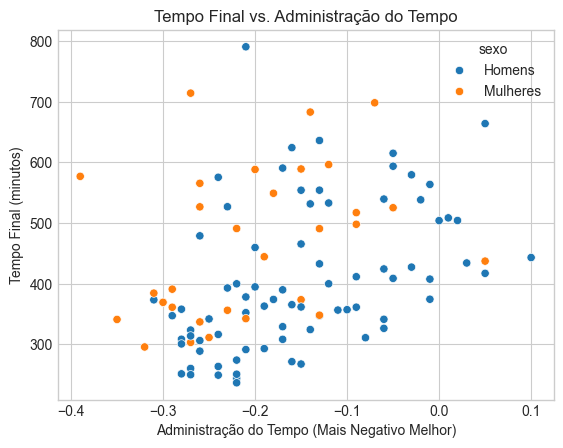

In [61]:
sns.scatterplot(
    data=df_final_completo,
    x="diff_relativa_segunda_primeira_parte",
    y="Tempo_Final_min",
    hue="sexo",
)
plt.title("Tempo Final vs. Administração do Tempo")
plt.xlabel("Administração do Tempo (Mais Negativo Melhor)")
plt.ylabel("Tempo Final (minutos)")
plt.show()

O perfil da prova, com a primeira metade focada em subidas e a segunda em descidas, é o fator que define o desempenho.

- Regra da Prova: Acelerar na segunda metade não é uma estratégia, é uma consequência do percurso. Em média, os atletas foram 17% mais rápidos na segunda metade (média de -0.17), como mostra a distribuição normal no histograma.

- Fator de Sucesso: O gráfico de dispersão confirma que os atletas com os melhores tempos finais foram aqueles que mais conseguiram capitalizar nas descidas da segunda metade, ou seja, tiveram o índice mais negativo.

In [62]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_completo.groupby("sexo").agg(
    {
        "diff_relativa_segunda_primeira_parte": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Fator Quebra ---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Fator Quebra ---
         diff_relativa_segunda_primeira_parte                        
                                         mean  std   min median   max
sexo                                                                 
Homens                                  -0.15  0.1 -0.31  -0.16  0.10
Mulheres                                -0.21  0.1 -0.39  -0.22  0.05


Mesmo compondo apenas 30% da amostra, os dados das mulheres mostram um desempenho relativo superior na dinâmica da prova.

Desempenho Médio: As mulheres foram, em média, mais eficientes na segunda parte da prova. O índice delas foi de -0.21 (-21%), consideravelmente mais negativo que o dos homens, de -0.15 (-15%).

- Consistência: Os homens apresentaram os maiores casos de "quebra", com alguns chegando a ser 10% mais lentos na segunda parte da prova. As mulheres foram mais consistentes, com a maior queda de ritmo sendo de apenas 5%.

- Conclusão Direta: A prova exige a habilidade de subir na primeira metade e descer bem na segunda. A análise sugere que, embora os homens representem 70% dos dados, as mulheres, como grupo, foram relativamente mais eficientes em converter a segunda parte da prova em um ganho de velocidade percentual em relação à sua performance na primeira parte da prova.

**Conclusão**: A prova exige a habilidade de subir na primeira metade e descer bem na segunda. A análise sugere que, embora os homens representem 70% dos dados, as mulheres, como grupo, foram relativamente mais eficientes em converter a seção de descida em um ganho de velocidade percentual em relação à sua performance na subida.

#### Análise Inclinação da Prova

##### Análise Subida vs Descida

In [63]:
df_sobe_desc = df_completo.copy()
df_sobe_desc["Diff_Sob_Desc"] = (
    df_sobe_desc["desnivel_positivo"] + df_sobe_desc["desnivel_negativo"]
)
df_sobe_desc["percent_inclin_subida"] = df_sobe_desc["desnivel_positivo"] / 1000 * 100
df_sobe_desc["percent_inclin_descida"] = df_sobe_desc["desnivel_negativo"] / 1000 * 100
df_sobe_desc["perc_diff"] = (
    df_sobe_desc["desnivel_positivo"] / abs(df_sobe_desc["desnivel_negativo"]) - 1
)
df_sobe_desc.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo,Diff_Sob_Desc,percent_inclin_subida,percent_inclin_descida,perc_diff
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0,4.0,1.3,-0.9,0.444444
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0,88.0,8.8,0.0,inf
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0,58.0,5.8,0.0,inf
3,André Mapa,Homens,35 a 44,Não informado,2023,4.0,363,2023,46.0,-81.0,-35.0,4.6,-8.1,-0.432099
4,André Mapa,Homens,35 a 44,Não informado,2023,5.0,357,2023,41.0,-58.0,-17.0,4.1,-5.8,-0.293103


In [64]:
def Sob_Desc(diff, desnivel_positivo_km, desnivel_negativo_km):
    if desnivel_positivo_km < 20 and desnivel_negativo_km > -20:
        return "PLANO"
    elif diff >= -0.5 and diff <= 0.5:
        return "MISTO"
    elif diff < -0.5:
        return "DESCIDA"
    else:
        return "SUBIDA"


# Aplicando a função ao DataFrame
df_sobe_desc["Sob_Desc"] = df_sobe_desc[
    ["perc_diff", "desnivel_positivo", "desnivel_negativo"]
].apply(lambda x: Sob_Desc(x[0], x[1], x[2]), axis=1)
df_sobe_desc.head(10)

C:\Users\Home\AppData\Local\Temp\ipykernel_4648\3829612325.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ].apply(lambda x: Sob_Desc(x[0], x[1], x[2]), axis=1)


,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo,Diff_Sob_Desc,percent_inclin_subida,percent_inclin_descida,perc_diff,Sob_Desc
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0,4.0,1.3,-0.9,0.444444,PLANO
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0,88.0,8.8,0.0,inf,SUBIDA
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0,58.0,5.8,0.0,inf,SUBIDA
3,André Mapa,Homens,35 a 44,Não informado,2023,4.0,363,2023,46.0,-81.0,-35.0,4.6,-8.1,-0.432099,MISTO
4,André Mapa,Homens,35 a 44,Não informado,2023,5.0,357,2023,41.0,-58.0,-17.0,4.1,-5.8,-0.293103,MISTO
5,André Mapa,Homens,35 a 44,Não informado,2023,6.0,670,2023,128.0,-11.0,117.0,12.8,-1.1,10.636364,SUBIDA
6,André Mapa,Homens,35 a 44,Não informado,2023,7.0,258,2023,228.0,-7.0,221.0,22.8,-0.7,31.571429,SUBIDA
7,André Mapa,Homens,35 a 44,Não informado,2023,8.0,211,2023,1.0,-243.0,-242.0,0.1,-24.3,-0.995885,DESCIDA
8,André Mapa,Homens,35 a 44,Não informado,2023,9.0,338,2023,1.0,-122.0,-121.0,0.1,-12.2,-0.991803,DESCIDA
9,André Mapa,Homens,35 a 44,Não informado,2023,10.0,544,2023,9.0,-69.0,-60.0,0.9,-6.9,-0.869565,DESCIDA


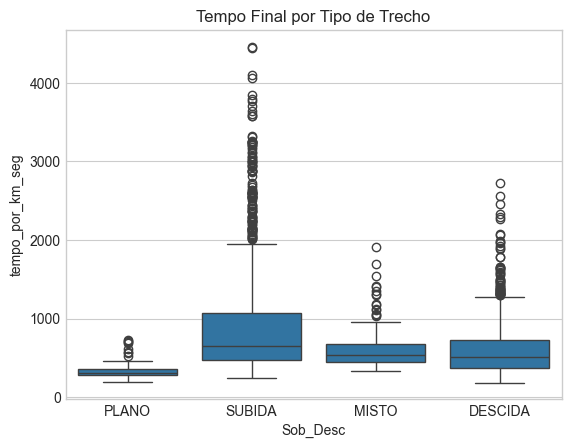

In [65]:
sns.boxplot(
    data=df_sobe_desc[df_sobe_desc["tempo_por_km_seg"] > 180],
    x="Sob_Desc",
    y="tempo_por_km_seg",
)
plt.title("Tempo Final por Tipo de Trecho")
plt.show()

In [66]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_sobe_desc[df_sobe_desc["tempo_por_km_seg"] > 180]
    .groupby("Sob_Desc")
    .agg(
        {
            "tempo_por_km_seg": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Tipo Inclinação ---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Tipo Inclinação ---
                             mean     std  min  median   max
Sob_Desc                                                    
DESCIDA  tempo_por_km_seg  592.08  316.43  183   504.0  2722
MISTO    tempo_por_km_seg  600.45  245.19  331   529.5  1908
PLANO    tempo_por_km_seg  331.29   92.40  188   311.0   724
SUBIDA   tempo_por_km_seg  869.99  613.09  246   652.0  4463


C:\Users\Home\AppData\Local\Temp\ipykernel_4648\557169805.py:12: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


- PLANO

Ritmo mais rápido de todos os trechos.

Maior consistência: Quase todos os atletas correm em um ritmo parecido.

- SUBIDA

Ritmo mais lento de forma disparada.

Maior variação de performance: É o trecho que mais diferencia os atletas. Onde a prova é "ganha" ou "perdida".

- MISTO

Ritmo intermediário, mais rápido que as subidas.

Quebra de ritmo: Terreno ondulado que exige variação constante de esforço.

- DESCIDA

Ritmo mais rápido que subidas, mas mais lento que o plano.

Exige técnica: A variação nos tempos mostra que a dificuldade do terreno e a habilidade do atleta são cruciais.

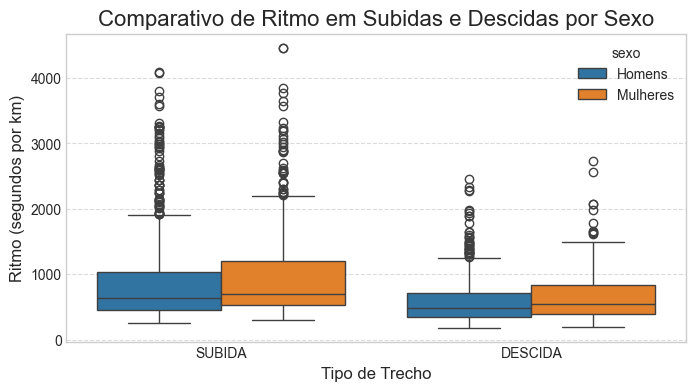

In [67]:
categorias_desejadas = ["SUBIDA", "DESCIDA"]
df_filtrado = df_sobe_desc[
    (df_sobe_desc["Sob_Desc"].isin(categorias_desejadas))
    & (df_sobe_desc["tempo_por_km_seg"] > 180)
]

# 2. Criar o gráfico
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualização
sns.boxplot(
    data=df_filtrado,
    x="Sob_Desc",  # No eixo X, as categorias 'SUBIDA' e 'DESCIDA'
    y="tempo_por_km_seg",  # No eixo Y, o ritmo
    hue="sexo",  # O 'hue' separa os dados por sexo
)

# Adicionar títulos e formatação
plt.title("Comparativo de Ritmo em Subidas e Descidas por Sexo", fontsize=16)
plt.xlabel("Tipo de Trecho", fontsize=12)
plt.ylabel("Ritmo (segundos por km)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [68]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_filtrado.groupby(["sexo", "Sob_Desc"]).agg(
    {
        "tempo_por_km_seg": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Subida/Descida e sexo ---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Subida/Descida e sexo ---
                  tempo_por_km_seg                          
                              mean     std  min median   max
sexo     Sob_Desc                                           
Homens   DESCIDA            573.13  303.74  183  487.0  2453
         SUBIDA             831.87  580.91  246  628.0  4096
Mulheres DESCIDA            639.78  342.05  189  537.0  2722
         SUBIDA             965.91  678.61  293  697.0  4463


**Desempenho Absoluto**: Homens são Mais Rápidos em Ambos os Terrenos

- Tanto na **média** (*mean*) quanto na **mediana** (*median*), os homens apresentam um ritmo (tempo por km) inferior ao das mulheres.

- Na **Subida**: A mediana dos homens foi de 628 seg/km (~10:28 min/km), enquanto a das mulheres foi de 697 seg/km (~11:37 min/km).

- Na **Descida**: A mediana dos homens foi de 487 seg/km (~8:07 min/km), enquanto a das mulheres foi de 537 seg/km (~8:57 min/km).

- **Conclusão**: Em velocidade pura, os homens lideram em ambos os tipos de terreno.

**Variabilidade e Outliers**

- O gráfico mostra uma quantidade enorme de outliers (pontos circulares), especialmente nas subidas. Isso é típico em corridas de montanha, onde trechos específicos podem causar uma grande variação de ritmo (caminhada, dificuldades técnicas, etc.).

- A variabilidade, medida pelo desvio padrão (std), é muito alta para todos os grupos, mas ligeiramente maior para as mulheres, tanto na subida quanto na descida, indicando um grupo com desempenho um pouco mais heterogêneo.

**Conclusão: A Diferença Crucial entre Desempenho Absoluto e Relativo**
A análise do ritmo absoluto, que compara diretamente os segundos por quilômetro, estabelece um fato claro: os homens, como grupo, foram em média mais rápidos que as mulheres tanto nos trechos de subida quanto nos de descida. No entanto, essa visão não conta a história completa da performance e da estratégia na prova.

Para entender a dinâmica de como cada grupo aproveitou os diferentes terrenos, precisamos revisitar a análise de desempenho relativo, que foi o ponto de partida de nosso estudo quando comparamos a *primeira* e a *segunda* metade da prova. Naquela análise inicial, havíamos identificado que as mulheres apresentavam uma melhora percentual de ritmo mais significativa, um insight que agora podemos confirmar com os dados mais precisos de subida e descida.

Para quantificar essa "eficiência na transição" do terreno desfavorável para o favorável, calculamos a melhora relativa no ritmo de cada grupo usando a seguinte fórmula:

> $$ \text{Índice de Aceleração } (\%) = \left( \frac{\text{Ritmo Médio na Descida} - \text{Ritmo Médio na Subida}}{\text{Ritmo Médio na Subida}} \right) \times 100 $$

Aplicando os valores médios que encontramos, os resultados revelam uma nuance fundamental no desempenho:

>> Melhora Relativa dos Homens: (573.13 - 831.87) / 831.87 = -31.1%

>> Melhora Relativa das Mulheres: (639.78 - 965.91) / 965.91 = -33.8%

- Esses números confirmam que, embora não sejam mais rápidas em termos absolutos, as mulheres, como grupo, capitalizaram nas descidas de forma mais eficaz em relação ao seu próprio ritmo de subida. A aceleração relativa delas foi superior à dos homens.

Portanto, a conclusão final é dupla: enquanto os homens foram dominantes em velocidade pura, a análise relativa expõe que as mulheres demonstraram uma maior capacidade de maximizar seu ganho de velocidade nos trechos de descida, validando o padrão que havíamos observado inicialmente e adicionando uma camada mais profunda de entendimento sobre as diferentes estratégias de performance entre os sexos nesta prova.

##### Indice Diferença relativa entre Subida e Descida no Tempo médio

In [69]:
df_sobe_desc.head(3)

,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo,Diff_Sob_Desc,percent_inclin_subida,percent_inclin_descida,perc_diff,Sob_Desc
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0,4.0,1.3,-0.9,0.444444,PLANO
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0,88.0,8.8,0.0,inf,SUBIDA
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0,58.0,5.8,0.0,inf,SUBIDA


In [70]:
ritmo_por_nivel = df_sobe_desc.groupby(["Nome Atleta", "Sob_Desc"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)

# --- PASSO 2: Pivotar a tabela (unstack) ---
# Isso transforma as linhas de 'Sob_Desc' (PLANO, SUBIDA, etc.) em colunas.
# .fillna(0) é importante para atletas que talvez não tenham passado por um tipo de terreno.
comparativo_niveis = ritmo_por_nivel.unstack().fillna(0)


# --- PASSO 3: Achatar e renomear as colunas (mesma lógica de antes) ---
multi_level_columns_nivel = comparativo_niveis.columns
# Adaptamos a lógica para os níveis de inclinação
novos_nomes_colunas_nivel = [
    f"Ritmo_Medio_{nivel}" if metrica == "tempo_por_km_seg" else f"Tempo_Total_{nivel}"
    for metrica, nivel in multi_level_columns_nivel
]
comparativo_niveis.columns = novos_nomes_colunas_nivel


# --- PASSO 4: Converter as novas colunas de segundos para minutos ---
# A lista de colunas é gerada dinamicamente
colunas_em_segundos_nivel = novos_nomes_colunas_nivel

for coluna in colunas_em_segundos_nivel:
    nova_coluna_min = coluna + "_min"
    comparativo_niveis[nova_coluna_min] = (comparativo_niveis[coluna] / 60).round(2)

comparativo_niveis = comparativo_niveis.reset_index()

Juntando as tabelas

In [71]:
df_final_completo.head(1)

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.9,10.080556,4.838189,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.1,-37.76,-0.19


In [72]:
df_final_nivel_inclinacao = pd.merge(
    left=df_final_completo,
    right=comparativo_niveis,
    on="Nome Atleta",
    how="left",
)

# Exibindo o resultado final
print("Tabela final com a análise por nível de inclinação:")
df_final_nivel_inclinacao.head(5)

Tabela final com a análise por nível de inclinação:


,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,Ritmo_Medio_DESCIDA_min,Ritmo_Medio_MISTO_min,Ritmo_Medio_PLANO_min,Ritmo_Medio_SUBIDA_min,Tempo_Total_DESCIDA_min,Tempo_Total_MISTO_min,Tempo_Total_PLANO_min,Tempo_Total_SUBIDA_min
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.900000,10.080556,4.838189,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.10,-37.76,-0.19,522.933333,474.5,335.5,724.117647,7844,949,671,12310,8.72,7.91,5.59,12.07,130.73,15.82,11.18,205.17
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,533.100000,14.808333,6.959947,942.944444,834.055556,16973,15013,15.72,13.90,282.88,250.22,-1.82,-32.66,-0.12,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,13.17,12.37,8.92,17.24,197.48,24.73,17.83,293.05
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,563.766667,15.660185,11.161993,945.388889,933.833333,17017,16809,15.76,15.56,283.62,280.15,-0.20,-3.47,-0.01,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,12.42,10.47,5.52,20.32,186.32,20.93,11.03,345.48
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,2022,18496,513.777778,261.647539,2787.0,-2790.0,308.266667,8.562963,4.360792,598.944444,428.611111,10781,7715,9.98,7.14,179.68,128.58,-2.84,-51.10,-0.28,443.133333,434.0,224.5,619.529412,6647,868,449,10532,7.39,7.23,3.74,10.33,110.78,14.47,7.48,175.53
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,2022,14626,417.885714,195.390826,2779.0,-2781.0,243.766667,6.964762,3.256514,467.722222,365.117647,8419,6207,7.80,6.09,140.32,103.45,-1.71,-36.87,-0.22,366.466667,352.0,267.0,479.882353,5497,704,267,8158,6.11,5.87,4.45,8.00,91.62,11.73,4.45,135.97


Criando Indice que compara:
- *Tempo Médio Subida* x *Tempo Médio Descida*
- *Tempo Médio Subida* x *Tempo Médio Total Prova*
- *Tempo Médio Descida* x *Tempo Médio Total Prova*

In [73]:
df_final_nivel_inclinacao["indice_subida"] = (
    df_final_nivel_inclinacao["Ritmo_Medio_SUBIDA"]
    - df_final_nivel_inclinacao["Ritmo_Medio_seg"]
) / df_final_nivel_inclinacao["Ritmo_Medio_seg"]
df_final_nivel_inclinacao["indice_descida"] = (
    df_final_nivel_inclinacao["Ritmo_Medio_DESCIDA"]
    - df_final_nivel_inclinacao["Ritmo_Medio_seg"]
) / df_final_nivel_inclinacao["Ritmo_Medio_seg"]
df_final_nivel_inclinacao["indice_descida_vs_subida"] = (
    df_final_nivel_inclinacao["Ritmo_Medio_DESCIDA"]
    - df_final_nivel_inclinacao["Ritmo_Medio_SUBIDA"]
) / df_final_nivel_inclinacao["Ritmo_Medio_SUBIDA"]

df_final_nivel_inclinacao.head(5)

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,Ritmo_Medio_DESCIDA_min,Ritmo_Medio_MISTO_min,Ritmo_Medio_PLANO_min,Ritmo_Medio_SUBIDA_min,Tempo_Total_DESCIDA_min,Tempo_Total_MISTO_min,Tempo_Total_PLANO_min,Tempo_Total_SUBIDA_min,indice_subida,indice_descida,indice_descida_vs_subida
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.900000,10.080556,4.838189,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.10,-37.76,-0.19,522.933333,474.5,335.5,724.117647,7844,949,671,12310,8.72,7.91,5.59,12.07,130.73,15.82,11.18,205.17,0.197218,-0.135409,-0.277834
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,533.100000,14.808333,6.959947,942.944444,834.055556,16973,15013,15.72,13.90,282.88,250.22,-1.82,-32.66,-0.12,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,13.17,12.37,8.92,17.24,197.48,24.73,17.83,293.05,0.164090,-0.110936,-0.236259
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,563.766667,15.660185,11.161993,945.388889,933.833333,17017,16809,15.76,15.56,283.62,280.15,-0.20,-3.47,-0.01,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,12.42,10.47,5.52,20.32,186.32,20.93,11.03,345.48,0.297721,-0.206835,-0.388802
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,2022,18496,513.777778,261.647539,2787.0,-2790.0,308.266667,8.562963,4.360792,598.944444,428.611111,10781,7715,9.98,7.14,179.68,128.58,-2.84,-51.10,-0.28,443.133333,434.0,224.5,619.529412,6647,868,449,10532,7.39,7.23,3.74,10.33,110.78,14.47,7.48,175.53,0.205831,-0.137500,-0.284726
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,2022,14626,417.885714,195.390826,2779.0,-2781.0,243.766667,6.964762,3.256514,467.722222,365.117647,8419,6207,7.80,6.09,140.32,103.45,-1.71,-36.87,-0.22,366.466667,352.0,267.0,479.882353,5497,704,267,8158,6.11,5.87,4.45,8.00,91.62,11.73,4.45,135.97,0.148358,-0.123046,-0.236341


##### Indice do Ritmo Subida vs Ritmo médio Geral da prova

O índice criado`(Ritmo Subida - Ritmo Geral) / Ritmo Geral` é uma ótima forma de medir a **especialização** de um atleta. Ele responde à pergunta: 

"*O quão mais lento um atleta é na subida em comparação com seu próprio desempenho médio geral?*"
>
> - Um índice **baixo** indica um *bom escalador* (seu ritmo na subida é próximo do seu ritmo geral).
> - Um índice **alto** indica um atleta que *perde mais tempo* nas subidas em relação à sua média, precisando compensar nas descidas ou planos.


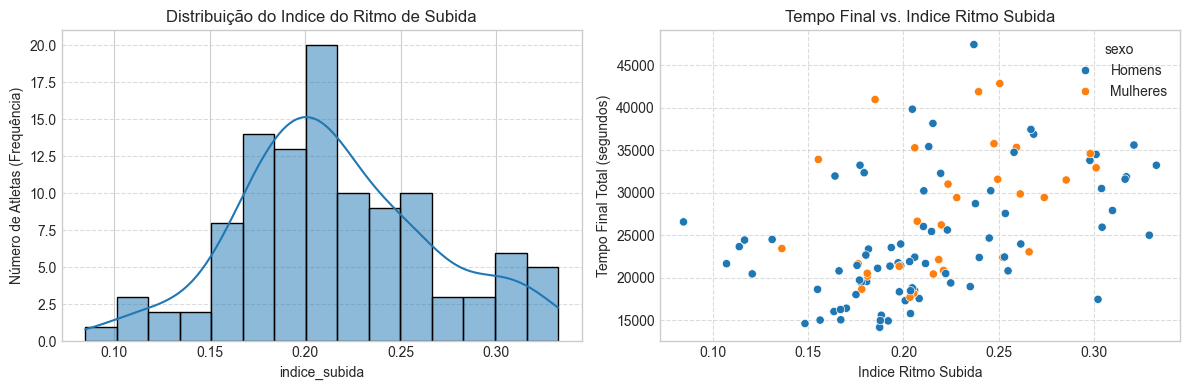

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_nivel_inclinacao,
    x="indice_subida",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Indice do Ritmo de Subida")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_subida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Subida")
axes[1].set_xlabel("Indice Ritmo Subida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [75]:
df_final_nivel_inclinacao["indice_subida"].describe().round(2)

count    109.00
mean       0.22
std        0.05
min        0.08
25%        0.18
50%        0.21
75%        0.25
max        0.33
Name: indice_subida, dtype: float64

1. **Histograma:**
   - Este gráfico mostra a distribuição do seu "Índice de Subida". Vemos que a maioria dos atletas se concentra na faixa de **0.15 a 0.25**.
   - **Tradução:** O perfil mais comum de atleta nesta prova é aquele cujo ritmo de subida é entre **15% e 25% mais lento** que seu ritmo médio geral. Atletas com índice abaixo de 0.15 (bons escaladores) são menos comuns, assim como atletas com índice acima de 0.25 (que perdem mais tempo na subida). A distribuição é aproximadamente normal, o que é esperado.

2. **Gráfico de Dispersão:**
   - > Este é o gráfico mais revelador. Ele mostra uma **clara correlação positiva** entre o "Índice de Subida" e o "Tempo Final".
   - **Tradução:** Quanto **maior** o índice de um atleta (ou seja, quanto pior for seu desempenho nas subidas em relação à sua média), **maior** (pior) será seu tempo final de prova.
   - **Conclusão:** Isso confirma de maneira visual e direta que **ser um bom escalador é um fator decisivo para um bom resultado nesta prova**. Os atletas que conseguem manter seu ritmo de subida mais próximo de seu ritmo geral (lado esquerdo do gráfico) são os que terminam a corrida mais rápido.

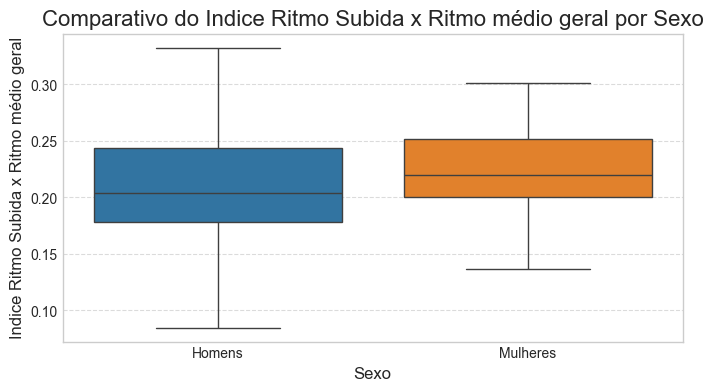

In [76]:
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualização
sns.boxplot(data=df_final_nivel_inclinacao, x="sexo", y="indice_subida", hue="sexo")

# Adicionar títulos e formatação
plt.title(
    "Comparativo do Indice Ritmo Subida x Ritmo médio geral por Sexo", fontsize=16
)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("Indice Ritmo Subida x Ritmo médio geral", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [77]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_nivel_inclinacao.groupby("sexo").agg(
    {
        "indice_subida": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print(
    "--- Resumo Estatístico Detalhado por Indice Ritmo Subida x Ritmo médio geral e sexo ---"
)
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Indice Ritmo Subida x Ritmo médio geral e sexo ---
         indice_subida                         
                  mean   std   min median   max
sexo                                           
Homens            0.21  0.05  0.08   0.20  0.33
Mulheres          0.22  0.04  0.14   0.22  0.30


**Interpretação dos Resultados**

A principal conclusão deste gráfico é a **notável semelhança** entre os dois sexos quando normalizamos o desempenho na subida pelo ritmo geral de cada atleta.

- **Desempenho Relativo Quase Idêntico:**
  - Em média, o ritmo de subida dos **Homens** foi **21%** mais lento que o seu ritmo médio geral (`mean: 0.21`).
  - Para as **Mulheres**, o ritmo de subida foi **22%** mais lento que o seu ritmo médio geral (`mean: 0.22`).
  - As medianas (`0.20` para homens e `0.22` para mulheres) confirmam essa proximidade.

- **Conclusão:**
  > Apesar dos homens serem mais rápidos em termos *absolutos*, o "custo" de performance que as subidas impõem é praticamente o mesmo para ambos os sexos. Proporcionalmente, homens e mulheres perdem uma quantidade similar de ritmo nos trechos de escalada em relação ao que conseguem manter no restante da prova. Isso sugere que, em termos de perfil de atleta (*escalador vs. não-escalador*), os dois grupos são muito parecidos.

##### Indice do Ritmo Descida vs Ritmo médio Geral da prova

O índice criado`(Ritmo Descida - Ritmo Geral) / Ritmo Geral` é uma ótima forma de medir a **especialização** de um atleta. Ele responde à pergunta: 

"*O quão mais rápido um atleta é na descida em comparação com seu próprio desempenho médio geral?*"
>
> - Um índice **alto** indica um *perde mais tempo* (seu ritmo na descida é próximo do seu ritmo geral).
> - Um índice **baixo** indica o quão o atleta é *mais rápido* nas descida em relação à sua média.


In [78]:
df_final_nivel_inclinacao.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,Ritmo_Medio_DESCIDA_min,Ritmo_Medio_MISTO_min,Ritmo_Medio_PLANO_min,Ritmo_Medio_SUBIDA_min,Tempo_Total_DESCIDA_min,Tempo_Total_MISTO_min,Tempo_Total_PLANO_min,Tempo_Total_SUBIDA_min,indice_subida,indice_descida,indice_descida_vs_subida
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.900000,10.080556,4.838189,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.10,-37.76,-0.19,522.933333,474.5,335.5,724.117647,7844,949,671,12310,8.72,7.91,5.59,12.07,130.73,15.82,11.18,205.17,0.197218,-0.135409,-0.277834
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,533.100000,14.808333,6.959947,942.944444,834.055556,16973,15013,15.72,13.90,282.88,250.22,-1.82,-32.66,-0.12,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,13.17,12.37,8.92,17.24,197.48,24.73,17.83,293.05,0.164090,-0.110936,-0.236259
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,563.766667,15.660185,11.161993,945.388889,933.833333,17017,16809,15.76,15.56,283.62,280.15,-0.20,-3.47,-0.01,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,12.42,10.47,5.52,20.32,186.32,20.93,11.03,345.48,0.297721,-0.206835,-0.388802
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,2022,18496,513.777778,261.647539,2787.0,-2790.0,308.266667,8.562963,4.360792,598.944444,428.611111,10781,7715,9.98,7.14,179.68,128.58,-2.84,-51.10,-0.28,443.133333,434.0,224.5,619.529412,6647,868,449,10532,7.39,7.23,3.74,10.33,110.78,14.47,7.48,175.53,0.205831,-0.137500,-0.284726
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,2022,14626,417.885714,195.390826,2779.0,-2781.0,243.766667,6.964762,3.256514,467.722222,365.117647,8419,6207,7.80,6.09,140.32,103.45,-1.71,-36.87,-0.22,366.466667,352.0,267.0,479.882353,5497,704,267,8158,6.11,5.87,4.45,8.00,91.62,11.73,4.45,135.97,0.148358,-0.123046,-0.236341


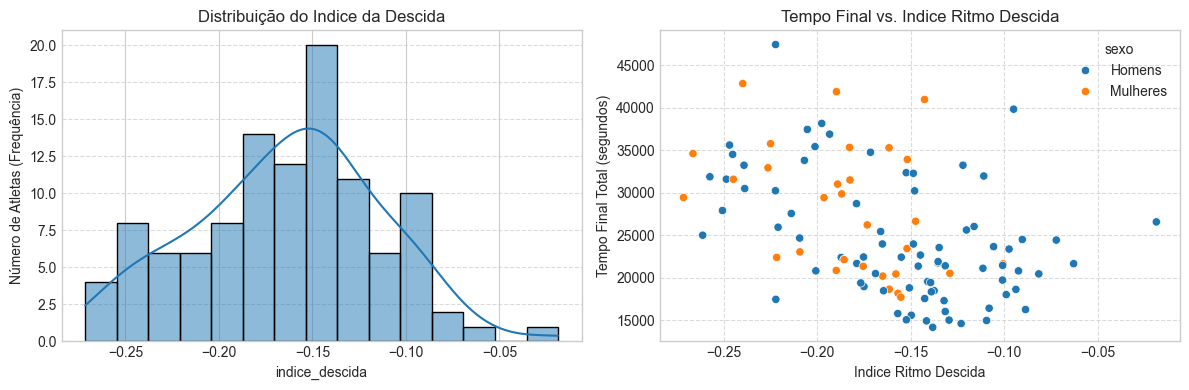

In [79]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Indice da Descida")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Descida")
axes[1].set_xlabel("Indice Ritmo Descida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [80]:
df_final_nivel_inclinacao["indice_descida"].describe().round(2)

count    109.00
mean      -0.16
std        0.05
min       -0.27
25%       -0.20
50%       -0.16
75%       -0.13
max       -0.02
Name: indice_descida, dtype: float64

**Interpretação do Índice de Descida**

1. **Histograma e Estatísticas Descritivas:**
    - A análise confirma que o atleta médio tem um ritmo de descida **16% mais rápido** que seu ritmo médio geral (`mean: -0.16`). A distribuição é bastante normal e simétrica, como mostra o histograma.
    - O perfil do atleta típico nesta prova é muito consistente: a maioria (o miolo de 50% do campo, entre os quartis de 25% e 75%) tem um ritmo de descida entre **13% e 20%** mais rápido que sua média geral.
    - É interessante notar que o "pior" descensor (`max: -0.02`) ainda foi 2% mais rápido que sua própria média, confirmando a natureza veloz da segunda metade da prova para todos.

2. **Gráfico de Dispersão (Tempo Final vs. Índice de Descida):**
    - O gráfico mostra uma correlação negativa clara: à medida que o índice vai da esquerda para a direita (de mais negativo para menos negativo), o tempo final tende a descer. Ou seja, quanto maior o indice da descida (mais lento em relação ao ritmo médio geral) menor tempo final.


In [81]:
correlacoes = df_final_nivel_inclinacao[["Tempo_Final_seg", "indice_descida"]].corr()

print(correlacoes)

                 Tempo_Final_seg  indice_descida
Tempo_Final_seg         1.000000       -0.457405
indice_descida         -0.457405        1.000000



Para interpretar o gráfico e a correlçaõ,vamos dividir em três partes: o sinal, a magnitude e o que isso significa no contexto da prova.

1.  **O Sinal (`-`):**
    - Um sinal negativo indica uma **correlação inversa**. Isso significa que, à medida que uma variável **aumenta**, a outra tende a **diminuir**.
    - No nosso caso: À medida que o `Índice de Descida` **aumenta** (ou seja, fica *menos negativo*, indo de -0.25 em direção a 0), o `Tempo Final` tende a **diminuir** (ficar mais rápido).

2.  **A Magnitude (`0.457`):**
    - O valor de 0.457, em valor absoluto, é considerado uma **correlação moderada**. Não é fraca, mas também não é forte como a que vimos para a subida. A relação existe e é estatisticamente relevante, mas não é tão direta e preditiva.

3.  **A Conclusão (O "O que quer dizer?"):**
    > Juntando o sinal e a magnitude, o resultado é surpreendente e nos diz algo novo sobre a estratégia da prova:
    >
    > Surpreendentemente, atletas que são **especialistas extremos** em descida (com um índice muito negativo, no lado esquerdo do gráfico) **não foram necessariamente os mais rápidos no geral**. A correlação sugere que os atletas com um perfil mais **equilibrado** — cujo ritmo de descida é rápido, mas não *extremamente* discrepante de sua média geral — tenderam a ter os melhores tempos.
    >
    > **Por que isso faria sentido?** Uma hipótese é que um atleta com um índice de descida extremo pode ser um escalador muito fraco, perdendo muito mais tempo na subida do que consegue compensar na descida. O resultado favorece o atleta mais completo, e não o especialista em apenas um terreno.
    >
    > **Resumindo:** Ser um bom descensor ajuda, mas ser *demasiado* especialista nisso (em detrimento de outras habilidades, como a subida) parece não ser a estratégia vencedora nesta prova. Isso reforça nossa conclusão anterior de que a **subida é o fator mais decisivo**.

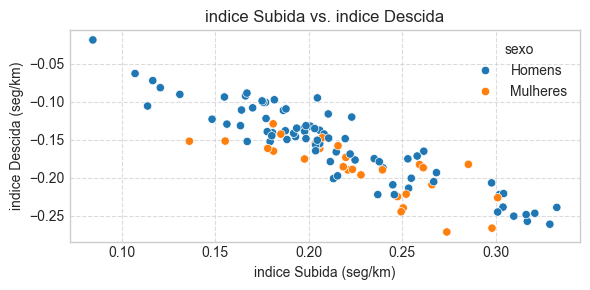

In [82]:
plt.figure(figsize=(6, 3))
sns.scatterplot(
    data=df_final_nivel_inclinacao, x="indice_subida", y="indice_descida", hue="sexo"
)
plt.title("indice Subida vs. indice Descida")
plt.ylabel("indice Descida (seg/km)")
plt.xlabel("indice Subida (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

Estamos vendo um comportamento real dos atletas ou um artefato matemático?

A resposta é: **provavelmente os dois, e seu gráfico comprova isso brilhantemente.**

Vamos por partes.



1.  Esse gráfico mostra uma clara **correlação negativa**: atletas que são escaladores piores (mais à direita no eixo X, com `índice Subida` alto) tendem a ser descensores melhores (mais para baixo no eixo Y, com `índice Descida` bem negativo). A "nuvem" de pontos vai claramente do canto superior esquerdo para o inferior direito.

2.  Podemos observar que há, de fato, um **efeito matemático parcial**: um atleta muito lento na subida terá um ritmo médio geral (`Ritmo_Medio_seg`) mais alto. Esse ritmo geral mais alto, quando usado como base de comparação, fará com que seu ritmo de descida pareça percentualmente ainda melhor (mais negativo), mesmo que a velocidade absoluta da descida não seja espetacular.
    - **Contudo, a tendência é forte e clara demais para ser *apenas* matemática.** O que o gráfico realmente revela são os **perfis de atleta** e a estratégia de **compensação**. Atletas que sabem que não são bons escaladores muitas vezes se poupam na subida para poderem "gastar tudo" na descida, onde têm mais habilidade técnica ou confiança.

A Conclusão da Análise

> Este gráfico é a síntese perfeita de toda a nossa investigação. Ele mostra que o desempenho nesta prova não é linear; é um jogo de **equilíbrio e compensação**.
>
> - No **canto superior esquerdo**, temos os atletas mais *equilibrados*: são bons escaladores (índice de subida baixo) e, consequentemente, não precisam ser descensores extremos para obter um bom resultado.
> - No **canto inferior direito**, temos os *especialistas/compensadores*: são atletas que perdem mais tempo na subida, mas compensam essa "fraqueza" sendo excelentes descensores, com uma melhora relativa de ritmo muito acentuada na descida.
>
> **Em resumo:** O gráfico confirma que existe um *trade-off* (uma troca) claro entre a performance de subida e de descida. Você validou com sucesso que atletas mais fracos na subida tendem a compensar com uma performance relativa superior na descida.

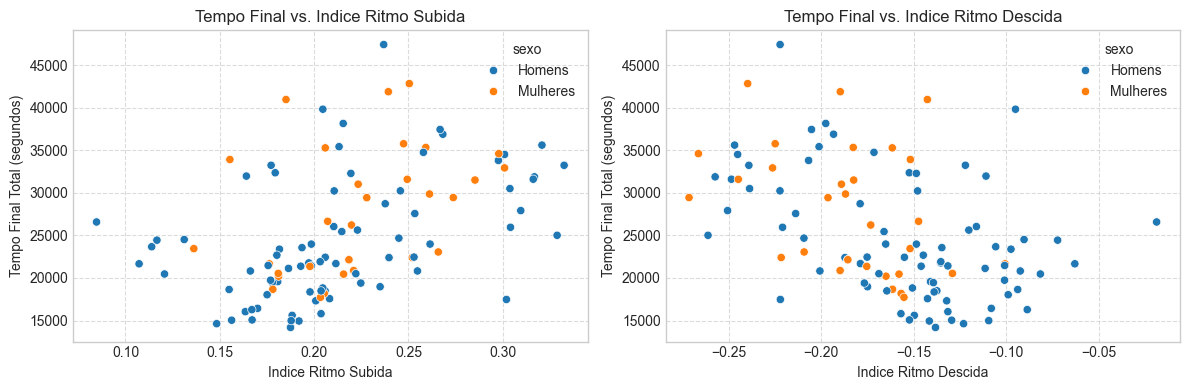

In [83]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_subida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Tempo Final vs. Indice Ritmo Subida")
axes[0].set_xlabel("Indice Ritmo Subida")
axes[0].set_ylabel("Tempo Final Total (segundos)")
axes[0].grid(linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Descida")
axes[1].set_xlabel("Indice Ritmo Descida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [84]:
correlacoes = df_final_nivel_inclinacao[
    ["Tempo_Final_seg", "indice_subida", "indice_descida"]
].corr()

print(correlacoes)

                 Tempo_Final_seg  indice_subida  indice_descida
Tempo_Final_seg         1.000000       0.439045       -0.457405
indice_subida           0.439045       1.000000       -0.884126
indice_descida         -0.457405      -0.884126        1.000000


**Comparativo Final: Subida vs. Descida**

Agora podemos responder à pergunta final da nossa análise.

> Ambas as especializações, subida e descida, são importantes para um bom resultado. No entanto, ao comparar visualmente o gráfico de dispersão do *Índice de Subida* com este novo do *Índice de Descida*, a nuvem de pontos para a descida parece um pouco mais dispersa.
>
> **Conclusão Geral:** A análise sugere que, embora ser um bom descensor não contribua para um tempo final mais rápido, ser um **escalador de elite (ou seja, não perder muito tempo na subida em relação à sua média) tem um impacto ainda mais decisivo no resultado final**. A subida parece atuar como o principal "filtro" de desempenho e o maior preditor de sucesso nesta competição.
> **Mas principalmente ser um atleta mais equilbrado entre subidas e descidas**

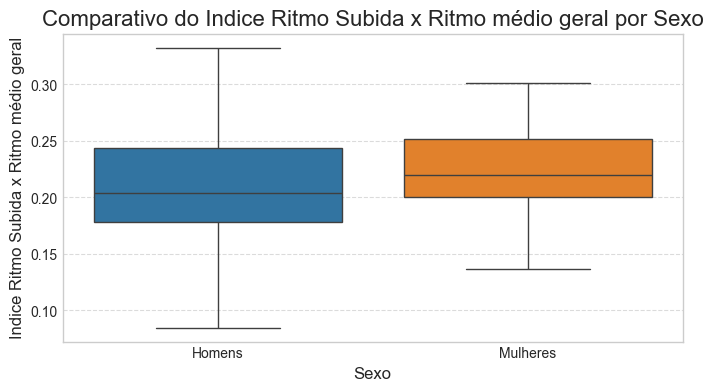

In [85]:
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualização
sns.boxplot(data=df_final_nivel_inclinacao, x="sexo", y="indice_subida", hue="sexo")

# Adicionar títulos e formatação
plt.title(
    "Comparativo do Indice Ritmo Subida x Ritmo médio geral por Sexo", fontsize=16
)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("Indice Ritmo Subida x Ritmo médio geral", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [86]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_nivel_inclinacao.groupby("sexo").agg(
    {
        "indice_subida": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print(
    "--- Resumo Estatístico Detalhado por Indice Ritmo Subida x Ritmo médio geral e sexo ---"
)
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Indice Ritmo Subida x Ritmo médio geral e sexo ---
         indice_subida                         
                  mean   std   min median   max
sexo                                           
Homens            0.21  0.05  0.08   0.20  0.33
Mulheres          0.22  0.04  0.14   0.22  0.30


**Interpretação dos Resultados**

A principal conclusão deste gráfico é a **notável semelhança** entre os dois sexos quando normalizamos o desempenho na subida pelo ritmo geral de cada atleta.

- **Desempenho Relativo Quase Idêntico:**
  - Em média, o ritmo de subida dos **Homens** foi **21%** mais lento que o seu ritmo médio geral (`mean: 0.21`).
  - Para as **Mulheres**, o ritmo de subida foi **22%** mais lento que o seu ritmo médio geral (`mean: 0.22`).
  - As medianas (`0.20` para homens e `0.22` para mulheres) confirmam essa proximidade.

- **Conclusão:**
  > Apesar dos homens serem mais rápidos em termos *absolutos*, o "custo" de performance que as subidas impõem é praticamente o mesmo para ambos os sexos. Proporcionalmente, homens e mulheres perdem uma quantidade similar de ritmo nos trechos de escalada em relação ao que conseguem manter no restante da prova. Isso sugere que, em termos de perfil de atleta (*escalador vs. não-escalador*), os dois grupos são muito parecidos.

##### Indice do Ritmo Descida vs Ritmo Subida

Este índice, que podemos chamar de **"Índice de Aceleração Relativa"**, é a métrica mais direta para compararmos a performance de um atleta nos dois terrenos principais da prova. Ele responde à pergunta:

"*Qual o ganho percentual de velocidade que um atleta obtém na descida em comparação direta com seu desempenho na subida?*"
>
> - Um índice **mais alto** (próximo de zero) indica um atleta mais *equilibrado*, com menor diferença de ritmo entre subida e descida.
> - Um índice **mais baixo** (mais negativo) indica um atleta *especialista/compensador*, com uma aceleração muito maior na descida em relação à sua subida.

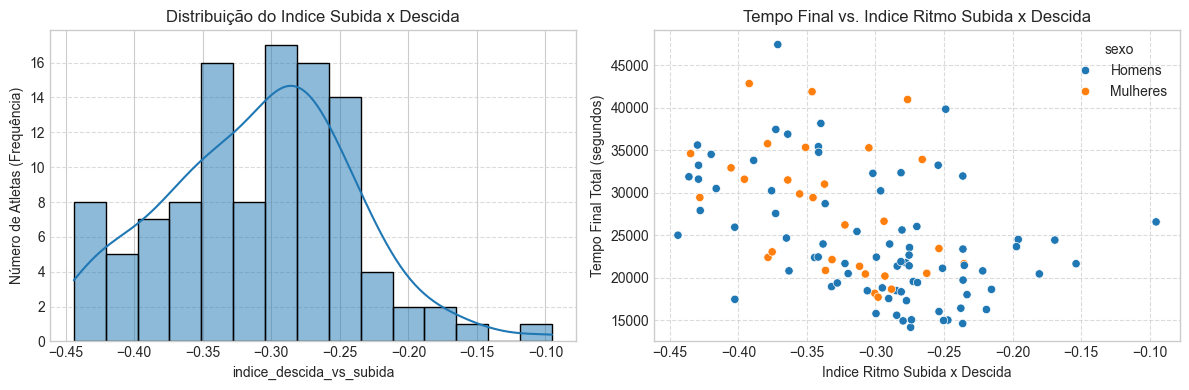

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.histplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida_vs_subida",
    kde=True,
    bins=15,
    ax=axes[0],  # Direciona o plot para o primeiro eixo
)
axes[0].set_title("Distribuição do Indice Subida x Descida")
axes[0].set_ylabel("Número de Atletas (Frequência)")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="indice_descida_vs_subida",
    y="Tempo_Final_seg",
    hue="sexo",
    ax=axes[1],  # Direciona o plot para o segundo eixo
)
axes[1].set_title("Tempo Final vs. Indice Ritmo Subida x Descida")
axes[1].set_xlabel("Indice Ritmo Subida x Descida")
axes[1].set_ylabel("Tempo Final Total (segundos)")
axes[1].grid(linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [88]:
df_final_nivel_inclinacao["indice_descida_vs_subida"].describe().round(2)

count    109.00
mean      -0.31
std        0.07
min       -0.44
25%       -0.36
50%       -0.30
75%       -0.27
max       -0.10
Name: indice_descida_vs_subida, dtype: float64

In [89]:
corr = df_final_nivel_inclinacao[["Tempo_Final_seg", "indice_descida_vs_subida"]].corr()
corr

,Tempo_Final_seg,indice_descida_vs_subida
Tempo_Final_seg,1.000000,-0.455566
indice_descida_vs_subida,-0.455566,1.000000


Estes gráficos nos permitem consolidar a análise e desenhar o perfil do atleta de maior sucesso nesta prova.

1.  **Distribuição do Índice (Gráfico da Esquerda):**
    - O histograma mostra a distribuição do "Índice de Aceleração" (`Descida vs. Subida`). A maioria dos atletas se concentra em uma faixa de melhora relativa entre **-0.20 (20%) e -0.35 (35%)**.
    - Isso nos mostra o comportamento *típico* da prova: é normal e esperado que um atleta seja de 20% a 35% mais rápido na descida. Perfis mais "equilibrados" (índice > -0.20) ou de "especialistas extremos" (índice < -0.35) são menos comuns.

2.  **Relação com o Tempo Final (Gráfico da Direita):**
    - Este gráfico de dispersão é a peça-chave. Ele não mostra uma correlação linear simples, indicando que a relação entre o índice e o sucesso não é "quanto mais, melhor".
    - A análise visual revela o que podemos chamar de **"Faixa de Ouro"** do desempenho. Os atletas com os melhores tempos finais (pontos mais baixos no gráfico) não estão espalhados aleatoriamente, mas sim concentrados em um intervalo específico do índice, aproximadamente entre **-0.35 e -0.20**.

**Conclusão**

> A hipótese de que o atleta mais "equilibrado" (com menor diferença entre ritmos) seria o mais rápido não se confirma. Na verdade, ser *pouco* agressivo na descida está associado a tempos finais mais lentos.
>
> Da mesma forma, ser um *especialista extremo* (com a maior aceleração relativa possível) também não garante o sucesso, sugerindo que isso vem ao custo de um desempenho muito fraco na subida, que é irrecuperável.
>
> **A conclusão final é que o sucesso nesta prova reside em uma "especialização otimizada". Os atletas de elite são aqueles que encontram o ponto ideal: eles aplicam uma aceleração significativa e agressiva nas descidas (melhora de 20% a 35%), mas sem que essa estratégia canibalize seu desempenho a ponto de criar um déficit impagável nas subidas.**

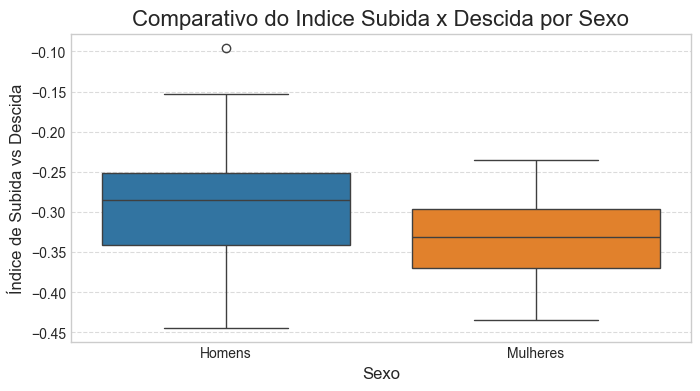

In [90]:
plt.figure(figsize=(8, 4))  # Ajustei o tamanho para melhor visualização
sns.boxplot(
    data=df_final_nivel_inclinacao, x="sexo", y="indice_descida_vs_subida", hue="sexo"
)

# Adicionar títulos e formatação
plt.title("Comparativo do Indice Subida x Descida por Sexo", fontsize=16)
plt.xlabel("Sexo", fontsize=12)
plt.ylabel("Índice de Subida vs Descida", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [91]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = df_final_nivel_inclinacao.groupby("sexo").agg(
    {
        "indice_descida_vs_subida": estatisticas_describe,
    },
    future_stack=True,
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Indice Subida/Descida e sexo ---")
print(resumo_completo.round(3))

--- Resumo Estatístico Detalhado por Indice Subida/Descida e sexo ---
         indice_descida_vs_subida                            
                             mean    std    min median    max
sexo                                                         
Homens                     -0.300  0.072 -0.444 -0.285 -0.095
Mulheres                   -0.332  0.051 -0.435 -0.332 -0.235


**Interpretação dos Resultados**

Com a nova fórmula, o índice agora representa o **ganho percentual de velocidade** (ou a *redução do pace*) da subida para a descida. Um número mais negativo significa uma aceleração relativa maior e, portanto, um desempenho relativo melhor.

1. **Desempenho Relativo Superior das Mulheres:**
    - O resultado é inequívoco. Tanto a média (`-0.332`) quanto a mediana (`-0.332`) das mulheres são **mais negativas** que a média (`-0.300`) e a mediana (`-0.285`) dos homens.
    - **Tradução:** Em média, as mulheres foram **33.2% mais rápidas** nas descidas em relação às suas próprias subidas. Os homens, por sua vez, registraram uma melhora de **30.0%**.

2. **Consistência e Variabilidade:**
    - A análise da dispersão dos dados revela um insight fundamental. O desvio padrão (`std`) do grupo feminino (`0.051`) é consideravelmente **menor** que o do grupo masculino (`0.072`).
    - **Tradução:** O grupo feminino é notavelmente **mais consistente e homogêneo** nesta métrica. Em contrapartida, o grupo masculino é mais heterogêneo, com maior variação na habilidade de converter o ritmo de subida em um ritmo de descida eficiente.

**Conclusão Final**

> A criação e análise desta variável final nos permite consolidar a principal descoberta da análise comparativa de desempenho:
>
> Enquanto os homens são, em termos *absolutos*, mais rápidos tanto nas subidas quanto nas descidas, a análise de desempenho *relativo* revela que **as mulheres demonstram uma capacidade superior e mais consistente de acelerar nos trechos de descida** em relação ao seu próprio ritmo de subida.
>
> Este achado sugere diferentes perfis estratégicos ou fisiológicos entre os sexos nesta prova, uma nuance que permaneceria oculta se analisássemos apenas os tempos absolutos ou finais.

##### Avaliando o Ritmo médio Subida Absoluto vs tempo final

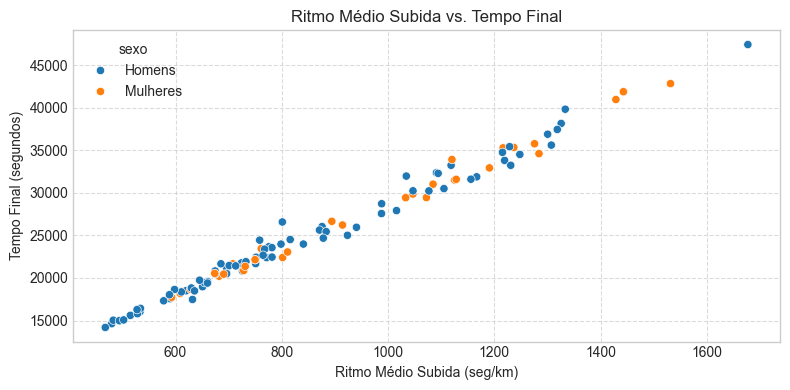

In [92]:
plt.figure(figsize=(8, 4))
sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="Ritmo_Medio_SUBIDA",
    y="Tempo_Final_seg",
    hue="sexo",
)
plt.title("Ritmo Médio Subida vs. Tempo Final")
plt.ylabel("Tempo Final (segundos)")
plt.xlabel("Ritmo Médio Subida (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

##### Avaliando o Ritmo médio Descida Absoluto vs tempo final

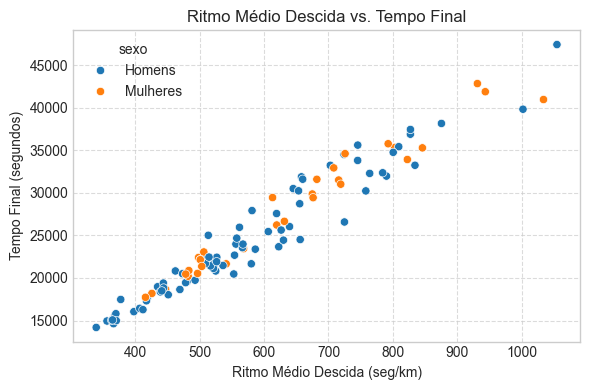

In [93]:
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_final_nivel_inclinacao,
    x="Ritmo_Medio_DESCIDA",
    y="Tempo_Final_seg",
    hue="sexo",
)
plt.title("Ritmo Médio Descida vs. Tempo Final")
plt.ylabel("Tempo Final (segundos)")
plt.xlabel("Ritmo Médio Descida (seg/km)")
plt.grid(linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()

##### Corr Ritmos Subida/Descidas Abs x Tempo Prova

In [94]:
correlacoes = df_final_nivel_inclinacao[
    ["Tempo_Final_seg", "Ritmo_Medio_SUBIDA", "Ritmo_Medio_DESCIDA"]
].corr()

print(correlacoes)

                     Tempo_Final_seg  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA
Tempo_Final_seg             1.000000            0.993332             0.973078
Ritmo_Medio_SUBIDA          0.993332            1.000000             0.944208
Ritmo_Medio_DESCIDA         0.973078            0.944208             1.000000


- A análise mostra que tanto o ritmo médio na **Subida** quanto na **Descida** são preditores excepcionalmente fortes do tempo final, com correlações quase perfeitas. Embora o ritmo médio na **Subida** tenha uma correlação marginalmente maior, a diferença é tão trivial que não é estatisticamente significativa. Para todos os efeitos práticos, você pode concluir que o desempenho em ambas as inclinação da prova é igualmente crucial e determinante para o resultado final do atleta.

- **Ponto de Atenção**: Existe uma correlação alta entre duas varáiveis que podem vir a ser usadas numa futura modelagem.

#### Analise distribuição partes das provas

##### Dividindo em Partes de 5 em 5km

In [95]:
df_segmentado = df_completo.copy()
df_segmentado["Trecho_5km"] = df_segmentado["km_prova"].apply(
    lambda km: f"Trecho {int((km - 1) // 5) * 5}-{int((km - 1) // 5) * 5 + 5} km"
)
df_segmentado.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano,km_prova,tempo_por_km_seg,ano_mais_antigo,desnivel_positivo,desnivel_negativo,Trecho_5km
0,André Mapa,Homens,35 a 44,Não informado,2023,1.0,285,2023,13.0,-9.0,Trecho 0-5 km
1,André Mapa,Homens,35 a 44,Não informado,2023,2.0,298,2023,88.0,0.0,Trecho 0-5 km
2,André Mapa,Homens,35 a 44,Não informado,2023,3.0,295,2023,58.0,0.0,Trecho 0-5 km
3,André Mapa,Homens,35 a 44,Não informado,2023,4.0,363,2023,46.0,-81.0,Trecho 0-5 km
4,André Mapa,Homens,35 a 44,Não informado,2023,5.0,357,2023,41.0,-58.0,Trecho 0-5 km


In [96]:
estatisticas_describe = ["mean", "std", "min", "median", "max"]

# 2. Crie o dicionário de agregação, passando a lista de estatísticas para cada coluna
resumo_completo = (
    df_segmentado.groupby("Trecho_5km")
    .agg(
        {
            "tempo_por_km_seg": estatisticas_describe,
            "desnivel_positivo": estatisticas_describe,
            "desnivel_negativo": estatisticas_describe,
        }
    )
    .stack(level=0)
)

# 3. Imprima o resultado. Usar .round(2) ajuda na visualização.
print("--- Resumo Estatístico Detalhado por Parte da Prova ---")
print(resumo_completo.round(2))

--- Resumo Estatístico Detalhado por Parte da Prova ---
                                      mean     std    min  median     max
Trecho_5km                                                               
Trecho 0-5 km   desnivel_negativo   -29.60   33.57  -81.0    -9.0     0.0
                desnivel_positivo    49.20   24.40   13.0    46.0    88.0
                tempo_por_km_seg    479.35  196.66  262.0   439.0  1908.0
Trecho 10-15 km desnivel_negativo   -19.40   12.38  -37.0   -18.0     0.0
                desnivel_positivo    94.60   50.56   50.0    79.0   193.0
                tempo_por_km_seg    683.62  341.78  295.0   597.0  2988.0
Trecho 15-20 km desnivel_negativo   -85.80  122.40 -329.0   -30.0    -2.0
                desnivel_positivo   199.20  118.72   15.0   167.0   354.0
                tempo_por_km_seg   1350.08  800.02  246.0  1175.0  4463.0
Trecho 20-25 km desnivel_negativo   -94.80   65.73 -162.0  -137.0   -13.0
                desnivel_positivo    90.60  105.06    6.

C:\Users\Home\AppData\Local\Temp\ipykernel_4648\2559900150.py:13: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=0)


- O Trecho Mais Difícil (15-20 km): Este é, sem dúvida, o "coração" da prova e o trecho mais brutal. Possui a maior média de ganho de elevação (mean 199.20m por km) e, consequentemente, o tempo médio mais lento de todos (mean 1350s, ou 22min30s por km). É o divisor de águas da corrida.

- A Subida Progressiva (0-15 km): A dificuldade da prova aumenta gradualmente até o pico. O ritmo fica progressivamente mais lento do trecho 0-5 km ao 10-15 km, à medida que a altimetria média aumenta.

- A Grande Descida (25-30 km): Após o trecho mais difícil, esta é a principal seção de descida da prova (mean de -179.40m por km). O ganho de elevação é mínimo (mean 8.60m) e o ritmo volta a ser rápido (mean 554s).

- O Sprint Final (35-40 km): O final da prova é extremamente rápido. Com pouquíssima variação de terreno, este é de longe o trecho com o menor tempo médio (mean 260s, ou 4min20s por km).

Em resumo: A prova concentra sua maior dificuldade em um bloco de subida brutal entre os quilômetros 15 e 20, seguido por uma longa seção de descida e um final muito veloz e plano.

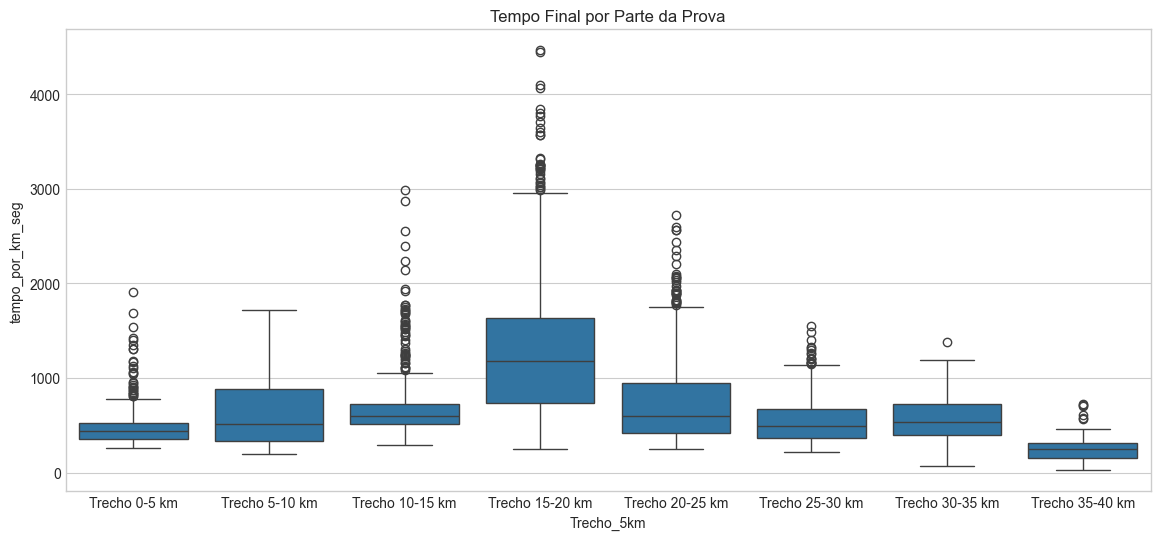

In [97]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_segmentado, x="Trecho_5km", y="tempo_por_km_seg")
plt.title("Tempo Final por Parte da Prova")
plt.show()

In [98]:
ritmo_por_5km = df_segmentado.groupby(["Nome Atleta", "Trecho_5km"]).agg(
    tempo_por_km_seg=("tempo_por_km_seg", "mean"),
    tempo_total=("tempo_por_km_seg", "sum"),
)
comparativo_splits = ritmo_por_5km.unstack()
multi_level_columns = comparativo_splits.columns
novos_nomes_colunas = [
    f"Ritmo_Medio_{metade.replace(' ', '_')}"
    if metrica == "tempo_por_km_seg"
    else f"Tempo_Total_{metade.replace(' ', '_')}"
    for metrica, metade in multi_level_columns
]

# 3. Atribua os novos nomes ao seu DataFrame
comparativo_splits_flat = comparativo_splits.copy()  # Copia para não alterar o original
comparativo_splits_flat.columns = novos_nomes_colunas

colunas_em_segundos = novos_nomes_colunas

for coluna in colunas_em_segundos:
    # 3. Defina o nome da nova coluna, adicionando '_min' ao final
    nova_coluna_min = coluna + "_min"

    # 4. Crie a nova coluna, fazendo a conversão (dividir por 60) e arredondando (round(2))
    comparativo_splits_flat[nova_coluna_min] = (
        comparativo_splits_flat[coluna] / 60
    ).round(2)


df_split_5km = comparativo_splits_flat.reset_index()
df_split_5km.head(5)

,Nome Atleta,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,Ritmo_Medio_Trecho_35-40_km,Ritmo_Medio_Trecho_5-10_km,Tempo_Total_Trecho_0-5_km,Tempo_Total_Trecho_10-15_km,Tempo_Total_Trecho_15-20_km,Tempo_Total_Trecho_20-25_km,Tempo_Total_Trecho_25-30_km,Tempo_Total_Trecho_30-35_km,Tempo_Total_Trecho_35-40_km,Tempo_Total_Trecho_5-10_km,Ritmo_Medio_Trecho_0-5_km_min,Ritmo_Medio_Trecho_10-15_km_min,Ritmo_Medio_Trecho_15-20_km_min,Ritmo_Medio_Trecho_20-25_km_min,Ritmo_Medio_Trecho_25-30_km_min,Ritmo_Medio_Trecho_30-35_km_min,Ritmo_Medio_Trecho_35-40_km_min,Ritmo_Medio_Trecho_5-10_km_min,Tempo_Total_Trecho_0-5_km_min,Tempo_Total_Trecho_10-15_km_min,Tempo_Total_Trecho_15-20_km_min,Tempo_Total_Trecho_20-25_km_min,Tempo_Total_Trecho_25-30_km_min,Tempo_Total_Trecho_30-35_km_min,Tempo_Total_Trecho_35-40_km_min,Tempo_Total_Trecho_5-10_km_min
0,ALFREDO GUIMARAES,419.0,634.8,983.0,495.4,539.8,611.4,357.0,600.0,2095.0,3174.0,4915.0,2477.0,2699.0,3057.0,357.0,3000.0,6.98,10.58,16.38,8.26,9.00,10.19,5.95,10.00,34.92,52.90,81.92,41.28,44.98,50.95,5.95,50.00
1,Albert Melo,599.8,825.4,1442.8,737.4,825.0,927.8,701.0,898.8,2999.0,4127.0,7214.0,3687.0,4125.0,4639.0,701.0,4494.0,10.00,13.76,24.05,12.29,13.75,15.46,11.68,14.98,49.98,68.78,120.23,61.45,68.75,77.32,11.68,74.90
2,Alessandro Sousa(allê),508.2,748.0,2026.4,1284.6,717.6,732.0,271.0,694.2,2541.0,3740.0,10132.0,6423.0,3588.0,3660.0,271.0,3471.0,8.47,12.47,33.77,21.41,11.96,12.20,4.52,11.57,42.35,62.33,168.87,107.05,59.80,61.00,4.52,57.85
3,Alex Junior Aj,366.2,568.6,869.4,404.2,445.6,478.2,174.0,532.2,1831.0,2843.0,4347.0,2021.0,2228.0,2391.0,174.0,2661.0,6.10,9.48,14.49,6.74,7.43,7.97,2.90,8.87,30.52,47.38,72.45,33.68,37.13,39.85,2.90,44.35
4,Alexandre Santiago,316.6,448.6,658.6,313.8,373.0,401.6,NaN,413.0,1583.0,2243.0,3293.0,1569.0,1865.0,2008.0,NaN,2065.0,5.28,7.48,10.98,5.23,6.22,6.69,NaN,6.88,26.38,37.38,54.88,26.15,31.08,33.47,NaN,34.42


##### Juntando as tabelas

In [99]:
# Vamos unir as duas tabelas
df_final_completo_split_5km = pd.merge(
    left=df_final_nivel_inclinacao,  # A tabela principal, da esquerda
    right=df_split_5km,  # A tabela com os splits, da direita
    on="Nome Atleta",  # A chave na tabela da esquerda é a COLUNA 'Nome Atleta'
    how="left",  # 'how=left' garante que todos os atletas da tabela principal sejam mantidos
)

df_final_completo_split_5km.head()

,Nome Atleta,sexo,faixa_etaria,peso,ano_corrida,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Total_Desnivel_Positivo,Total_Desnivel_negativo,Tempo_Final_min,Ritmo_Medio_min,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Ritmo_Medio_Primeira_Metade_min,Ritmo_Medio_Segunda_Metade_min,Tempo_Total_Primeira_Metade_min,Tempo_Total_Segunda_Metade_min,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,Ritmo_Medio_DESCIDA_min,Ritmo_Medio_MISTO_min,Ritmo_Medio_PLANO_min,Ritmo_Medio_SUBIDA_min,Tempo_Total_DESCIDA_min,Tempo_Total_MISTO_min,Tempo_Total_PLANO_min,Tempo_Total_SUBIDA_min,indice_subida,indice_descida,indice_descida_vs_subida,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,Ritmo_Medio_Trecho_35-40_km,Ritmo_Medio_Trecho_5-10_km,Tempo_Total_Trecho_0-5_km,Tempo_Total_Trecho_10-15_km,Tempo_Total_Trecho_15-20_km,Tempo_Total_Trecho_20-25_km,Tempo_Total_Trecho_25-30_km,Tempo_Total_Trecho_30-35_km,Tempo_Total_Trecho_35-40_km,Tempo_Total_Trecho_5-10_km,Ritmo_Medio_Trecho_0-5_km_min,Ritmo_Medio_Trecho_10-15_km_min,Ritmo_Medio_Trecho_15-20_km_min,Ritmo_Medio_Trecho_20-25_km_min,Ritmo_Medio_Trecho_25-30_km_min,Ritmo_Medio_Trecho_30-35_km_min,Ritmo_Medio_Trecho_35-40_km_min,Ritmo_Medio_Trecho_5-10_km_min,Tempo_Total_Trecho_0-5_km_min,Tempo_Total_Trecho_10-15_km_min,Tempo_Total_Trecho_15-20_km_min,Tempo_Total_Trecho_20-25_km_min,Tempo_Total_Trecho_25-30_km_min,Tempo_Total_Trecho_30-35_km_min,Tempo_Total_Trecho_35-40_km_min,Tempo_Total_Trecho_5-10_km_min
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,2022,21774,604.833333,290.291331,2787.0,-2790.0,362.900000,10.080556,4.838189,667.777778,541.888889,12020,9754,11.13,9.03,200.33,162.57,-2.10,-37.76,-0.19,522.933333,474.5,335.5,724.117647,7844,949,671,12310,8.72,7.91,5.59,12.07,130.73,15.82,11.18,205.17,0.197218,-0.135409,-0.277834,419.0,634.8,983.0,495.4,539.8,611.4,357.0,600.0,2095.0,3174.0,4915.0,2477.0,2699.0,3057.0,357.0,3000.0,6.98,10.58,16.38,8.26,9.00,10.19,5.95,10.00,34.92,52.90,81.92,41.28,44.98,50.95,5.95,50.00
1,Albert Melo,Homens,25 a 34,75 a 84 kg,2022,31986,888.500000,417.596832,2787.0,-2790.0,533.100000,14.808333,6.959947,942.944444,834.055556,16973,15013,15.72,13.90,282.88,250.22,-1.82,-32.66,-0.12,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,13.17,12.37,8.92,17.24,197.48,24.73,17.83,293.05,0.164090,-0.110936,-0.236259,599.8,825.4,1442.8,737.4,825.0,927.8,701.0,898.8,2999.0,4127.0,7214.0,3687.0,4125.0,4639.0,701.0,4494.0,10.00,13.76,24.05,12.29,13.75,15.46,11.68,14.98,49.98,68.78,120.23,61.45,68.75,77.32,11.68,74.90
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,2023,33826,939.611111,669.719569,2787.0,-2790.0,563.766667,15.660185,11.161993,945.388889,933.833333,17017,16809,15.76,15.56,283.62,280.15,-0.20,-3.47,-0.01,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,12.42,10.47,5.52,20.32,186.32,20.93,11.03,345.48,0.297721,-0.206835,-0.388802,508.2,748.0,2026.4,1284.6,717.6,732.0,271.0,694.2,2541.0,3740.0,10132.0,6423.0,3588.0,3660.0,271.0,3471.0,8.47,12.47,33.77,21.41,11.96,12.20,4.52,11.57,42.35,62.33,168.87,107.05,59.80,61.00,4.52,57.85
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,2022,18496,513.777778,261.647539,2787.0,-2790.0,308.266667,8.562963,4.360792,598.944444,428.611111,10781,7715,9.98,7.14,179.68,128.58,-2.84,-51.10,-0.28,443.133333,434.0,224.5,619.529412,6647,868,449,10532,7.39,7.23,3.74,10.33,110.78,14.47,7.48,175.53,0.205831,-0.137500,-0.284726,366.2,568.6,869.4,404.2,445.6,478.2,174.0,532.2,1831.0,2843.0,4347.0,2021.0,2228.0,2391.0,174.0,2661.0,6.10,9.48,14.49,6.74,7.43,7.97,2.90,8.87,30.52,47.38,72.45,33.68,37.13,39.85,2.90,44.35
4,Alex

### Selecionando as principais variáveis

In [100]:
df_final_com_tudo = df_final_completo_split_5km.copy()
df_selecionado = df_final_com_tudo[
    [
        "Nome Atleta",
        "sexo",
        "faixa_etaria",
        "peso",
        "Tempo_Final_seg",
        "Ritmo_Medio_seg",
        "Variabilidade_Ritmo_std",
        "Variabilidade_Ritmo_min_std",
        "Ritmo_Medio_Primeira_Metade",
        "Ritmo_Medio_Segunda_Metade",
        "Tempo_Total_Primeira_Metade",
        "Tempo_Total_Segunda_Metade",
        "Diferenca_Media_Seg_Menos_Pri",
        "Diferenca_total_Seg_Menos_Pri",
        "diff_relativa_segunda_primeira_parte",
        "Ritmo_Medio_Trecho_0-5_km",
        "Ritmo_Medio_Trecho_5-10_km",
        "Ritmo_Medio_Trecho_10-15_km",
        "Ritmo_Medio_Trecho_15-20_km",
        "Ritmo_Medio_Trecho_20-25_km",
        "Ritmo_Medio_Trecho_25-30_km",
        "Ritmo_Medio_Trecho_30-35_km",
        "Ritmo_Medio_Trecho_35-40_km",
        "Tempo_Total_Trecho_0-5_km",
        "Tempo_Total_Trecho_5-10_km",
        "Tempo_Total_Trecho_10-15_km",
        "Tempo_Total_Trecho_15-20_km",
        "Tempo_Total_Trecho_20-25_km",
        "Tempo_Total_Trecho_25-30_km",
        "Tempo_Total_Trecho_30-35_km",
        "Tempo_Total_Trecho_35-40_km",
        "Ritmo_Medio_DESCIDA",
        "Ritmo_Medio_MISTO",
        "Ritmo_Medio_PLANO",
        "Ritmo_Medio_SUBIDA",
        "Tempo_Total_DESCIDA",
        "Tempo_Total_MISTO",
        "Tempo_Total_PLANO",
        "Tempo_Total_SUBIDA",
        "indice_subida",
        "indice_descida_vs_subida",
        "indice_descida",
    ]
].copy()


df_selecionado.to_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_selecionado.head(10)

,Nome Atleta,sexo,faixa_etaria,peso,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_5-10_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,Ritmo_Medio_Trecho_35-40_km,Tempo_Total_Trecho_0-5_km,Tempo_Total_Trecho_5-10_km,Tempo_Total_Trecho_10-15_km,Tempo_Total_Trecho_15-20_km,Tempo_Total_Trecho_20-25_km,Tempo_Total_Trecho_25-30_km,Tempo_Total_Trecho_30-35_km,Tempo_Total_Trecho_35-40_km,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,indice_subida,indice_descida_vs_subida,indice_descida
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,21774,604.833333,290.291331,4.838189,667.777778,541.888889,12020,9754,-2.10,-37.76,-0.19,419.0,600.0,634.8,983.0,495.4,539.8,611.40,357.0,2095.0,3000.0,3174.0,4915.0,2477.0,2699.0,3057.0,357.0,522.933333,474.5,335.5,724.117647,7844,949,671,12310,0.197218,-0.277834,-0.135409
1,Albert Melo,Homens,25 a 34,75 a 84 kg,31986,888.500000,417.596832,6.959947,942.944444,834.055556,16973,15013,-1.82,-32.66,-0.12,599.8,898.8,825.4,1442.8,737.4,825.0,927.80,701.0,2999.0,4494.0,4127.0,7214.0,3687.0,4125.0,4639.0,701.0,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,0.164090,-0.236259,-0.110936
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,33826,939.611111,669.719569,11.161993,945.388889,933.833333,17017,16809,-0.20,-3.47,-0.01,508.2,694.2,748.0,2026.4,1284.6,717.6,732.00,271.0,2541.0,3471.0,3740.0,10132.0,6423.0,3588.0,3660.0,271.0,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,0.297721,-0.388802,-0.206835
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,18496,513.777778,261.647539,4.360792,598.944444,428.611111,10781,7715,-2.84,-51.10,-0.28,366.2,532.2,568.6,869.4,404.2,445.6,478.20,174.0,1831.0,2661.0,2843.0,4347.0,2021.0,2228.0,2391.0,174.0,443.133333,434.0,224.5,619.529412,6647,868,449,10532,0.205831,-0.284726,-0.137500
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,14626,417.885714,195.390826,3.256514,467.722222,365.117647,8419,6207,-1.71,-36.87,-0.22,316.6,413.0,448.6,658.6,313.8,373.0,401.60,NaN,1583.0,2065.0,2243.0,3293.0,1569.0,1865.0,2008.0,NaN,366.466667,352.0,267.0,479.882353,5497,704,267,8158,0.148358,-0.236341,-0.123046
5,Alexandre Zolio,Homens,45 a 54,85 a 94 kg,33253,923.694444,762.278607,12.704643,997.388889,850.000000,17953,15300,-2.45,-44.22,-0.15,555.4,725.2,707.0,2149.2,1220.6,654.8,631.80,33.0,2777.0,3626.0,3535.0,10746.0,6103.0,3274.0,3159.0,33.0,702.800000,713.0,180.0,1230.882353,10542,1426,360,20925,0.332564,-0.429027,-0.239142
6,Anamaria Bacci,Mulheres,45 a 54,65 a 74 kg,35306,1008.742857,741.446771,12.357446,1120.277778,890.647059,20165,15141,-3.83,-83.73,-0.20,586.4,858.6,838.4,2355.8,1216.2,635.0,570.80,NaN,2932.0,4293.0,4192.0,11779.0,6081.0,3175.0,2854.0,NaN,845.733333,797.0,346.0,1216.470588,12686,1594,346,20680,0.205927,-0.304765,-0.161597
7,André Mapa,Homens,35 a 44,Não informado,16040,458.285714,255.365548,4.256092,493.444444,421.058824,8882,7158,-1.20,-28.73,-0.15,319.6,404.2,483.2,750.4,616.8,318.8,315.00,NaN,1598.0,2021.0,2416.0,3752.0,3084.0,1594.0,1575.0,NaN,398.000000,360.0,285.0,533.235294,5970,720,285,9065,0.163543,-0.253613,-0.131546
8,Arnaldo Junio Rocha Pinho,Homens,25 a 34,75 a 84 kg,17569,488.027778,229.832422,3.830540,539.833333,436.222222,9717,7852,-1.73,-31.08,-0.19,334.6,491.8,502.8,811.0,389.8,439.2,493.60,255.0,1673.0,2459.0,2514.0,4055.0,1949.0,2196.0,2468.0,255.0,418.466667,371.0,263.0,589.647059,6277,742,526,10024,0.208224,-0.290310,-0.142535
9,Arnaldo 🇧🇷 Lamounier Junior,Homens,45 a 54,65 a 74 kg,24522,721.235294,433.609869,7.226831,738.333333,702.000000,13290,11232,-

## Clusterização

### Poucas variaveis

In [101]:
df_cluster = pd.read_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_cluster.head(10)

,Unnamed: 0,Nome Atleta,sexo,faixa_etaria,peso,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_5-10_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,Ritmo_Medio_Trecho_35-40_km,Tempo_Total_Trecho_0-5_km,Tempo_Total_Trecho_5-10_km,Tempo_Total_Trecho_10-15_km,Tempo_Total_Trecho_15-20_km,Tempo_Total_Trecho_20-25_km,Tempo_Total_Trecho_25-30_km,Tempo_Total_Trecho_30-35_km,Tempo_Total_Trecho_35-40_km,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,indice_subida,indice_descida_vs_subida,indice_descida
0,0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,21774,604.833333,290.291331,4.838189,667.777778,541.888889,12020,9754,-2.10,-37.76,-0.19,419.0,600.0,634.8,983.0,495.4,539.8,611.40,357.0,2095.0,3000.0,3174.0,4915.0,2477.0,2699.0,3057.0,357.0,522.933333,474.5,335.5,724.117647,7844,949,671,12310,0.197218,-0.277834,-0.135409
1,1,Albert Melo,Homens,25 a 34,75 a 84 kg,31986,888.500000,417.596832,6.959947,942.944444,834.055556,16973,15013,-1.82,-32.66,-0.12,599.8,898.8,825.4,1442.8,737.4,825.0,927.80,701.0,2999.0,4494.0,4127.0,7214.0,3687.0,4125.0,4639.0,701.0,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,0.164090,-0.236259,-0.110936
2,2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,33826,939.611111,669.719569,11.161993,945.388889,933.833333,17017,16809,-0.20,-3.47,-0.01,508.2,694.2,748.0,2026.4,1284.6,717.6,732.00,271.0,2541.0,3471.0,3740.0,10132.0,6423.0,3588.0,3660.0,271.0,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,0.297721,-0.388802,-0.206835
3,3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,18496,513.777778,261.647539,4.360792,598.944444,428.611111,10781,7715,-2.84,-51.10,-0.28,366.2,532.2,568.6,869.4,404.2,445.6,478.20,174.0,1831.0,2661.0,2843.0,4347.0,2021.0,2228.0,2391.0,174.0,443.133333,434.0,224.5,619.529412,6647,868,449,10532,0.205831,-0.284726,-0.137500
4,4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,14626,417.885714,195.390826,3.256514,467.722222,365.117647,8419,6207,-1.71,-36.87,-0.22,316.6,413.0,448.6,658.6,313.8,373.0,401.60,NaN,1583.0,2065.0,2243.0,3293.0,1569.0,1865.0,2008.0,NaN,366.466667,352.0,267.0,479.882353,5497,704,267,8158,0.148358,-0.236341,-0.123046
5,5,Alexandre Zolio,Homens,45 a 54,85 a 94 kg,33253,923.694444,762.278607,12.704643,997.388889,850.000000,17953,15300,-2.45,-44.22,-0.15,555.4,725.2,707.0,2149.2,1220.6,654.8,631.80,33.0,2777.0,3626.0,3535.0,10746.0,6103.0,3274.0,3159.0,33.0,702.800000,713.0,180.0,1230.882353,10542,1426,360,20925,0.332564,-0.429027,-0.239142
6,6,Anamaria Bacci,Mulheres,45 a 54,65 a 74 kg,35306,1008.742857,741.446771,12.357446,1120.277778,890.647059,20165,15141,-3.83,-83.73,-0.20,586.4,858.6,838.4,2355.8,1216.2,635.0,570.80,NaN,2932.0,4293.0,4192.0,11779.0,6081.0,3175.0,2854.0,NaN,845.733333,797.0,346.0,1216.470588,12686,1594,346,20680,0.205927,-0.304765,-0.161597
7,7,André Mapa,Homens,35 a 44,Não informado,16040,458.285714,255.365548,4.256092,493.444444,421.058824,8882,7158,-1.20,-28.73,-0.15,319.6,404.2,483.2,750.4,616.8,318.8,315.00,NaN,1598.0,2021.0,2416.0,3752.0,3084.0,1594.0,1575.0,NaN,398.000000,360.0,285.0,533.235294,5970,720,285,9065,0.163543,-0.253613,-0.131546
8,8,Arnaldo Junio Rocha Pinho,Homens,25 a 34,75 a 84 kg,17569,488.027778,229.832422,3.830540,539.833333,436.222222,9717,7852,-1.73,-31.08,-0.19,334.6,491.8,502.8,811.0,389.8,439.2,493.60,255.0,1673.0,2459.0,2514.0,4055.0,1949.0,2196.0,2468.0,255.0,418.466667,371.0,263.0,589.647059,6277,742,526,10024,0.208224,-0.290310,-0.142535
9,9,Arnaldo 🇧🇷 Lamounier Junior,Homens,45 a 54,65 a 74 kg,24522,721.235294,433.609869,7.226831,738.

In [102]:
features_para_cluster = [
    "Tempo_Final_seg",
    "diff_relativa_segunda_primeira_parte",
    "Variabilidade_Ritmo_std",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
]

# Criando um novo DataFrame apenas com as features selecionadas e sem dados faltantes
df_cluster = df_cluster[features_para_cluster].dropna()

# Guardando os nomes dos atletas (o índice) para usarmos depois
nomes_atletas = df_cluster.index

# --- 2. ESCALONAMENTO DOS DADOS (PASSO OBRIGATÓRIO) ---
# Todas as variáveis precisam estar na mesma escala de importância
scaler = StandardScaler()
dados_escalonados = scaler.fit_transform(df_cluster)

print("Dados prontos e escalonados! Próximo passo: encontrar o número de clusters.")

Dados prontos e escalonados! Próximo passo: encontrar o número de clusters.


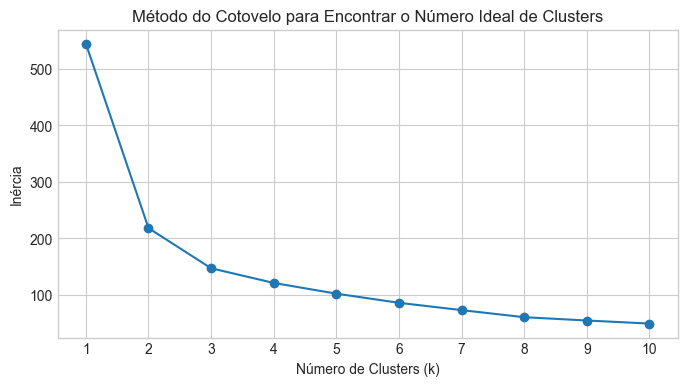

In [103]:
# --- 3. MÉTODO DO COTOVELO ---
inercia = []
range_clusters = range(1, 11)  # Vamos testar de 1 a 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dados_escalonados)
    inercia.append(kmeans.inertia_)

# Plotando o gráfico do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, inercia, marker="o")
plt.title("Método do Cotovelo para Encontrar o Número Ideal de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inércia")
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

In [104]:
# --- 4. RODANDO O MODELO FINAL ---
# Supondo que o número ideal de clusters que encontramos foi 3
numero_ideal_clusters = 3

kmeans_final = KMeans(n_clusters=numero_ideal_clusters, random_state=42, n_init=10)
kmeans_final.fit(dados_escalonados)

# Adicionando os rótulos dos clusters de volta ao nosso DataFrame
df_cluster["cluster"] = kmeans_final.labels_


# --- 5. INTERPRETAÇÃO DOS CLUSTERS (PROFILING) ---
# Este é o passo mais importante: entender o que cada cluster significa.
# Vamos agrupar por cluster e calcular a média de cada variável.
perfis_clusters = df_cluster.groupby("cluster").mean().round(2)

print("--- Perfis dos Clusters Encontrados ---")
print(perfis_clusters)

--- Perfis dos Clusters Encontrados ---
         Tempo_Final_seg  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA
cluster                                                                                                                         
0               36414.87                                 -0.15                   729.28             1284.11               821.48
1               27812.03                                 -0.07                   473.29              962.87               647.21
2               19575.72                                 -0.22                   270.22              655.64               469.38


In [105]:
# --- 4. RODANDO O MODELO FINAL ---
# Supondo que o número ideal de clusters que encontramos foi 3
numero_ideal_clusters = 4

kmeans_final = KMeans(n_clusters=numero_ideal_clusters, random_state=42, n_init=10)
kmeans_final.fit(dados_escalonados)

# Adicionando os rótulos dos clusters de volta ao nosso DataFrame
df_cluster["cluster"] = kmeans_final.labels_


# --- 5. INTERPRETAÇÃO DOS CLUSTERS (PROFILING) ---
# Este é o passo mais importante: entender o que cada cluster significa.
# Vamos agrupar por cluster e calcular a média de cada variável.
perfis_clusters = df_cluster.groupby("cluster").mean().round(2)

print("--- Perfis dos Clusters Encontrados ---")
print(perfis_clusters)

--- Perfis dos Clusters Encontrados ---
         Tempo_Final_seg  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA
cluster                                                                                                                         
0               30920.55                                 -0.12                   560.84             1089.09               696.86
1               23152.81                                 -0.08                   359.93              782.43               562.58
2               19138.27                                 -0.25                   259.42              640.91               455.15
3               37460.33                                 -0.15                   752.88             1317.87               848.04


In [106]:
df_cluster["cluster"].value_counts()

cluster
2    44
1    27
0    20
3    18
Name: count, dtype: int64

##### Analisando os clusters

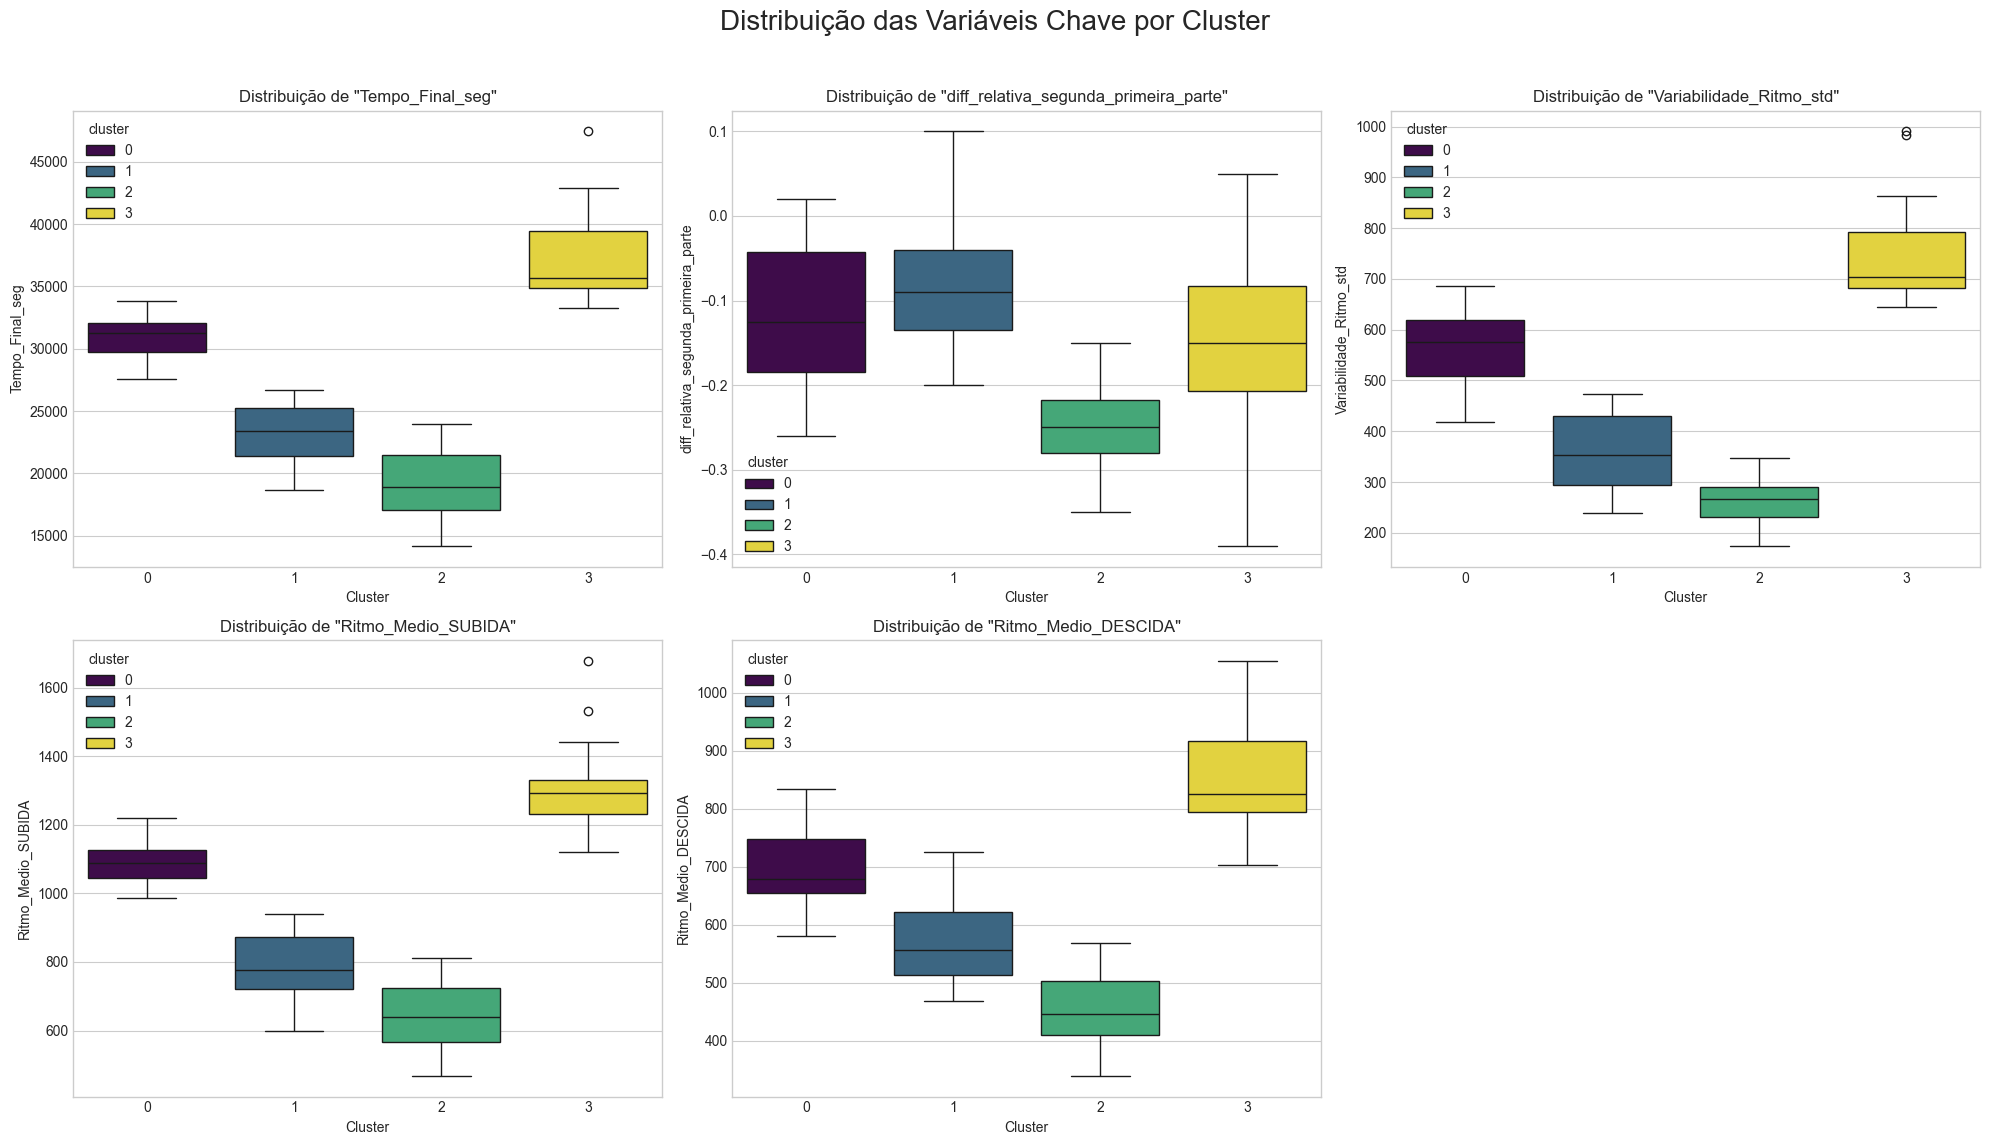

In [107]:
features_usadas = [
    "Tempo_Final_seg",
    "diff_relativa_segunda_primeira_parte",
    "Variabilidade_Ritmo_std",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))

# Título principal para todos os gráficos
fig.suptitle("Distribuição das Variáveis Chave por Cluster", fontsize=20)


# 3. "Achate" o array de eixos para facilitar o loop
# O 'axes' é uma matriz 2x3. axes.flatten() o transforma em uma lista simples [ax1, ax2, ..., ax6]
axes = axes.flatten()


# 4. Faça o loop, associando cada feature a um eixo
for i, feature in enumerate(features_usadas):
    # O parâmetro 'ax=axes[i]' diz ao seaborn para desenhar no subplot correto
    sns.boxplot(
        data=df_cluster,
        x="cluster",
        y=feature,
        hue="cluster",
        palette="viridis",
        ax=axes[i],
    )

    # Use ax.set_title() em vez de plt.title()
    axes[i].set_title(f'Distribuição de "{feature}"')
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)


# 5. Como temos uma grade 2x3 (6 posições) e apenas 5 gráficos, vamos esconder o último eixo vazio
fig.delaxes(axes[5])


# 6. Ajuste o layout para evitar sobreposição de títulos e exiba o gráfico
plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # rect ajusta para o suptitle caber
plt.show()

**Cluster 2 (Verde)**: Elite / Atletas de Alta Performance - 44 Individuos
Este é inequivocamente o grupo de elite da prova. Eles se destacam em todas as métricas analisadas.

- *Performance Geral*: Com o menor tempo final médio (19138s), este grupo, como visto no boxplot, está em uma categoria própria, com o box inteiro posicionado bem abaixo dos outros.

- *Gestão e Consistência*: Eles não são apenas rápidos, mas também os mais consistentes, com a menor Variabilidade_Ritmo_std (259s). Além disso, apresentam a maior diff_relativa negativa (-0.25), indicando que são os mais eficientes em gerenciar a energia na primeira metade difícil para capitalizar na segunda metade mais fácil.

- *Habilidade em Terreno*: Dominam todos os terrenos, sendo os mais rápidos tanto em subidas (ritmo médio de 640s) quanto em descidas (455s).

> *Persona*: O corredor de elite. Completo, estratégico, consistente e superior em todos os aspectos técnicos da corrida de montanha.

**Cluster 1 (Azul)**: Amadores Avançados / Ritmo Forte - 27 Individuos
Este grupo representa o pelotão da frente dos corredores amadores, um grupo forte que persegue a elite.

- *Performance Geral*: Possuem o segundo melhor tempo final médio (23152s), posicionando-se claramente entre a elite e o restante dos competidores. São também o segundo grupo mais consistente (Variabilidade_Ritmo_std de 359s).

- *Gestão e Consistência*: A principal característica deste grupo é sua ''diff_relativa' próxima de zero (-0.08). Eles são os que menos aceleram, proporcionalmente, na segunda metade. Isso sugere uma estratégia de "força bruta", onde mantêm um ritmo muito forte desde o início, inclusive na parte difícil, o que lhes garante um bom tempo final, mas com menos "sobra" para acelerar no final.

- *Habilidade em Terreno*: São competentes em todos os terrenos, com o segundo melhor ritmo médio em subidas e descidas.

> *Persona*: O competidor amador forte. Rápido e consistente, adota uma estratégia de ritmo forte o tempo todo, com menor variação entre as metades da prova.

**Cluster 0 (Roxo)**: Intermediários / Meio do Pelotão - 20 individuos
Este cluster representa o coração da prova, o maior grupo de corredores que completam o desafio em um tempo respeitável.

- *Performance Geral*: Com um tempo final médio de 30920s, eles formam o pelotão intermediário. Sua variabilidade de ritmo (560s) é moderada, superior à dos grupos mais rápidos.

- *Gestão e *Consistência*: Apresentam uma diff_relativa de -0.12, um valor intermediário que representa um comportamento "padrão" de desaceleração na parte difícil e aceleração na parte fácil, mas sem a mesma eficiência dos grupos de ponta.

- *Habilidade em Terreno*: Como esperado, seus ritmos em subida (1089s) e descida (696s) são intermediários, mostrando uma performance sólida, mas sem a especialização dos atletas mais rápidos. O boxplot para este grupo é visivelmente mais "alto", indicando maior diversidade de níveis dentro deste mesmo cluster.

> *Persona*: O corredor intermediário. Completa a prova com solidez, mas com mais oscilações de ritmo e sem a mesma capacidade de resposta nos diferentes terrenos que os atletas de ponta.

**Cluster 3 (Azul)**: Recreacionais / Gestão de Sobrevivência -18 Individuos
Este grupo representa os atletas cujo principal objetivo é completar o percurso, gerenciando o esforço para cruzar a linha de chegada.

- *Performance Geral*: São o grupo com o maior tempo final médio (37460s).

- *Gestão e Consistência*: A característica que mais os define é a altíssima Variabilidade_Ritmo_std (752s). O boxplot desta variável para o Cluster 3 é extremamente alto e destacado dos demais, sugerindo uma estratégia que alterna muito entre caminhada (especialmente nas subidas) e corrida.

- *Habilidade em Terreno*: Consequentemente, possuem o ritmo médio mais lento em subidas (1317s) e descidas (848s). Sua diff_relativa (-0.15) é relativamente alta porque, ao caminhar muito lentamente na primeira metade difícil, eles têm uma margem enorme para "acelerar" (mesmo que para um trote leve) na segunda metade.

> *Persona*: O corredor recreacional. Focado em terminar a prova, utiliza uma estratégia de ritmo controlado (corrida/caminhada) para gerenciar a energia ao longo do percurso desafiador, resultando em alta variabilidade de ritmo.

### Clusterizando com mais Variáveis

In [108]:
df_cluster2 = pd.read_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_cluster2.set_index("Nome Atleta", inplace=True)
df_cluster2.columns

Index(['Unnamed: 0', 'sexo', 'faixa_etaria', 'peso', 'Tempo_Final_seg', 'Ritmo_Medio_seg', 'Variabilidade_Ritmo_std', 'Variabilidade_Ritmo_min_std', 'Ritmo_Medio_Primeira_Metade', 'Ritmo_Medio_Segunda_Metade', 'Tempo_Total_Primeira_Metade', 'Tempo_Total_Segunda_Metade', 'Diferenca_Media_Seg_Menos_Pri', 'Diferenca_total_Seg_Menos_Pri', 'diff_relativa_segunda_primeira_parte', 'Ritmo_Medio_Trecho_0-5_km', 'Ritmo_Medio_Trecho_5-10_km', 'Ritmo_Medio_Trecho_10-15_km', 'Ritmo_Medio_Trecho_15-20_km', 'Ritmo_Medio_Trecho_20-25_km', 'Ritmo_Medio_Trecho_25-30_km', 'Ritmo_Medio_Trecho_30-35_km', 'Ritmo_Medio_Trecho_35-40_km', 'Tempo_Total_Trecho_0-5_km', 'Tempo_Total_Trecho_5-10_km', 'Tempo_Total_Trecho_10-15_km', 'Tempo_Total_Trecho_15-20_km', 'Tempo_Total_Trecho_20-25_km', 'Tempo_Total_Trecho_25-30_km', 'Tempo_Total_Trecho_30-35_km', 'Tempo_Total_Trecho_35-40_km', 'Ritmo_Medio_DESCIDA', 'Ritmo_Medio_MISTO', 'Ritmo_Medio_PLANO', 'Ritmo_Medio_SUBIDA', 'Tempo_Total_DESCIDA', 'Tempo_Total_MISTO',
  

In [109]:
df_cluster2.head()

,Unnamed: 0,sexo,faixa_etaria,peso,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_5-10_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,Ritmo_Medio_Trecho_35-40_km,Tempo_Total_Trecho_0-5_km,Tempo_Total_Trecho_5-10_km,Tempo_Total_Trecho_10-15_km,Tempo_Total_Trecho_15-20_km,Tempo_Total_Trecho_20-25_km,Tempo_Total_Trecho_25-30_km,Tempo_Total_Trecho_30-35_km,Tempo_Total_Trecho_35-40_km,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,indice_subida,indice_descida_vs_subida,indice_descida
Nome Atleta,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ALFREDO GUIMARAES,0,Homens,45 a 54,75 a 84 kg,21774,604.833333,290.291331,4.838189,667.777778,541.888889,12020,9754,-2.10,-37.76,-0.19,419.0,600.0,634.8,983.0,495.4,539.8,611.4,357.0,2095.0,3000.0,3174.0,4915.0,2477.0,2699.0,3057.0,357.0,522.933333,474.5,335.5,724.117647,7844,949,671,12310,0.197218,-0.277834,-0.135409
Albert Melo,1,Homens,25 a 34,75 a 84 kg,31986,888.500000,417.596832,6.959947,942.944444,834.055556,16973,15013,-1.82,-32.66,-0.12,599.8,898.8,825.4,1442.8,737.4,825.0,927.8,701.0,2999.0,4494.0,4127.0,7214.0,3687.0,4125.0,4639.0,701.0,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,0.164090,-0.236259,-0.110936
Alessandro Sousa(allê),2,Homens,45 a 54,65 a 74 kg,33826,939.611111,669.719569,11.161993,945.388889,933.833333,17017,16809,-0.20,-3.47,-0.01,508.2,694.2,748.0,2026.4,1284.6,717.6,732.0,271.0,2541.0,3471.0,3740.0,10132.0,6423.0,3588.0,3660.0,271.0,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,0.297721,-0.388802,-0.206835
Alex Junior Aj,3,Homens,20 a 24,65 a 74 kg,18496,513.777778,261.647539,4.360792,598.944444,428.611111,10781,7715,-2.84,-51.10,-0.28,366.2,532.2,568.6,869.4,404.2,445.6,478.2,174.0,1831.0,2661.0,2843.0,4347.0,2021.0,2228.0,2391.0,174.0,443.133333,434.0,224.5,619.529412,6647,868,449,10532,0.205831,-0.284726,-0.137500
Alexandre Santiago,4,Homens,35 a 44,55 a 64 kg,14626,417.885714,195.390826,3.256514,467.722222,365.117647,8419,6207,-1.71,-36.87,-0.22,316.6,413.0,448.6,658.6,313.8,373.0,401.6,NaN,1583.0,2065.0,2243.0,3293.0,1569.0,1865.0,2008.0,NaN,366.466667,352.0,267.0,479.882353,5497,704,267,8158,0.148358,-0.236341,-0.123046


In [110]:
features_para_cluster = [
    "Tempo_Final_seg",
    "Ritmo_Medio_Primeira_Metade",
    "Ritmo_Medio_Segunda_Metade",
    "Ritmo_Medio_Trecho_0-5_km",
    "Ritmo_Medio_Trecho_5-10_km",
    "Ritmo_Medio_Trecho_10-15_km",
    "Ritmo_Medio_Trecho_15-20_km",
    "Ritmo_Medio_Trecho_20-25_km",
    "Ritmo_Medio_Trecho_25-30_km",
    "Ritmo_Medio_Trecho_30-35_km",
    "diff_relativa_segunda_primeira_parte",
    "Variabilidade_Ritmo_std",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
    "indice_subida",
    "indice_descida_vs_subida",
    "indice_descida",
]

# Criando um novo DataFrame apenas com as features selecionadas e sem dados faltantes
df_cluster2 = df_cluster2[features_para_cluster].dropna()

# Guardando os nomes dos atletas (o índice) para usarmos depois
nomes_atletas = df_cluster2.index

# --- 2. ESCALONAMENTO DOS DADOS (PASSO OBRIGATÓRIO) ---
# Todas as variáveis precisam estar na mesma escala de importância
scaler = StandardScaler()
dados_escalonados = scaler.fit_transform(df_cluster2)

print("Dados prontos e escalonados! Próximo passo: encontrar o número de clusters.")

Dados prontos e escalonados! Próximo passo: encontrar o número de clusters.


In [111]:
df_cluster2.columns

Index(['Tempo_Final_seg', 'Ritmo_Medio_Primeira_Metade', 'Ritmo_Medio_Segunda_Metade', 'Ritmo_Medio_Trecho_0-5_km', 'Ritmo_Medio_Trecho_5-10_km', 'Ritmo_Medio_Trecho_10-15_km', 'Ritmo_Medio_Trecho_15-20_km', 'Ritmo_Medio_Trecho_20-25_km', 'Ritmo_Medio_Trecho_25-30_km', 'Ritmo_Medio_Trecho_30-35_km', 'diff_relativa_segunda_primeira_parte', 'Variabilidade_Ritmo_std', 'Ritmo_Medio_SUBIDA', 'Ritmo_Medio_DESCIDA', 'indice_subida', 'indice_descida_vs_subida', 'indice_descida'], dtype='object')

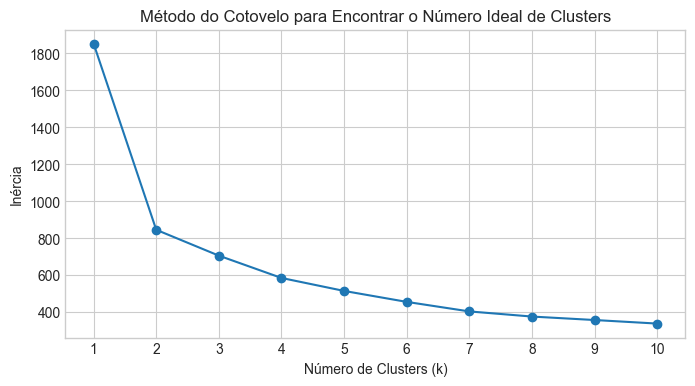

In [112]:
# --- 3. MÉTODO DO COTOVELO ---
inercia = []
range_clusters = range(1, 11)  # Vamos testar de 1 a 10 clusters

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(dados_escalonados)
    inercia.append(kmeans.inertia_)

# Plotando o gráfico do cotovelo
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, inercia, marker="o")
plt.title("Método do Cotovelo para Encontrar o Número Ideal de Clusters")
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Inércia")
plt.xticks(range_clusters)
plt.grid(True)
plt.show()

In [113]:
# --- 4. RODANDO O MODELO FINAL ---
# Supondo que o número ideal de clusters que encontramos foi 3
numero_ideal_clusters = 4

kmeans_final = KMeans(n_clusters=numero_ideal_clusters, random_state=42, n_init=10)
kmeans_final.fit(dados_escalonados)

# Adicionando os rótulos dos clusters de volta ao nosso DataFrame
labels_cluster = kmeans_final.labels_
df_resultados_cluster = pd.DataFrame({"cluster": labels_cluster}, index=nomes_atletas)

df_cluster2_com_labels = df_cluster2.merge(
    df_resultados_cluster, left_index=True, right_index=True, how="left"
)


# --- 5. INTERPRETAÇÃO DOS CLUSTERS (PROFILING) ---
# Este é o passo mais importante: entender o que cada cluster significa.
# Vamos agrupar por cluster e calcular a média de cada variável.
perfis_clusters = df_cluster2_com_labels.groupby("cluster").mean().round(2)

print("--- Perfis dos Clusters Encontrados ---")
print(perfis_clusters)

--- Perfis dos Clusters Encontrados ---
         Tempo_Final_seg  Ritmo_Medio_Primeira_Metade  Ritmo_Medio_Segunda_Metade  Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km  diff_relativa_segunda_primeira_parte  Variabilidade_Ritmo_std  Ritmo_Medio_SUBIDA  Ritmo_Medio_DESCIDA  indice_subida  indice_descida_vs_subida  indice_descida
cluster                                                                                                                                                                                                                                                                                                                                                                                                                                                   
0               22871.56                       695.53                     

In [114]:
df_cluster2_com_labels.head()

,Tempo_Final_seg,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_5-10_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,diff_relativa_segunda_primeira_parte,Variabilidade_Ritmo_std,Ritmo_Medio_SUBIDA,Ritmo_Medio_DESCIDA,indice_subida,indice_descida_vs_subida,indice_descida,cluster
Nome Atleta,,,,,,,,,,,,,,,,,,
ALFREDO GUIMARAES,21774,667.777778,541.888889,419.0,600.0,634.8,983.0,495.4,539.8,611.4,-0.19,290.291331,724.117647,522.933333,0.197218,-0.277834,-0.135409,0
Albert Melo,31986,942.944444,834.055556,599.8,898.8,825.4,1442.8,737.4,825.0,927.8,-0.12,417.596832,1034.294118,789.933333,0.164090,-0.236259,-0.110936,2
Alessandro Sousa(allê),33826,945.388889,933.833333,508.2,694.2,748.0,2026.4,1284.6,717.6,732.0,-0.01,669.719569,1219.352941,745.266667,0.297721,-0.388802,-0.206835,1
Alex Junior Aj,18496,598.944444,428.611111,366.2,532.2,568.6,869.4,404.2,445.6,478.2,-0.28,261.647539,619.529412,443.133333,0.205831,-0.284726,-0.137500,3
Alexandre Santiago,14626,467.722222,365.117647,316.6,413.0,448.6,658.6,313.8,373.0,401.6,-0.22,195.390826,479.882353,366.466667,0.148358,-0.236341,-0.123046,3


In [115]:
df_cluster2_com_labels["cluster"].value_counts()

cluster
0    34
3    34
1    24
2    17
Name: count, dtype: int64

##### Analisando os clusters

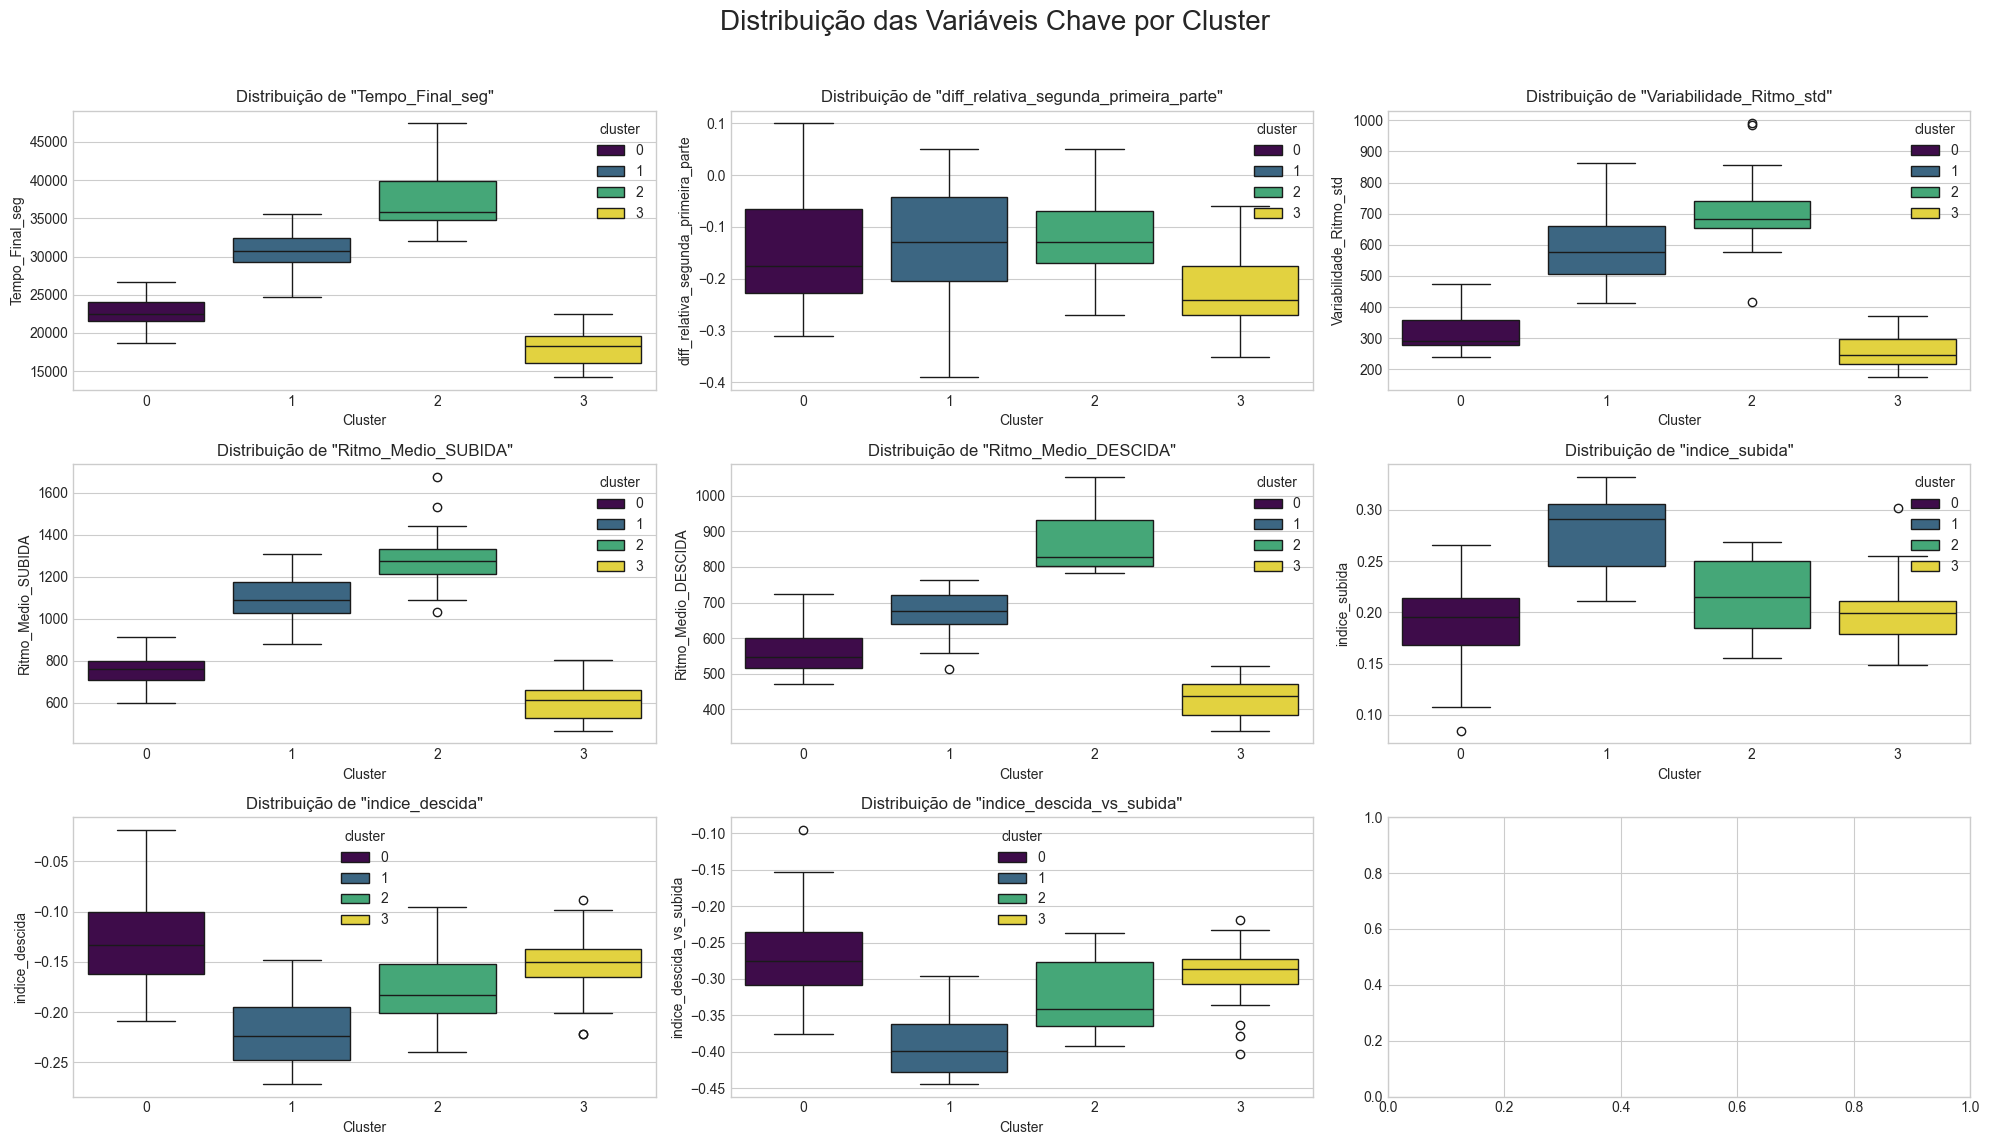

In [116]:
features_usadas = [
    "Tempo_Final_seg",
    "diff_relativa_segunda_primeira_parte",
    "Variabilidade_Ritmo_std",
    "Ritmo_Medio_SUBIDA",
    "Ritmo_Medio_DESCIDA",
    "indice_subida",
    "indice_descida",
    "indice_descida_vs_subida",
]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 12))

# Título principal para todos os gráficos
fig.suptitle("Distribuição das Variáveis Chave por Cluster", fontsize=20)


# 3. "Achate" o array de eixos para facilitar o loop
# O 'axes' é uma matriz 2x3. axes.flatten() o transforma em uma lista simples [ax1, ax2, ..., ax6]
axes = axes.flatten()


# 4. Faça o loop, associando cada feature a um eixo
for i, feature in enumerate(features_usadas):
    # O parâmetro 'ax=axes[i]' diz ao seaborn para desenhar no subplot correto
    sns.boxplot(
        data=df_cluster2_com_labels,
        x="cluster",
        y=feature,
        hue="cluster",
        palette="viridis",
        ax=axes[i],
    )

    # Use ax.set_title() em vez de plt.title()
    axes[i].set_title(f'Distribuição de "{feature}"')
    axes[i].set_xlabel("Cluster")
    axes[i].set_ylabel(feature)


# 6. Ajuste o layout para evitar sobreposição de títulos e exiba o gráfico
plt.tight_layout(rect=[0, 0.03, 1, 0.96])  # rect ajusta para o suptitle caber
plt.show()

A nova clusterização revelou quatro personas muito distintas, especialmente ao olharmos os novos índices que medem a especialização em subida e descida.

**Cluster 3 (Amarelo)**: A Elite Completa
- *Performance*: Continuam sendo o grupo mais rápido (Tempo_Final_seg de 18056s). Os boxplots mostram que eles estão em uma categoria à parte em termos de velocidade.

- *Consistência e Estratégia*: São os mais consistentes (menor Variabilidade_Ritmo_std) e os que melhor executam a estratégia do percurso (maior diff_relativa negativa).

- *Habilidade em Terreno*: A análise dos índices mostra que eles são simplesmente excelentes em tudo. Seus indice_subida (0.20) e indice_descida (-0.15) são baixos, indicando que, em relação ao seu próprio ritmo médio altíssimo, eles perdem pouco tempo subindo e ganham um tempo moderado descendo. São completos, sem pontos fracos.

> *Persona*: A Elite Completa. Rápidos, estratégicos e tecnicamente proficientes em todos os terrenos.

**Cluster 0 (Roxo)**: Os Escaladores
- *Performance*: São o segundo grupo mais rápido (Tempo_Final_seg de 22871s).

- *Consistência e Estratégia*: São muito consistentes (segunda menor variabilidade) e têm uma boa gestão de prova.

- *Habilidade em Terreno*: Aqui está a grande descoberta! Olhe para os índices. Eles têm o melhor indice_subida de todos (0.19), significando que são os que menos perdem tempo, proporcionalmente, nas subidas. Em contrapartida, têm o pior indice_descida (-0.13).

- *Interpretação*: Este grupo garante seu excelente resultado por ser excepcionalmente forte nas subidas. Eles não são os melhores descendo, mas sua força como escaladores os coloca no pódio dos amadores.

> *Persona*: Os Escaladores de Elite Amadora. Usam a força na subida como sua principal arma para garantir um tempo final baixo.

**Cluster 1 (Azul)**: Os Especialistas em Descida
- *Performance*: Formam o grupo intermediário rápido (Tempo_Final_seg de 30604s).

- *Consistência e Estratégia*: São o grupo com a maior quebra de ritmo (Variabilidade_Ritmo_std alta), o que é interessante.

- *Habilidade em Terreno*: O oposto do Cluster 0! Eles têm o pior indice_subida (0.28), mas o melhor indice_descida (-0.22) e, de longe, o melhor indice_descida_vs_subida (-0.39).

Interpretação: Este é o perfil do especialista em descida. Eles "sofrem" mais nas subidas, mas compensam com uma técnica e coragem excepcionais nas descidas, onde ganham muito tempo. Sua alta variabilidade pode ser explicada por essa grande diferença de ritmo entre subidas (lentas) e descidas (muito rápidas).

Persona: Os Descenders Destemidos. Atletas tecnicamente habilidosos que usam as descidas para construir sua performance.

Cluster 2 (Verde): Os Guerreiros Resistentes
Performance: São o grupo com o maior tempo final (Tempo_Final_seg de 37286s).

Consistência e Estratégia: Possuem a maior variabilidade, indicando um ritmo que alterna mais entre corrida e caminhada.

Habilidade em Terreno: São os mais lentos em todos os terrenos, mas seus índices (indice_subida de 0.22 e indice_descida de -0.17) mostram um perfil relativamente equilibrado. A principal característica deles não é uma especialização, mas sim um ritmo geral mais controlado para garantir a conclusão da prova.

Persona: Os Guerreiros Resistentes. Focados em completar o desafio, seu perfil é de resistência e perseverança, mais do que de especialização técnica.

Visualização

In [117]:
df_desnivel = df_segmentado[
    ["Trecho_5km", "desnivel_positivo", "desnivel_negativo"]
].drop_duplicates()

df_desnivel_positivo_por_faixa = (
    df_desnivel.groupby("Trecho_5km")
    .agg(
        {
            "desnivel_positivo": "sum",
            "desnivel_negativo": "sum",
        }
    )
    .stack(level=0)
)
df_desnivel_positivo_por_faixa

df_desnivel = df_desnivel_positivo_por_faixa.unstack().reset_index()
df_desnivel = df_desnivel[df_desnivel["Trecho_5km"] != "Trecho 35-40 km"]

df_desnivel["ordem_trecho"] = (
    df_desnivel["Trecho_5km"].str.extract(r"(\d+)").astype(int)
)

# 3. Ordena o DataFrame com base na nova coluna numérica.
df_desnivel = df_desnivel.sort_values(by="ordem_trecho")

# 4. Remove a coluna de ordenação temporária e reseta o índice para um resultado limpo.
df_desnivel = df_desnivel.drop(columns="ordem_trecho").reset_index(drop=True)

df_desnivel

,Trecho_5km,desnivel_positivo,desnivel_negativo
0,Trecho 0-5 km,246.0,-148.0
1,Trecho 5-10 km,367.0,-452.0
2,Trecho 10-15 km,473.0,-97.0
3,Trecho 15-20 km,996.0,-429.0
4,Trecho 20-25 km,453.0,-474.0
5,Trecho 25-30 km,43.0,-897.0
6,Trecho 30-35 km,201.0,-284.0


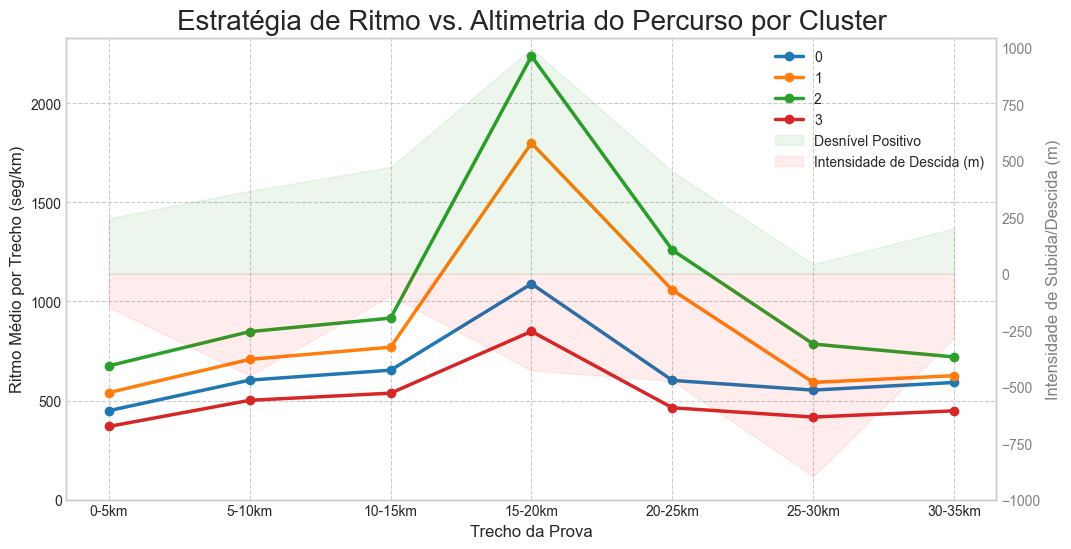

In [118]:
# Crie a figura e o primeiro eixo (para o ritmo)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Pegando apenas as colunas de ritmo por trecho da sua tabela de perfis
colunas_ritmo_trechos = [
    "Ritmo_Medio_Trecho_0-5_km",
    "Ritmo_Medio_Trecho_5-10_km",
    "Ritmo_Medio_Trecho_10-15_km",
    "Ritmo_Medio_Trecho_15-20_km",
    "Ritmo_Medio_Trecho_20-25_km",
    "Ritmo_Medio_Trecho_25-30_km",
    "Ritmo_Medio_Trecho_30-35_km",
]
perfis_ritmo = perfis_clusters[
    colunas_ritmo_trechos
].T  # .T para transpor (facilita o plot)

# Renomeando o índice para ficar mais claro
perfis_ritmo.index = [
    "0-5km",
    "5-10km",
    "10-15km",
    "15-20km",
    "20-25km",
    "25-30km",
    "30-35km",
]

# Plote o gráfico de linhas do ritmo no primeiro eixo (ax1)
perfis_ritmo.plot(
    ax=ax1, marker="o", linewidth=2.5, zorder=10
)  # zorder alto para ficar na frente

# Estética do eixo 1 (Ritmo)
ax1.set_title("Estratégia de Ritmo vs. Altimetria do Percurso por Cluster", fontsize=20)
ax1.set_xlabel("Trecho da Prova", fontsize=12)
ax1.set_ylabel("Ritmo Médio por Trecho (seg/km)", fontsize=12)
ax1.grid(True, linestyle="--", which="both")
ax1.legend(title="Cluster")
ax1.set_ylim(bottom=0)  # Garante que o eixo Y do ritmo comece no zero

# Crie o segundo eixo (para o desnível)
ax2 = ax1.twinx()

# Plote o GRÁFICO DE ÁREA do desnível no segundo eixo (ax2)
ax2.fill_between(
    df_desnivel.index,
    df_desnivel["desnivel_positivo"],
    y2=0,  # Linha base do preenchimento
    color="green",
    alpha=0.07,
    label="Desnível Positivo",
    zorder=0,  # zorder baixo para ficar no fundo
)

# Estética do eixo 2 (Desnível)
ax2.set_ylabel("Desnível Positivo Acumulado (m)", color="gray", fontsize=12)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.grid(False)
ax2.set_ylim(bottom=-100)  # Garante que o eixo Y do desnível comece no zero

# Plotando a ÁREA para DESNÍVEL NEGATIVO (Descidas)
ax2.fill_between(
    df_desnivel.index,
    df_desnivel["desnivel_negativo"],
    y2=0,
    color="red",  # Cor diferente para as descidas
    alpha=0.07,
    label="Intensidade de Descida (m)",
    zorder=0,
)

ax2.set_ylabel("Intensidade de Subida/Descida (m)", color="gray", fontsize=12)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.grid(False)
ax2.set_ylim(bottom=-1000)

# Unificar as legendas
lines, labels = ax1.get_legend_handles_labels()
areas, area_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + areas, labels + area_labels, loc="upper right")

plt.show()

**Observações Chave:**
- O "Pico da Morte" (km 15-20): A área verde mostra que o trecho entre 15 e 20 km é, de longe, a subida mais brutal. É neste ponto que a performance de todos os grupos é testada ao limite e as maiores diferenças de tempo são criadas. A separação entre as linhas dos clusters atinge seu máximo aqui.

- A Recompensa (km 20-30): Imediatamente após a grande subida, o percurso oferece uma longa seção de descida, indicada pela área vermelha. É aqui que os atletas com melhor técnica de descida podem recuperar tempo.

**Visualizando os Especialistas:**

- Cluster 0 (Azul - Escaladores): No pico da subida (15-20km), a linha azul se afasta e fica bem abaixo da laranja, mostrando sua superioridade como escaladores em relação ao outro grupo amador rápido.

- Cluster 1 (Laranja - Descenders): Observe como, após o pico, a linha laranja mergulha acentuadamente nos trechos de descida (20-30km), quase alcançando a linha azul. Isso visualiza perfeitamente sua especialidade: eles recuperam nas descidas o tempo que perderam nas subidas.

- A Dominância e Consistência da Elite (Cluster 3 - Vermelho): A linha vermelha não é apenas a mais baixa (rápida) em todos os pontos. Sua "curva" no pico da subida é visivelmente menos acentuada que a dos outros. Eles sofrem menos no trecho mais difícil e se recuperam de forma mais eficiente, demonstrando um nível de condicionamento superior.

- A Realidade do Pelotão (Cluster 2 - Verde): A linha verde mostra a história da maioria dos corredores de montanha. O pico de ritmo na grande subida é extremo, representando uma transição para a caminhada. Eles sobrevivem à subida e recuperam o ritmo nos trechos mais fáceis, focados em completar o percurso.

**Em resumo, este único gráfico confirma que a prova é definida pela forma como cada atleta gerencia a grande subida no meio do percurso e capitaliza na seção de descida subsequente, validando perfeitamente os perfis de "Elite", "Escaladores", "Descenders" e "Guerreiros" que a clusterização revelou.**

In [119]:
perfis_sexo = (
    df_final_completo_split_5km[
        [
            "sexo",
            "Ritmo_Medio_Trecho_0-5_km",
            "Ritmo_Medio_Trecho_5-10_km",
            "Ritmo_Medio_Trecho_10-15_km",
            "Ritmo_Medio_Trecho_15-20_km",
            "Ritmo_Medio_Trecho_20-25_km",
            "Ritmo_Medio_Trecho_25-30_km",
            "Ritmo_Medio_Trecho_30-35_km",
        ]
    ]
    .groupby("sexo")
    .mean()
    .round(2)
)

print("--- Perfis por Sexo ---")
print(perfis_sexo)

--- Perfis por Sexo ---
          Ritmo_Medio_Trecho_0-5_km  Ritmo_Medio_Trecho_5-10_km  Ritmo_Medio_Trecho_10-15_km  Ritmo_Medio_Trecho_15-20_km  Ritmo_Medio_Trecho_20-25_km  Ritmo_Medio_Trecho_25-30_km  Ritmo_Medio_Trecho_30-35_km
sexo                                                                                                                                                                                                            
Homens                       454.39                      601.67                       651.80                      1285.22                       730.17                       542.65                       567.08
Mulheres                     542.17                      710.00                       763.68                      1513.28                       840.65                       585.97                       592.34


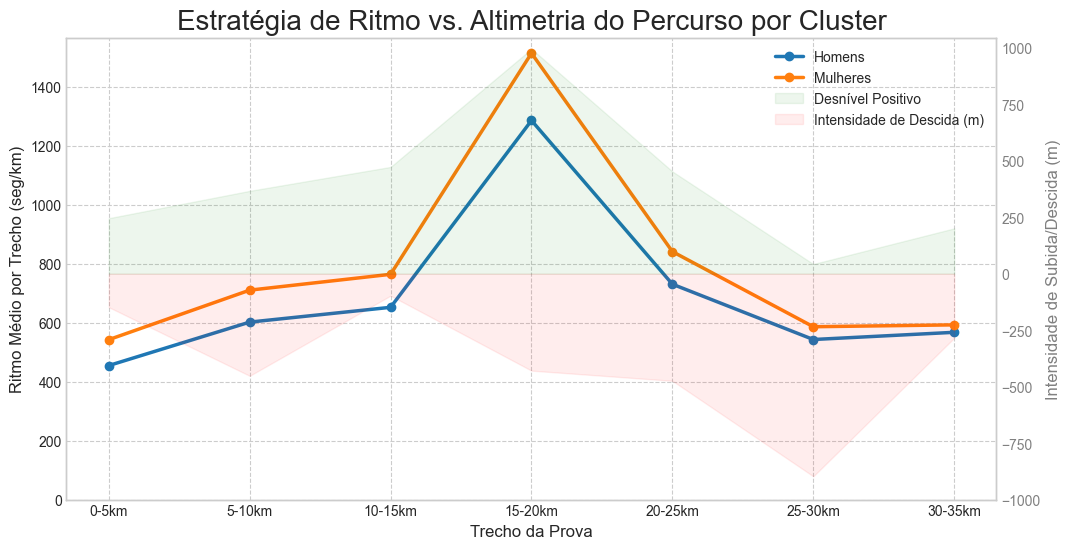

In [120]:
# Crie a figura e o primeiro eixo (para o ritmo)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Pegando apenas as colunas de ritmo por trecho da sua tabela de perfis
colunas_ritmo_trechos = [
    "Ritmo_Medio_Trecho_0-5_km",
    "Ritmo_Medio_Trecho_5-10_km",
    "Ritmo_Medio_Trecho_10-15_km",
    "Ritmo_Medio_Trecho_15-20_km",
    "Ritmo_Medio_Trecho_20-25_km",
    "Ritmo_Medio_Trecho_25-30_km",
    "Ritmo_Medio_Trecho_30-35_km",
]
perfis_ritmo_sexo = perfis_sexo[
    colunas_ritmo_trechos
].T  # .T para transpor (facilita o plot)

# Renomeando o índice para ficar mais claro
perfis_ritmo_sexo.index = [
    "0-5km",
    "5-10km",
    "10-15km",
    "15-20km",
    "20-25km",
    "25-30km",
    "30-35km",
]

# Plote o gráfico de linhas do ritmo no primeiro eixo (ax1)
perfis_ritmo_sexo.plot(
    ax=ax1, marker="o", linewidth=2.5, zorder=10
)  # zorder alto para ficar na frente

# Estética do eixo 1 (Ritmo)
ax1.set_title("Estratégia de Ritmo vs. Altimetria do Percurso por Cluster", fontsize=20)
ax1.set_xlabel("Trecho da Prova", fontsize=12)
ax1.set_ylabel("Ritmo Médio por Trecho (seg/km)", fontsize=12)
ax1.grid(True, linestyle="--", which="both")
ax1.legend(title="Cluster")
ax1.set_ylim(bottom=0)  # Garante que o eixo Y do ritmo comece no zero

# Crie o segundo eixo (para o desnível)
ax2 = ax1.twinx()

# Plote o GRÁFICO DE ÁREA do desnível no segundo eixo (ax2)
ax2.fill_between(
    df_desnivel.index,
    df_desnivel["desnivel_positivo"],
    y2=0,  # Linha base do preenchimento
    color="green",
    alpha=0.07,
    label="Desnível Positivo",
    zorder=0,  # zorder baixo para ficar no fundo
)

# Estética do eixo 2 (Desnível)
ax2.set_ylabel("Desnível Positivo Acumulado (m)", color="gray", fontsize=12)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.grid(False)
ax2.set_ylim(bottom=-100)  # Garante que o eixo Y do desnível comece no zero

# Plotando a ÁREA para DESNÍVEL NEGATIVO (Descidas)
ax2.fill_between(
    df_desnivel.index,
    df_desnivel["desnivel_negativo"],
    y2=0,
    color="red",  # Cor diferente para as descidas
    alpha=0.07,
    label="Intensidade de Descida (m)",
    zorder=0,
)

ax2.set_ylabel("Intensidade de Subida/Descida (m)", color="gray", fontsize=12)
ax2.tick_params(axis="y", labelcolor="gray")
ax2.grid(False)
ax2.set_ylim(bottom=-1000)

# Unificar as legendas
lines, labels = ax1.get_legend_handles_labels()
areas, area_labels = ax2.get_legend_handles_labels()
ax1.legend(lines + areas, labels + area_labels, loc="upper right")

plt.show()

## Regressão Linear

**Os Pressupostos da Regressão Linear Múltipla**
Antes de confiarmos nos resultados de uma regressão, precisamos verificar alguns pressupostos. Se eles forem violados, nossas conclusões podem ser inválidas. Os principais são:

- Linearidade: A relação entre as variáveis independentes (preditoras) e a variável dependente (alvo) deve ser linear. Podemos fazer uma verificação inicial com gráficos de dispersão (scatterplot) entre cada variável preditora e o Tempo_Final_seg.

- Independência dos Resíduos: Os resíduos (a diferença entre os valores observados e os previstos pelo modelo) devem ser independentes uns dos outros. Isso é especialmente importante em dados com estrutura temporal ou espacial. Em seu caso, como cada linha representa um atleta diferente, este pressuposto geralmente é satisfeito. O teste de Durbin-Watson é comumente usado para verificar isso.

- Homocedasticidade (Variância Constante dos Resíduos): A variância dos resíduos deve ser constante para todos os níveis das variáveis independentes. Em outras palavras, a dispersão dos erros não deve aumentar ou diminuir à medida que os valores previstos mudam. A violação deste pressuposto chama-se heterocedasticidade. Podemos verificar isso visualmente com um gráfico de resíduos vs. valores previstos ou com testes estatísticos como o de Breusch-Pagan.

- Normalidade dos Resíduos: Os resíduos do modelo devem seguir uma distribuição normal. Isso é crucial para a validade dos testes de hipótese (testes t e F) sobre os coeficientes do modelo. Podemos avaliar a normalidade com um histograma dos resíduos, um Q-Q Plot ou testes formais como Shapiro-Wilk.

- Ausência de Multicolinearidade Perfeita: As variáveis independentes não devem ser perfeitamente correlacionadas entre si. Uma multicolinearidade alta (não necessariamente perfeita) também é um problema, pois infla a variância dos coeficientes de regressão, tornando-os instáveis e difíceis de interpretar. O Fator de Inflação de Variância (VIF) é a métrica padrão para diagnosticar isso.

#### Preparação dos Dados

Juntando nossas base completa com todos dados em segundos com nossa base onde estão nossos clusters

In [121]:
df_geral_segundos = pd.read_csv("Dados/df_selecionado_segundos.csv", sep=";")
df_geral_segundos = df_geral_segundos.drop(columns=["Unnamed: 0"])
df_geral_segundos.head()

,Nome Atleta,sexo,faixa_etaria,peso,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_5-10_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,Ritmo_Medio_Trecho_35-40_km,Tempo_Total_Trecho_0-5_km,Tempo_Total_Trecho_5-10_km,Tempo_Total_Trecho_10-15_km,Tempo_Total_Trecho_15-20_km,Tempo_Total_Trecho_20-25_km,Tempo_Total_Trecho_25-30_km,Tempo_Total_Trecho_30-35_km,Tempo_Total_Trecho_35-40_km,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,indice_subida,indice_descida_vs_subida,indice_descida
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,21774,604.833333,290.291331,4.838189,667.777778,541.888889,12020,9754,-2.10,-37.76,-0.19,419.0,600.0,634.8,983.0,495.4,539.8,611.4,357.0,2095.0,3000.0,3174.0,4915.0,2477.0,2699.0,3057.0,357.0,522.933333,474.5,335.5,724.117647,7844,949,671,12310,0.197218,-0.277834,-0.135409
1,Albert Melo,Homens,25 a 34,75 a 84 kg,31986,888.500000,417.596832,6.959947,942.944444,834.055556,16973,15013,-1.82,-32.66,-0.12,599.8,898.8,825.4,1442.8,737.4,825.0,927.8,701.0,2999.0,4494.0,4127.0,7214.0,3687.0,4125.0,4639.0,701.0,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,0.164090,-0.236259,-0.110936
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,33826,939.611111,669.719569,11.161993,945.388889,933.833333,17017,16809,-0.20,-3.47,-0.01,508.2,694.2,748.0,2026.4,1284.6,717.6,732.0,271.0,2541.0,3471.0,3740.0,10132.0,6423.0,3588.0,3660.0,271.0,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,0.297721,-0.388802,-0.206835
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,18496,513.777778,261.647539,4.360792,598.944444,428.611111,10781,7715,-2.84,-51.10,-0.28,366.2,532.2,568.6,869.4,404.2,445.6,478.2,174.0,1831.0,2661.0,2843.0,4347.0,2021.0,2228.0,2391.0,174.0,443.133333,434.0,224.5,619.529412,6647,868,449,10532,0.205831,-0.284726,-0.137500
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,14626,417.885714,195.390826,3.256514,467.722222,365.117647,8419,6207,-1.71,-36.87,-0.22,316.6,413.0,448.6,658.6,313.8,373.0,401.6,NaN,1583.0,2065.0,2243.0,3293.0,1569.0,1865.0,2008.0,NaN,366.466667,352.0,267.0,479.882353,5497,704,267,8158,0.148358,-0.236341,-0.123046


In [122]:
df_cluster2_com_labels.reset_index(inplace=True)
df_cluster2_com_labels.head()

,Nome Atleta,Tempo_Final_seg,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_5-10_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,diff_relativa_segunda_primeira_parte,Variabilidade_Ritmo_std,Ritmo_Medio_SUBIDA,Ritmo_Medio_DESCIDA,indice_subida,indice_descida_vs_subida,indice_descida,cluster
0,ALFREDO GUIMARAES,21774,667.777778,541.888889,419.0,600.0,634.8,983.0,495.4,539.8,611.4,-0.19,290.291331,724.117647,522.933333,0.197218,-0.277834,-0.135409,0
1,Albert Melo,31986,942.944444,834.055556,599.8,898.8,825.4,1442.8,737.4,825.0,927.8,-0.12,417.596832,1034.294118,789.933333,0.164090,-0.236259,-0.110936,2
2,Alessandro Sousa(allê),33826,945.388889,933.833333,508.2,694.2,748.0,2026.4,1284.6,717.6,732.0,-0.01,669.719569,1219.352941,745.266667,0.297721,-0.388802,-0.206835,1
3,Alex Junior Aj,18496,598.944444,428.611111,366.2,532.2,568.6,869.4,404.2,445.6,478.2,-0.28,261.647539,619.529412,443.133333,0.205831,-0.284726,-0.137500,3
4,Alexandre Santiago,14626,467.722222,365.117647,316.6,413.0,448.6,658.6,313.8,373.0,401.6,-0.22,195.390826,479.882353,366.466667,0.148358,-0.236341,-0.123046,3


In [123]:
df_final_com_clusters = pd.merge(
    left=df_geral_segundos,
    right=df_cluster2_com_labels[["Nome Atleta", "cluster"]],
    left_on="Nome Atleta",
    right_on="Nome Atleta",
    how="left",
)
df_final_com_clusters.head()

,Nome Atleta,sexo,faixa_etaria,peso,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_5-10_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,Ritmo_Medio_Trecho_35-40_km,Tempo_Total_Trecho_0-5_km,Tempo_Total_Trecho_5-10_km,Tempo_Total_Trecho_10-15_km,Tempo_Total_Trecho_15-20_km,Tempo_Total_Trecho_20-25_km,Tempo_Total_Trecho_25-30_km,Tempo_Total_Trecho_30-35_km,Tempo_Total_Trecho_35-40_km,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,indice_subida,indice_descida_vs_subida,indice_descida,cluster
0,ALFREDO GUIMARAES,Homens,45 a 54,75 a 84 kg,21774,604.833333,290.291331,4.838189,667.777778,541.888889,12020,9754,-2.10,-37.76,-0.19,419.0,600.0,634.8,983.0,495.4,539.8,611.4,357.0,2095.0,3000.0,3174.0,4915.0,2477.0,2699.0,3057.0,357.0,522.933333,474.5,335.5,724.117647,7844,949,671,12310,0.197218,-0.277834,-0.135409,0
1,Albert Melo,Homens,25 a 34,75 a 84 kg,31986,888.500000,417.596832,6.959947,942.944444,834.055556,16973,15013,-1.82,-32.66,-0.12,599.8,898.8,825.4,1442.8,737.4,825.0,927.8,701.0,2999.0,4494.0,4127.0,7214.0,3687.0,4125.0,4639.0,701.0,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,0.164090,-0.236259,-0.110936,2
2,Alessandro Sousa(allê),Homens,45 a 54,65 a 74 kg,33826,939.611111,669.719569,11.161993,945.388889,933.833333,17017,16809,-0.20,-3.47,-0.01,508.2,694.2,748.0,2026.4,1284.6,717.6,732.0,271.0,2541.0,3471.0,3740.0,10132.0,6423.0,3588.0,3660.0,271.0,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,0.297721,-0.388802,-0.206835,1
3,Alex Junior Aj,Homens,20 a 24,65 a 74 kg,18496,513.777778,261.647539,4.360792,598.944444,428.611111,10781,7715,-2.84,-51.10,-0.28,366.2,532.2,568.6,869.4,404.2,445.6,478.2,174.0,1831.0,2661.0,2843.0,4347.0,2021.0,2228.0,2391.0,174.0,443.133333,434.0,224.5,619.529412,6647,868,449,10532,0.205831,-0.284726,-0.137500,3
4,Alexandre Santiago,Homens,35 a 44,55 a 64 kg,14626,417.885714,195.390826,3.256514,467.722222,365.117647,8419,6207,-1.71,-36.87,-0.22,316.6,413.0,448.6,658.6,313.8,373.0,401.6,NaN,1583.0,2065.0,2243.0,3293.0,1569.0,1865.0,2008.0,NaN,366.466667,352.0,267.0,479.882353,5497,704,267,8158,0.148358,-0.236341,-0.123046,3


In [125]:
df_final_com_clusters.isnull().sum()

Nome Atleta                              0
sexo                                     0
faixa_etaria                             0
peso                                     0
Tempo_Final_seg                          0
Ritmo_Medio_seg                          0
Variabilidade_Ritmo_std                  0
Variabilidade_Ritmo_min_std              0
Ritmo_Medio_Primeira_Metade              0
Ritmo_Medio_Segunda_Metade               0
Tempo_Total_Primeira_Metade              0
Tempo_Total_Segunda_Metade               0
Diferenca_Media_Seg_Menos_Pri            0
Diferenca_total_Seg_Menos_Pri            0
diff_relativa_segunda_primeira_parte     0
Ritmo_Medio_Trecho_0-5_km                0
Ritmo_Medio_Trecho_5-10_km               0
Ritmo_Medio_Trecho_10-15_km              0
Ritmo_Medio_Trecho_15-20_km              0
Ritmo_Medio_Trecho_20-25_km              0
Ritmo_Medio_Trecho_25-30_km              0
Ritmo_Medio_Trecho_30-35_km              0
Ritmo_Medio_Trecho_35-40_km             39
Tempo_Total

### Modelagem

Após uma detalhada Análise Exploratória de Dados (EDA), a aplicação de testes de hipóteses e a segmentação de atletas por meio de clusterização, identificamos as principais variáveis que se associam ao desempenho dos corredores. Ficou claro que fatores como sexo, faixa etária, consistência do ritmo e os perfis de estratégia ("personas") têm uma relação significativa com o tempo final de prova.

Nesta seção, avançamos da descrição para a predição. O objetivo é construir um modelo de Regressão Linear Múltipla para unificar essas descobertas em uma única estrutura explicativa e quantitativa. Buscaremos não apenas confirmar se uma variável é importante, mas também medir o tamanho do seu impacto no resultado final, considerando a influência simultânea de múltiplos fatores.

Para isso, adotaremos uma abordagem iterativa, construindo modelos com complexidade crescente. Iniciaremos com um modelo base, utilizando preditores demográficos e de ritmo. Em seguida, avaliaremos se a adição dos clusters e, posteriormente, dos índices técnicos (como indice_subida), melhora a capacidade do modelo de explicar a variação no tempo de prova. Essa análise nos permitirá determinar quais características são os preditores mais robustos do desempenho em corridas de montanha.

***Preparação Inicial (Para todos os modelos)***

- Variável Alvo (Y): Sua variável dependente será o Tempo_Final_seg.

- Limpeza de Colunas: A coluna Ritmo_Medio_Trecho_35-40_km possui muitos valores faltantes. Como ela não é central para a análise agregada, o ideal é removê-la para não perder atletas.

- Variáveis Categóricas: Vamos transformar sexo, faixa_etaria e peso em variáveis numéricas usando One-Hot Encoding (pd.get_dummies).

In [150]:
# Supondo que seu dataframe se chama 'df'
df_modelo = df_final_com_clusters.copy()
df_modelo["cluster"] = df_modelo["cluster"].astype("category")

# 1. Preparação
# Remover colunas com muitos NaNs ou que não serão usadas
df_modelo = df_modelo.drop(
    columns=[
        "Ritmo_Medio_Trecho_35-40_km",
        "Tempo_Total_Trecho_35-40_km",
        "Nome Atleta",
    ]
)

df_modelo_dummies = pd.get_dummies(df_modelo, drop_first=True)
for col in df_modelo_dummies.columns:
    if df_modelo_dummies[col].dtype == "bool":
        df_modelo_dummies[col] = df_modelo_dummies[col].astype(int)

df_modelo_dummies.head()

,Tempo_Final_seg,Ritmo_Medio_seg,Variabilidade_Ritmo_std,Variabilidade_Ritmo_min_std,Ritmo_Medio_Primeira_Metade,Ritmo_Medio_Segunda_Metade,Tempo_Total_Primeira_Metade,Tempo_Total_Segunda_Metade,Diferenca_Media_Seg_Menos_Pri,Diferenca_total_Seg_Menos_Pri,diff_relativa_segunda_primeira_parte,Ritmo_Medio_Trecho_0-5_km,Ritmo_Medio_Trecho_5-10_km,Ritmo_Medio_Trecho_10-15_km,Ritmo_Medio_Trecho_15-20_km,Ritmo_Medio_Trecho_20-25_km,Ritmo_Medio_Trecho_25-30_km,Ritmo_Medio_Trecho_30-35_km,Tempo_Total_Trecho_0-5_km,Tempo_Total_Trecho_5-10_km,Tempo_Total_Trecho_10-15_km,Tempo_Total_Trecho_15-20_km,Tempo_Total_Trecho_20-25_km,Tempo_Total_Trecho_25-30_km,Tempo_Total_Trecho_30-35_km,Ritmo_Medio_DESCIDA,Ritmo_Medio_MISTO,Ritmo_Medio_PLANO,Ritmo_Medio_SUBIDA,Tempo_Total_DESCIDA,Tempo_Total_MISTO,Tempo_Total_PLANO,Tempo_Total_SUBIDA,indice_subida,indice_descida_vs_subida,indice_descida,sexo_Mulheres,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,peso_55 a 64 kg,peso_65 a 74 kg,peso_75 a 84 kg,peso_85 a 94 kg,peso_95 kg a 104 kg,peso_Não informado,cluster_1,cluster_2,cluster_3
0,21774,604.833333,290.291331,4.838189,667.777778,541.888889,12020,9754,-2.10,-37.76,-0.19,419.0,600.0,634.8,983.0,495.4,539.8,611.4,2095.0,3000.0,3174.0,4915.0,2477.0,2699.0,3057.0,522.933333,474.5,335.5,724.117647,7844,949,671,12310,0.197218,-0.277834,-0.135409,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,31986,888.500000,417.596832,6.959947,942.944444,834.055556,16973,15013,-1.82,-32.66,-0.12,599.8,898.8,825.4,1442.8,737.4,825.0,927.8,2999.0,4494.0,4127.0,7214.0,3687.0,4125.0,4639.0,789.933333,742.0,535.0,1034.294118,11849,1484,1070,17583,0.164090,-0.236259,-0.110936,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,33826,939.611111,669.719569,11.161993,945.388889,933.833333,17017,16809,-0.20,-3.47,-0.01,508.2,694.2,748.0,2026.4,1284.6,717.6,732.0,2541.0,3471.0,3740.0,10132.0,6423.0,3588.0,3660.0,745.266667,628.0,331.0,1219.352941,11179,1256,662,20729,0.297721,-0.388802,-0.206835,0,0,0,1,0,0,1,0,0,0,0,1,0,0
3,18496,513.777778,261.647539,4.360792,598.944444,428.611111,10781,7715,-2.84,-51.10,-0.28,366.2,532.2,568.6,869.4,404.2,445.6,478.2,1831.0,2661.0,2843.0,4347.0,2021.0,2228.0,2391.0,443.133333,434.0,224.5,619.529412,6647,868,449,10532,0.205831,-0.284726,-0.137500,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,14626,417.885714,195.390826,3.256514,467.722222,365.117647,8419,6207,-1.71,-36.87,-0.22,316.6,413.0,448.6,658.6,313.8,373.0,401.6,1583.0,2065.0,2243.0,3293.0,1569.0,1865.0,2008.0,366.466667,352.0,267.0,479.882353,5497,704,267,8158,0.148358,-0.236341,-0.123046,0,0,1,0,0,1,0,0,0,0,0,0,0,1


#### Modelo Base - Ponto de Partida

Vamos criar um modelo mais simples para servir como ponto de partida.

 - *Objetivo*: Quantificar o impacto dos fatores demográficos e da consistência do ritmo, que sua análise exploratória e testes de hipóteses já mostraram ser cruciais.

**Variáveis Preditoras (X):**

> *Variabilidade_Ritmo_std*: A análise de correlação mostrou que é um forte candidato.
>
> *sexo*: O teste de Mann-Whitney U foi significativo.
>
> *faixa_etaria*: O Kruskal-Wallis indicou diferenças.
>
> *cluster*: A clusterização criou perfis de performance distintos, o que a torna uma variável preditora potencialmente poderosa.
>
> *indice_subida* e *indice_descid*: Estes índices que você criou parecem capturar a especialidade do atleta, o que é um insight fantástico.    

Selecionando Variáveis que vamos usar

In [151]:
print(df_modelo_dummies.columns)

Index(['Tempo_Final_seg', 'Ritmo_Medio_seg', 'Variabilidade_Ritmo_std', 'Variabilidade_Ritmo_min_std', 'Ritmo_Medio_Primeira_Metade', 'Ritmo_Medio_Segunda_Metade', 'Tempo_Total_Primeira_Metade', 'Tempo_Total_Segunda_Metade', 'Diferenca_Media_Seg_Menos_Pri', 'Diferenca_total_Seg_Menos_Pri', 'diff_relativa_segunda_primeira_parte', 'Ritmo_Medio_Trecho_0-5_km', 'Ritmo_Medio_Trecho_5-10_km', 'Ritmo_Medio_Trecho_10-15_km', 'Ritmo_Medio_Trecho_15-20_km', 'Ritmo_Medio_Trecho_20-25_km', 'Ritmo_Medio_Trecho_25-30_km', 'Ritmo_Medio_Trecho_30-35_km', 'Tempo_Total_Trecho_0-5_km', 'Tempo_Total_Trecho_5-10_km', 'Tempo_Total_Trecho_10-15_km', 'Tempo_Total_Trecho_15-20_km', 'Tempo_Total_Trecho_20-25_km', 'Tempo_Total_Trecho_25-30_km', 'Tempo_Total_Trecho_30-35_km', 'Ritmo_Medio_DESCIDA', 'Ritmo_Medio_MISTO', 'Ritmo_Medio_PLANO', 'Ritmo_Medio_SUBIDA', 'Tempo_Total_DESCIDA', 'Tempo_Total_MISTO', 'Tempo_Total_PLANO', 'Tempo_Total_SUBIDA', 'indice_subida', 'indice_descida_vs_subida', 'indice_descida',
    

In [152]:
# Variável Alvo e Preditoras
y = df_modelo_dummies["Tempo_Final_seg"]
X1 = df_modelo_dummies[
    [
        "Variabilidade_Ritmo_std",
        "sexo_Mulheres",
        "faixa_etaria_25 a 34",
        "faixa_etaria_35 a 44",
        "faixa_etaria_45 a 54",
        "faixa_etaria_55 a 64",
        "cluster_1",
        "cluster_2",
        "cluster_3",
        "indice_subida",
        "indice_descida",
    ]
]

Treinando Modelo

In [153]:
# Adicionar uma constante (intercepto) ao modelo
X_inicial = sm.add_constant(X1)
X_inicial.head()

,const,Variabilidade_Ritmo_std,sexo_Mulheres,faixa_etaria_25 a 34,faixa_etaria_35 a 44,faixa_etaria_45 a 54,faixa_etaria_55 a 64,cluster_1,cluster_2,cluster_3,indice_subida,indice_descida
0,1.0,290.291331,0,0,0,1,0,0,0,0,0.197218,-0.135409
1,1.0,417.596832,0,1,0,0,0,0,1,0,0.164090,-0.110936
2,1.0,669.719569,0,0,0,1,0,1,0,0,0.297721,-0.206835
3,1.0,261.647539,0,0,0,0,0,0,0,1,0.205831,-0.137500
4,1.0,195.390826,0,0,1,0,0,0,0,1,0.148358,-0.123046


In [154]:
print(X_inicial.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   const                    109 non-null    float64
 1   Variabilidade_Ritmo_std  109 non-null    float64
 2   sexo_Mulheres            109 non-null    int64  
 3   faixa_etaria_25 a 34     109 non-null    int64  
 4   faixa_etaria_35 a 44     109 non-null    int64  
 5   faixa_etaria_45 a 54     109 non-null    int64  
 6   faixa_etaria_55 a 64     109 non-null    int64  
 7   cluster_1                109 non-null    int64  
 8   cluster_2                109 non-null    int64  
 9   cluster_3                109 non-null    int64  
 10  indice_subida            109 non-null    float64
 11  indice_descida           109 non-null    float64
dtypes: float64(4), int64(8)
memory usage: 10.3 KB
None


In [155]:
# Rodar o modelo
modelo_final = sm.OLS(y, X_inicial).fit()

print("\n----------------------------------------------------")
print("✅ MODELO AJUSTADO COM SUCESSO! RESULTADO ABAIXO:")
print("----------------------------------------------------")
print(modelo_final.summary())


----------------------------------------------------
✅ MODELO AJUSTADO COM SUCESSO! RESULTADO ABAIXO:
----------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:        Tempo_Final_seg   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     195.5
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           4.87e-61
Time:                        23:38:49   Log-Likelihood:                -953.65
No. Observations:                 109   AIC:                             1931.
Df Residuals:                      97   BIC:                             1964.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                              coef    std err         

**1. Visão Geral do Modelo: Quão bom ele é? 🎯**
> R-squared (R²): 0.957 e Adj. R-squared: 0.952

* **Interpretação**: Extraordinário! O seu modelo explica 95.2% da variação no tempo final dos atletas. Este é um valor excepcionalmente alto e indica que as variáveis que você escolheu têm um poder preditivo muito forte. Para um estudo em ciências do esporte, um resultado como este é fantástico.

* **F-statistic**: 195.5 e Prob (F-statistic): 4.87e-61

* **Interpretação:** O p-valor do Teste F é praticamente zero. Isso significa que o modelo como um todo é altamente significativo. Rejeitamos a hipótese de que todos os coeficientes são zero. Em outras palavras, o seu modelo é muito melhor para prever o tempo final do que simplesmente usar a média geral.

* **Conclusão Parcial**: No geral, o modelo tem um ajuste excelente aos dados.

**2. Análise dos Coeficientes: O que Realmente Influencia o Tempo? 🏃‍♂️**
Esta é a parte principal. Vamos olhar para cada variável e seu p-valor (P>|t|) para ver se ela é estatisticamente significante (geralmente, p < 0.05).

    **Variáveis Significantes:**

> **Variabilidade_Ritmo_std (*coef = 24.47, p = 0.000*):**

- **Interpretação**: Esta é uma das suas variáveis mais importantes. Para cada 1 segundo de aumento no desvio padrão do ritmo (maior variabilidade), o tempo final de prova aumenta, em média, 24.5 segundos, mantendo todas as outras variáveis constantes. Isso quantifica brilhantemente o que você já sabia: a consistência é um fator crucial para o desempenho.

> **cluster_3 (A Elite) (*coef = -2985.6, p = 0.000*):**

- **Interpretação**: Ser do Cluster 3 (a elite), em comparação com o grupo de referência (Cluster 0, "Os Escaladores"), está associado a uma redução de 2986 segundos (aprox. 50 minutos) no tempo de prova. Isso confirma que este grupo está em um nível de performance completamente diferente.

> **cluster_2 (Guerreiros Resistentes) (*coef = 5091.5, p = 0.000*):**

- **Interpretação**: Pertencer ao Cluster 2, em comparação com o Cluster 0, está associado a um aumento de 5091 segundos (aprox. 85 minutos) no tempo de prova.

> **cluster_1 (Especialistas em Descida) (*coef = 1761.0, p = 0.011*):**

- **Interpretação**: Ser do Cluster 1, em comparação com o Cluster 0, está associado a um aumento de 1761 segundos (aprox. 29 minutos) no tempo de prova. Sua análise de cluster provou ser uma variável preditora extremamente poderosa.

> **sexo_Mulheres (*coef = 754.8, p = 0.050*):**

- **Interpretação**: As mulheres, em média, levam cerca de 755 segundos (aprox. 12.5 minutos) a mais que os homens, após controlar por todas as outras variáveis. Com um p-valor de exatamente 0.050, esta variável é considerada marginalmente significativa.

    **Variáveis Não Significantes:**

**faixa_etaria_... (todos os *p-valores > 0.7*):**

- **Interpretação**: Nenhuma das faixas etárias teve um efeito estatisticamente significativo sobre o tempo final depois que controlamos pela variabilidade e, principalmente, pelo cluster de performance. Isso é muito interessante! Sugere que o perfil de atleta (cluster) é mais importante do que a idade em si. A idade provavelmente já está embutida na definição dos clusters.

> **indice_subida e indice_descida (*p-valores > 0.2*):**

- **Interpretação**: Surpreendentemente, os seus excelentes índices de habilidade em subida/descida não foram significantes. Por quê? A resposta está no diagnóstico abaixo.

**3. Diagnóstico do Modelo e Próximos Passos 🩺**
A parte inferior da tabela nos ajuda a verificar os pressupostos e a encontrar problemas.

> **Prob(Omnibus): 0.014 e Prob(JB): 0.0156**

- **Diagnóstico**: Ambos os testes têm p-valor < 0.05. Isso indica que os resíduos do modelo não seguem uma distribuição normal, o que viola um dos pressupostos. Isso pode afetar a confiabilidade dos p-valores, mas com um R² tão alto, as conclusões principais provavelmente se mantêm.

> **Cond. No. (Número de Condição): 3.06e+04 e a Nota [2]**

- **Diagnóstico**: Este é o nosso alerta vermelho 🚨. A nota diz: "O número de condição é grande... Isso pode indicar que há forte multicolinearidade".

**O que é Multicolinearidade? Significa que algumas de suas variáveis preditoras estão altamente correlacionadas entre si. Por exemplo, é provável que o indice_subida esteja correlacionado com o cluster (o cluster dos "Escaladores" deve ter um bom índice de subida). Quando isso acontece, o modelo não consegue separar o efeito individual de cada variável, o que infla os erros padrão e faz com que variáveis potencialmente importantes (como seus índices) pareçam não significantes.**

#### Mais dados